# **Machine Learning HW2**

**Dataset:** [SUPPORT2 – UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/880/support2)  

---

## **Group Members**
1. Chantouch Orungrote (ID: 66340500011)  
2. Sasish Kaewsing (ID: 66340500076)  

## **Import Data and Library**

In [1]:
%pip install colabcode
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from math import ceil
from scipy import stats
from ucimlrepo import fetch_ucirepo
from scipy.stats import gaussian_kde, zscore, mode, f_oneway
from typing import Dict, List, Set, Tuple
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# **1. Reading the Data in Python and Data Description**

**📙 Data Description**

| **No.** | **Variable Name** | **Description** |
|:--:|:--|:--|
| 1 | **age** | Age of the patient (years) |
| 2 | **death** | Death up to 12/31/1994 (NDI follow-up; some discharged patients not followed up) |
| 3 | **sex** | Gender of the patient (`male`, `female`) |
| 4 | **hospdead** | Death in hospital (`yes`, `no`) |
| 5 | **slos** | Days from study entry to discharge |
| 6 | **d.time** | Days of follow-up |
| 7 | **dzgroup** | Sub-categories of disease: ARF/MOSF w/Sepsis, CHF, COPD, Cirrhosis, Colon Cancer, Coma, Lung Cancer, MOSF w/Malig |
| 8 | **dzclass** | Patient’s disease category: ARF/MOSF, COPD/CHF/Cirrhosis, Cancer, Coma |
| 9 | **num.co** | Number of comorbid diseases (higher = worse condition, lower survival) |
| 10 | **edu** | Years of education (categorical) |
| 11 | **income** | Income level: `<11k`, `11–25k`, `25–50k`, `>50k` (USD) |
| 12 | **scoma** | SUPPORT day-3 coma score (Glasgow scale, model-predicted) |
| 13 | **charges** | Hospital charges for each patient |
| 14 | **totcst** | Total ratio of costs to charges (RCC), derived from charges |
| 15 | **totmcst** | Total micro-cost (labs, drugs, etc.) |
| 16 | **avtisst** | Average TISS score, days 3–25 (ICU/IMCU cost index) |
| 17 | **race** | Race of the patient: asian, black, hispanic, missing, other, white |
| 18 | **sps** | SUPPORT physiology score on day 3 (model-predicted) |
| 19 | **aps** | APACHE III severity-of-illness score (excl. coma, BUN, urine output) |
| 20 | **surv2m** | SUPPORT model 2-month survival estimate at day 3 (predicted) |
| 21 | **surv6m** | SUPPORT model 6-month survival estimate at day 3 (predicted) |
| 22 | **hday** | Hospital day at which patient entered study |
| 23 | **diabetes** | Diabetes as comorbidity (`Y`, `N`) |
| 24 | **dementia** | Dementia as comorbidity (`Y`, `N`) |
| 25 | **ca** | Cancer status (`yes`, `metastatic`, `no`) |
| 26 | **prg2m** | Physician’s 2-month survival estimate |
| 27 | **prg6m** | Physician’s 6-month survival estimate |
| 28 | **dnr** | Do-Not-Resuscitate status (`after sadm`, `before sadm`, `missing`, `no DNR`) |
| 29 | **dnrday** | Day of DNR order (< 0 if before study) |
| 30 | **meanbp** | Mean arterial blood pressure (day 3) |
| 31 | **wblc** | White blood cell count (thousands/µL, day 3) |
| 32 | **hrt** | Heart rate (day 3) |
| 33 | **resp** | Respiratory rate (day 3) |
| 34 | **temp** | Temperature (°C, day 3) |
| 35 | **pafi** | PaO₂/FiO₂ ratio (day 3, indicator of hypoxemia) |
| 36 | **alb** | Serum albumin (day 3) |
| 37 | **bili** | Serum bilirubin (day 3) |
| 38 | **crea** | Serum creatinine (day 3) |
| 39 | **sod** | Serum sodium (day 3) |
| 40 | **ph** | Arterial blood pH (day 3) |
| 41 | **glucose** | Serum glucose (day 3) |
| 42 | **bun** | Blood urea nitrogen (day 3) |
| 43 | **urine** | Urine output (day 3) |
| 44 | **adlp** | Index of Activities of Daily Living (self-reported, day 3) |
| 45 | **adls** | Index of ADL (surrogate-reported, day 3) |
| 46 | **sfdm2** | Functional disability (1–5 scale, correlated with ADLs/ADLp) |
| 47 | **adlsc** | Imputed ADL, calibrated to surrogate reports |


In [3]:
# fetch dataset
support2 = fetch_ucirepo(id=880)  # SUPPORT2 Dataset
df = pd.concat([support2.data.original], axis=1)
df.to_pickle('support2_raw.pkl')

In [4]:
print('Shape before deleting duplicate values:', df.shape)
df=df.drop_duplicates()
print('Shape After deleting duplicate values:', df.shape)

Shape before deleting duplicate values: (9105, 48)
Shape After deleting duplicate values: (9105, 48)


**📗Conclusion**
- No duplicate values in this data frame.

# **2. Defining the Problem Statement**

We aim to build a machine learning model that can predict the **hospdead** (in-hospital death) for **all hospitalized patients.**

- **Target Variable:** `hospdead`  
- **Predictors:** `age`, `sex`, `d.time`, `meanbp`, `adlp`, `wblc`, etc.  
- **Samples:** Medical records of **9,105 hospitalized patients** from five U.S. states, spanning **1989–1991** and **1992–1994**.

---

**📜 Determining the Type of Machine Learning**

- The target variable (`hospdead`) is binary; hence, this is a **Supervised Binary Classification** problem.

---

**🔑 Model Assumptions**

| **Algorithm** | **Assumptions** |
| :--- | :--- |
| **Logistic Regression (LogReg)** | 1. **Linearity** The relationship should be linear.<br>2. **Multicollinearity** Each feature must contribute unique information.<br>3. **Normality of Residuals** normal distribution with mean = 0.<br>4. **No Influential Outliers** Outliers should not dominate or distort.<br>5. **No Autocorrelation** Residuals should be independent.<br>6. **Homoscedasticity** Residuals should have constant variance across all predicted values. |

# **3. Looking at the Distribution of Target**

C:\Users\User\AppData\Local\Temp\ipykernel_30588\4207888842.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette="Blues_d", alpha=0.9, width=0.6)


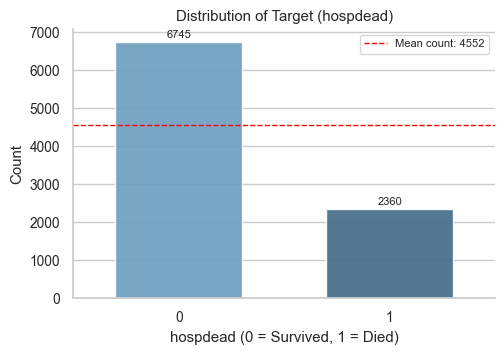

In [5]:
sns.set(style="whitegrid", font_scale=0.9)
counts = df["hospdead"].value_counts().sort_index()
mean_count = counts.mean()

plt.figure(figsize=(5,3.5))
ax = sns.barplot(x=counts.index, y=counts.values, palette="Blues_d", alpha=0.9, width=0.6)

for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2, p.get_height()+50, f"{int(p.get_height())}",
            ha="center", va="bottom", fontsize=8)
ax.axhline(mean_count, color="red", ls="--", lw=1, label=f"Mean count: {mean_count:.0f}")
ax.legend(frameon=True, loc="upper right", fontsize=8)

ax.set(title="Distribution of Target (hospdead)",
       xlabel="hospdead (0 = Survived, 1 = Died)", ylabel="Count")
sns.despine()
plt.tight_layout(pad=0.5)
plt.show()

**Bar Plot Analysis of `hospdead`**

| **Aspect** | **Observation** |
|:--|:--|
| **Class Distribution** | **Survived:** 6,745 (74.08%), **Died:** 2,360 (25.92%) |
| **Class Balance** | Slightly imbalance - “Survived” occured ~3× > “Died”. |
| **Mean Count** | 4,552 |

# **4. Basic Data Exploration**

In this step, we classify the variables as categorical or continuous and record the count of each type.

In [6]:
def classify_features(df, threshold=20):
    cat_feature = [c for c in df.columns if df[c].nunique(dropna=True) < threshold]
    num_feature = [c for c in df.columns if c not in cat_feature]
    feature_types = {c: 'Categorical' if c in cat_feature else 'Numerical' for c in df.columns}
    counts = {"Categorical": len(cat_feature), "Numerical": len(num_feature)}
    return feature_types, cat_feature, num_feature, counts

# Usage
feature_types, cat_feature, num_feature, counts = classify_features(df)
print(f"Categorical Features ({len(cat_feature)}): {cat_feature}")
print(f"Numerical Features ({len(num_feature)}): {num_feature}")
print(f"Counts: {counts}")

Categorical Features (16): ['death', 'sex', 'hospdead', 'dzgroup', 'dzclass', 'num.co', 'income', 'scoma', 'race', 'diabetes', 'dementia', 'ca', 'dnr', 'adlp', 'adls', 'sfdm2']
Numerical Features (32): ['id', 'age', 'slos', 'd.time', 'edu', 'charges', 'totcst', 'totmcst', 'avtisst', 'sps', 'aps', 'surv2m', 'surv6m', 'hday', 'prg2m', 'prg6m', 'dnrday', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun', 'urine', 'adlsc']
Counts: {'Categorical': 16, 'Numerical': 32}


In [7]:
info_df = pd.DataFrame({
    "dtype": df.dtypes,
    "non_null": df.notnull().sum(),
    "null": df.isnull().sum(),
    "unique": df.nunique()
})
info_df.index.name = "column"
info_df.reset_index(inplace=True)
info_df["feature_type"] = info_df["column"].map(feature_types)
info_df

column    dtype  non_null  null  unique feature_type
0         id    int64      9105     0    9105    Numerical
1        age  float64      9105     0    7323    Numerical
2      death    int64      9105     0       2  Categorical
3        sex   object      9105     0       2  Categorical
4   hospdead    int64      9105     0       2  Categorical
5       slos    int64      9105     0     167    Numerical
6     d.time    int64      9105     0    1724    Numerical
7    dzgroup   object      9105     0       8  Categorical
8    dzclass   object      9105     0       4  Categorical
9     num.co    int64      9105     0      10  Categorical
10       edu  float64      7471  1634      31    Numerical
11    income   object      6123  2982       4  Categorical
12     scoma  float64      9104     1      11  Categorical
13   charges  float64      8933   172    8501    Numerical
14    totcst  float64      8217   888    8197    Numerical
15   totmcst  float64      5630  3475    5516    Numerical
16   avtisst  float64      9023    82     352    Numerical
17      race   object      9063    42       5  Categorical
18       sps  float64      9104     1     604    Numerical
19       aps  float64      9104     1     125    Numerical
20    surv2m  float64      9104     1     949    Numerical
21    surv6m  float64      9104     1     936    Numerical
22      hday    int64      9105     0      85    Numerical
23  diabetes    int64      9105     0       2  Categorical
24  dementia    int64      9105     0       2  Categorical
25        ca   object      9105     0       3  Categorical
26     prg2m  float64      7456  1649      51    Numerical
27     prg6m  float64      7472  1633      87    Numerical
28       dnr   object      9075    30       3  Categorical
29    dnrday  float64      9075    30     177    Numerical
30    meanbp  float64      9104     1     164    Numerical
31      wblc  float64      8893   212     499    Numerical
32       hrt  float64      9104     1     186    Numerical
33      resp  float64      9104     1      66    Numerical
34      temp  float64      9104     1      98    Numerical
35      pafi  float64      6780  2325    1457    Numerical
36       alb  float64      5733  3372      60    Numerical
37      bili  float64      6504  2601     295    Numerical
38      crea  float64      9038    67     130    Numerical
39       sod  float64      9104     1      60    Numerical
40        ph  float64      6821  2284      77    Numerical
41   glucose  float64      4605  4500     439    Numerical
42       bun  float64      4753  4352     159    Numerical
43     urine  float64      4243  4862    1494    Numerical
44      adlp  float64      3464  5641       8  Categorical
45      adls  float64      6238  2867       8  Categorical
46     sfdm2   object      7705  1400       5  Categorical
47     adlsc  float64      9105     0    1735    Numerical

In [8]:
df.head()

column  id       age  death     sex  hospdead  slos  d.time  \
0        1  62.84998      0    male         0     5    2029   
1        2  60.33899      1  female         1     4       4   
2        3  52.74698      1  female         0    17      47   
3        4  42.38498      1  female         0     3     133   
4        5  79.88495      0  female         0    16    2029   

column            dzgroup             dzclass  num.co  ...      crea    sod  \
0             Lung Cancer              Cancer       0  ...  1.199951  141.0   
1               Cirrhosis  COPD/CHF/Cirrhosis       2  ...  5.500000  132.0   
2               Cirrhosis  COPD/CHF/Cirrhosis       2  ...  2.000000  134.0   
3             Lung Cancer              Cancer       2  ...  0.799927  139.0   
4       ARF/MOSF w/Sepsis            ARF/MOSF       1  ...  0.799927  143.0   

column        ph  glucose  bun  urine  adlp adls                sfdm2  adlsc  
0       7.459961      NaN  NaN    NaN   7.0  7.0                  NaN    7.0  
1       7.250000      NaN  NaN    NaN   NaN  1.0     <2 mo. follow-up    1.0  
2       7.459961      NaN  NaN    NaN   1.0  0.0     <2 mo. follow-up    0.0  
3            NaN      NaN  NaN    NaN   0.0  0.0  no(M2 and SIP pres)    0.0  
4       7.509766      NaN  NaN    NaN   NaN  2.0  no(M2 and SIP pres)    2.0  

[5 rows x 48 columns]

In [9]:
df.describe(include='all')

column           id          age        death   sex     hospdead         slos  \
count   9105.000000  9105.000000  9105.000000  9105  9105.000000  9105.000000   
unique          NaN          NaN          NaN     2          NaN          NaN   
top             NaN          NaN          NaN  male          NaN          NaN   
freq            NaN          NaN          NaN  5125          NaN          NaN   
mean    4553.000000    62.650823     0.681054   NaN     0.259198    17.863042   
std     2628.531434    15.593710     0.466094   NaN     0.438219    22.006440   
min        1.000000    18.041990     0.000000   NaN     0.000000     3.000000   
25%     2277.000000    52.797000     0.000000   NaN     0.000000     6.000000   
50%     4553.000000    64.856990     1.000000   NaN     0.000000    11.000000   
75%     6829.000000    73.998960     1.000000   NaN     1.000000    20.000000   
max     9105.000000   101.847960     1.000000   NaN     1.000000   343.000000   

column       d.time            dzgroup   dzclass       num.co  ...  \
count   9105.000000               9105      9105  9105.000000  ...   
unique          NaN                  8         4          NaN  ...   
top             NaN  ARF/MOSF w/Sepsis  ARF/MOSF          NaN  ...   
freq            NaN               3515      4227          NaN  ...   
mean     478.449863                NaN       NaN     1.868644  ...   
std      560.383272                NaN       NaN     1.344409  ...   
min        3.000000                NaN       NaN     0.000000  ...   
25%       26.000000                NaN       NaN     1.000000  ...   
50%      233.000000                NaN       NaN     2.000000  ...   
75%      761.000000                NaN       NaN     3.000000  ...   
max     2029.000000                NaN       NaN     9.000000  ...   

column         crea          sod           ph      glucose          bun  \
count   9038.000000  9104.000000  6821.000000  4605.000000  4753.000000   
unique          NaN          NaN          NaN          NaN          NaN   
top             NaN          NaN          NaN          NaN          NaN   
freq            NaN          NaN          NaN          NaN          NaN   
mean       1.770961   137.568541     7.415364   159.873398    32.349463   
std        1.686041     6.029326     0.080563    88.391541    26.792288   
min        0.099991   110.000000     6.829102     0.000000     1.000000   
25%        0.899902   134.000000     7.379883   103.000000    14.000000   
50%        1.199951   137.000000     7.419922   135.000000    23.000000   
75%        1.899902   141.000000     7.469727   188.000000    42.000000   
max       21.500000   181.000000     7.769531  1092.000000   300.000000   

column        urine         adlp         adls             sfdm2        adlsc  
count   4243.000000  3464.000000  6238.000000              7705  9105.000000  
unique          NaN          NaN          NaN                 5          NaN  
top             NaN          NaN          NaN  <2 mo. follow-up          NaN  
freq            NaN          NaN          NaN              3123          NaN  
mean    2191.546047     1.157910     1.637384               NaN     1.888272  
std     1455.245777     1.739672     2.231358               NaN     2.003763  
min        0.000000     0.000000     0.000000               NaN     0.000000  
25%     1165.500000     0.000000     0.000000               NaN     0.000000  
50%     1968.000000     0.000000     1.000000               NaN     1.000000  
75%     3000.000000     2.000000     3.000000               NaN     3.000000  
max     9000.000000     7.000000     7.000000               NaN     7.073242  

[11 rows x 48 columns]

- 🗑️ **Drop `id`** — not a feature or target.

In [10]:
num_feature = [col for col in num_feature if col != 'id']

## **4.1. Basic Data Exploration Results**

- **📌Note:** Selected columns are provisional; further refinement will follow.
- **⚠️Doubt:** Model-predicted or derived features may cause **data leakage and need review.**

**📥 Selected Variables**

| **No.** | **Feature** | **Type** | **Description** | **Status** |
|--:|:--|:--|:--|:--:|
| **1** | **age** | Numeric | Age of the patient (years). | Selected |
| **2** | **death** | Binary | Death up to 12/31/1994 (NDI follow-up; some not followed). ⚠️ **Doubt** | Selected |
| **3** | **sex** | Categorical | Gender of the patient (`male`, `female`). | Selected |
| **4** | **slos** | Numeric | Days from study entry to discharge. | Selected |
| **5** | **d.time** | Numeric | Days of follow-up. | Selected |
| **6** | **dzgroup** | Categorical | Sub-category of disease (e.g., ARF/MOSF w/Sepsis, COPD, Cirrhosis, etc.). | Selected |
| **7** | **dzclass** | Categorical | Broad disease category: ARF/MOSF, COPD/CHF/Cirrhosis, Cancer, Coma. | Selected |
| **8** | **num.co** | Integer | Number of comorbid diseases (higher = worse condition). | Selected |
| **9** | **edu** | Numeric | Years of education. | Selected |
| **10** | **charges** | Numeric | Hospital charges for each patient. | Selected |
| **11** | **income** | Ordinal | Income level: `<11k`, `11–25k`, `25–50k`, `>50k`. | Selected |
| **12** | **scoma** | Categorical | SUPPORT day-3 coma score (Glasgow scale, model-predicted). ⚠️ **Doubt** | Selected |
| **13** | **totcst** | Numeric | Total ratio of costs to charges (RCC). | Selected |
| **14** | **totmcst** | Numeric | Total micro-cost (labs, drugs, etc.). | Selected |
| **15** | **avtisst** | Numeric | Average TISS score, days 3–25 (ICU/IMCU cost index). | Selected |
| **16** | **race** | Categorical | Race of the patient: asian, black, hispanic, missing, other, white. | Selected |
| **17** | **sps** | Numeric | SUPPORT physiology score on day 3 (model-predicted). ⚠️ **Doubt** | Selected |
| **18** | **aps** | Numeric | APACHE III severity-of-illness score. | Selected |
| **19** | **surv2m** | Numeric | SUPPORT model 2-month survival estimate (predicted). ⚠️ **Doubt** | Selected |
| **20** | **surv6m** | Numeric | SUPPORT model 6-month survival estimate (predicted). ⚠️ **Doubt** | Selected |
| **21** | **hday** | Numeric | Hospital day at which patient entered study. | Selected |
| **22** | **diabetes** | Binary | Diabetes as comorbidity (`Y`/`N`). | Selected |
| **23** | **dementia** | Binary | Dementia as comorbidity (`Y`/`N`). | Selected |
| **24** | **ca** | Ordinal| Cancer status (`yes`, `metastatic`, `no`). | Selected |
| **25** | **prg2m** | Numeric | Physician’s 2-month survival estimate. ⚠️ **Doubt** | Selected |
| **26** | **prg6m** | Numeric | Physician’s 6-month survival estimate. ⚠️ **Doubt** | Selected |
| **27** | **dnr** | Categorical | Do-Not-Resuscitate status (`after sadm`, `before sadm`, `missing`, `no DNR`). | Selected |
| **28** | **dnrday** | Numeric | Day of DNR order (<0 if before study). | Selected |
| **29** | **meanbp** | Numeric | Mean arterial blood pressure (day 3). | Selected |
| **30** | **wblc** | Numeric | White blood cell count (thousands/µL, day 3). | Selected |
| **31** | **hrt** | Numeric | Heart rate (day 3). | Selected |
| **32** | **resp** | Numeric | Respiratory rate (day 3). | Selected |
| **33** | **temp** | Numeric | Temperature (°C, day 3). | Selected |
| **34** | **pafi** | Numeric | PaO₂/FiO₂ ratio (day 3, indicator of hypoxemia). | Selected |
| **35** | **alb** | Numeric | Serum albumin (g/dL, day 3). | Selected |
| **36** | **bili** | Numeric | Serum bilirubin (mg/dL, day 3). | Selected |
| **37** | **crea** | Numeric | Serum creatinine (mg/dL, day 3). | Selected |
| **38** | **sod** | Numeric | Serum sodium (mmol/L, day 3). | Selected |
| **39** | **ph** | Numeric | Arterial blood pH (day 3). | Selected |
| **40** | **glucose** | Numeric | Serum glucose (mg/dL, day 3). | Selected |
| **41** | **bun** | Numeric | Blood urea nitrogen (mg/dL, day 3). | Selected |
| **42** | **urine** | Numeric | Urine output (mL, day 3). | Selected |
| **43** | **adlp** | Categorical | Index of Activities of Daily Living (self-reported, day 3). | Selected |
| **44** | **adls** | Categorical | Index of ADL (surrogate-reported, day 3). | Selected |
| **45** | **sfdm2** | Ordinal | Functional disability scale (1–5, correlated with ADLs). | Selected |
| **46** | **adlsc** | Numeric | Imputed ADL, calibrated to surrogate reports. | Selected |
| **47** | **hospdead (🎯Target)** | Binary | Death in hospital (`yes` / `no`). | Selected |

**📙Data Summary Table**
| **Category** | **Type** | **Count** |
|:--|:--|:--:|
| **Feature Variables** | Numeric, Nominal / Ordinal / Binary | **31, 15**|
| **Target Variable** | Binary — *hospdead* | **1** |
| **Overall Variables** | Total (Features + Target) | **47** |

**📗Conclusion**
- At this stage, no variables were removed as useless. **All variables are selected and retained** for further analysis.
- **⚠️Doubt** for `death`, `scoma`, `sps`, `surv2m`, `surv6m`, `prg2m`, `prg6m`

# **5. Visual EDA for Data Distribution**

## **5.1. Visualize Distribution of Categorical Predictor Variables**

**Categorical Variables Overview**
| **Category** | **Variable Names** | **Count** |
|:--|:--|:--:|
| **Categorical Features** | `death`, `sex`, `dzgroup`, `dzclass`, `num.co`, `income`, `scoma`, `race`, `diabetes`, `dementia`, `ca`, `dnr`, `adlp`, `adls`, `sfdm2` | **15** |
| **Categorical Target** | `hospdead` | **1** |
| **Total** | — | **16** |

- Bar charts are used to visualize how the data is distributed across categorical columns.

In [11]:
def plot_categorical_bars(df, cols, n_cols=3, top=None, normalize=False):
    n_rows = ceil(len(cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 5*n_rows), 
                             squeeze=False, constrained_layout=True)
    
    for i, (ax, col) in enumerate(zip(axes.flatten(), cols)):
        counts = df[col].fillna("Missing").value_counts(dropna=False)
        counts = counts.head(top) if top else counts
        counts = (counts / counts.sum() * 100) if normalize else counts
        
        counts.plot(kind="bar", ax=ax, color="steelblue", edgecolor="black", alpha=0.6)
        ax.set_title(col, fontsize=10)
        ax.set_ylabel("%" if normalize else "Count")
        ax.tick_params(axis="x", rotation=90)
        ax.grid(axis="y", linestyle=":", linewidth=0.5, alpha=0.6)
    
    for ax in axes.flatten()[len(cols):]:
        ax.set_visible(False)
    
    fig.suptitle("Categorical Features", fontsize=14)
    plt.show()

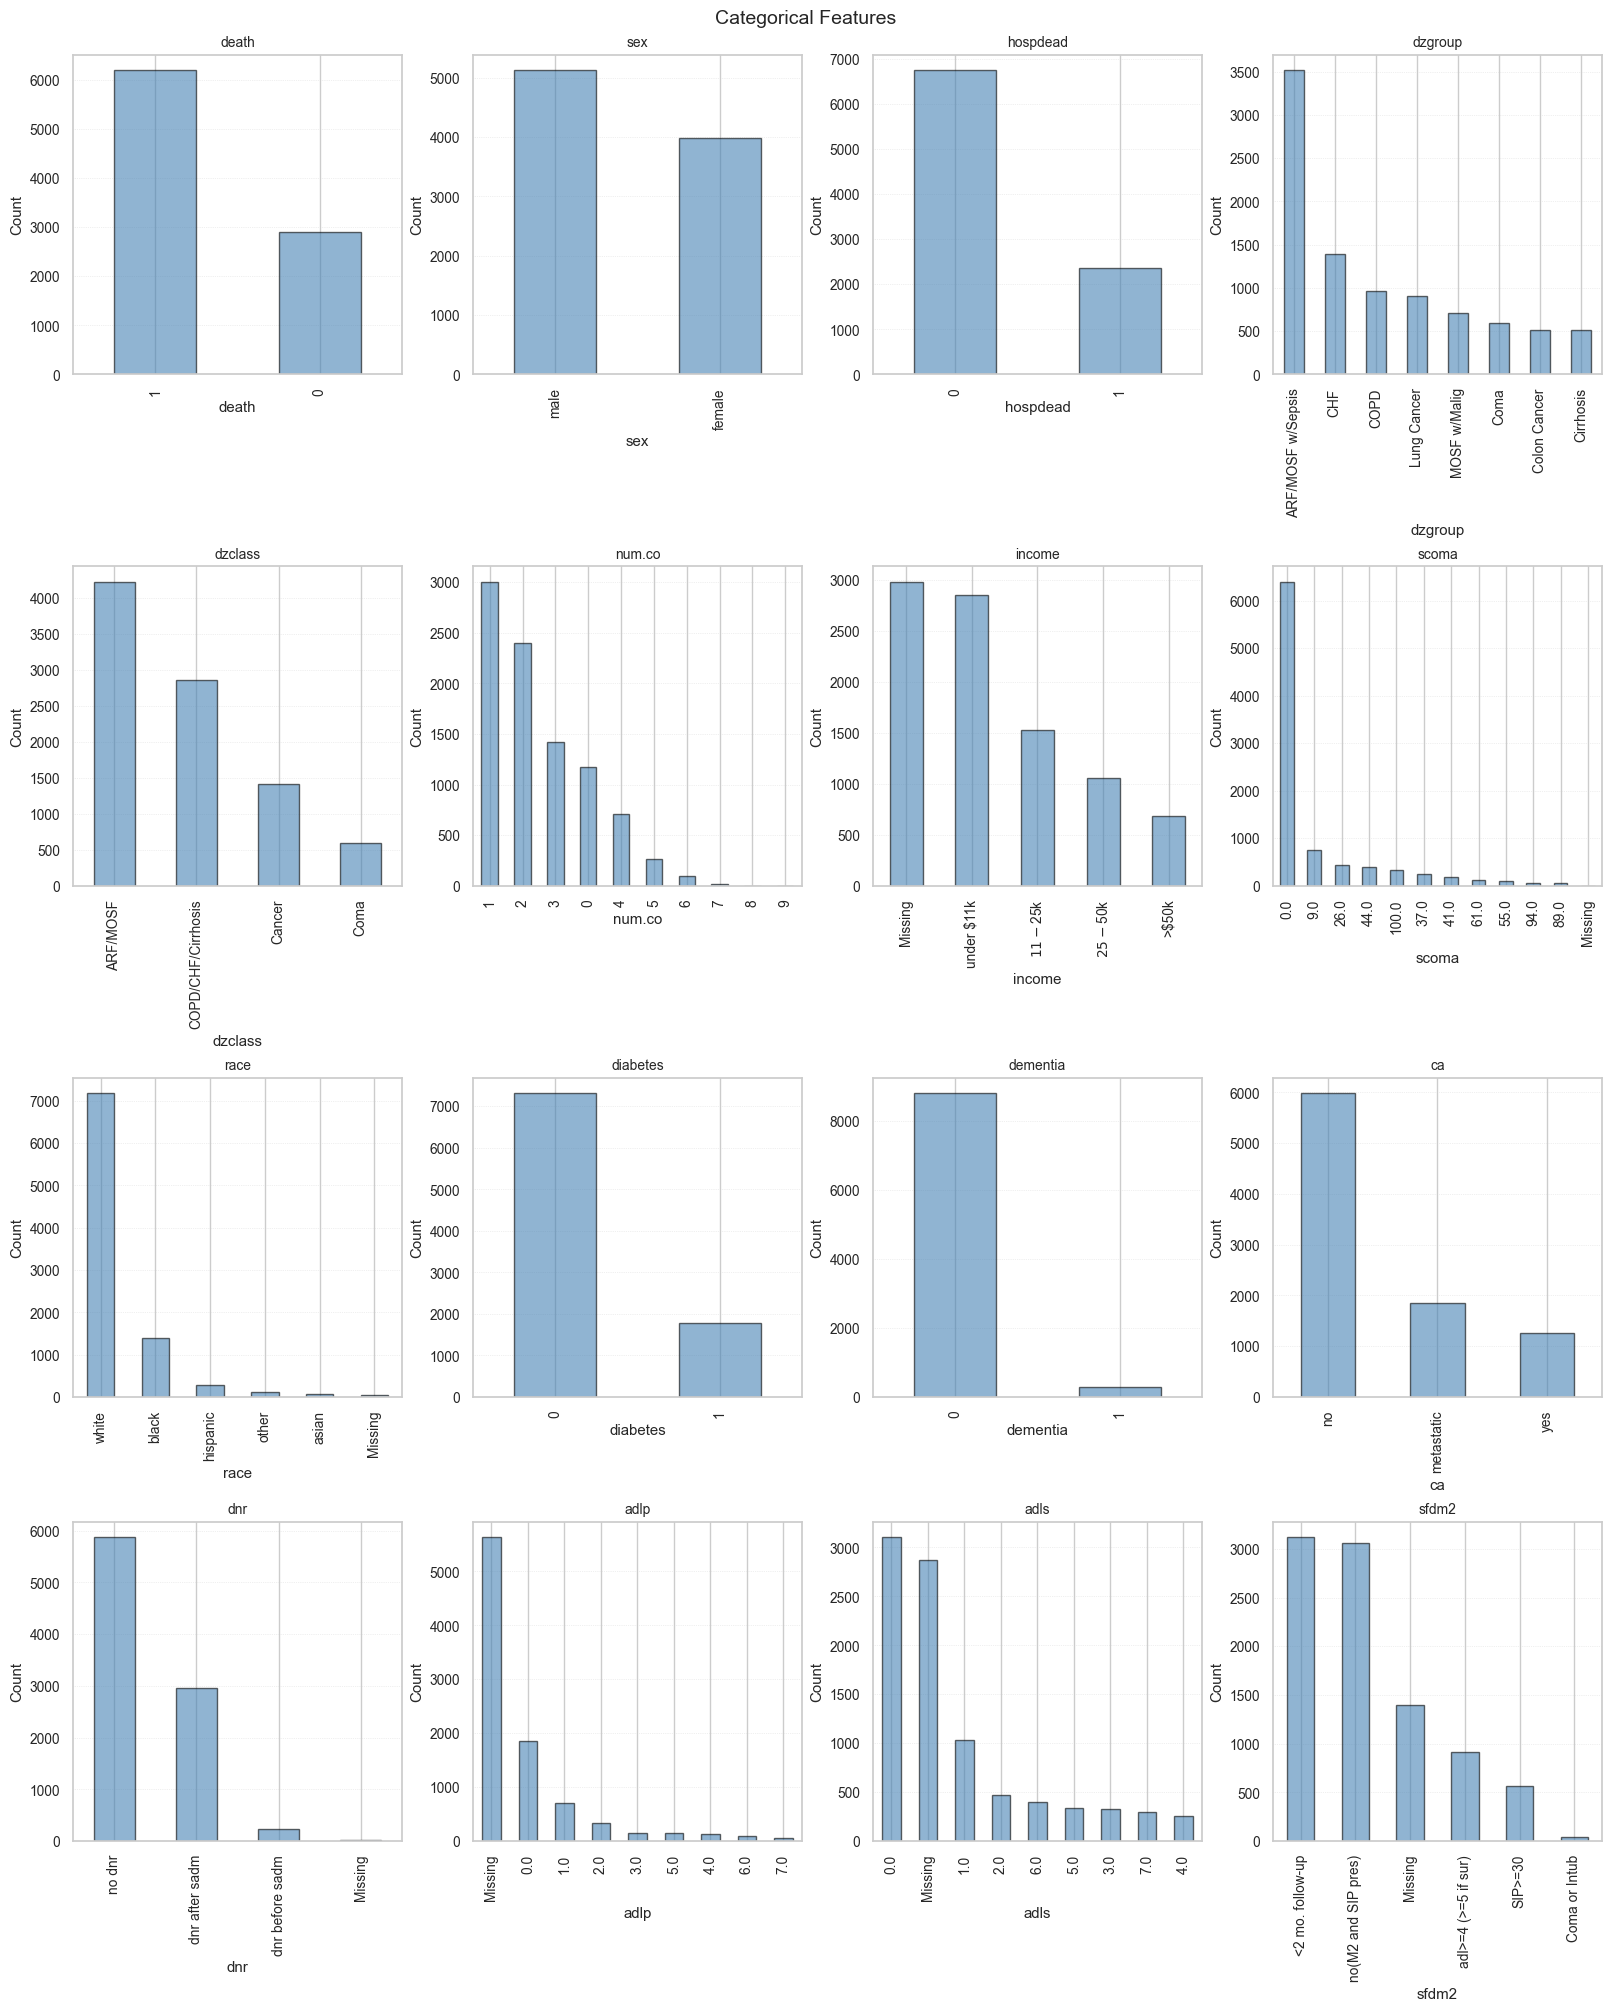

In [12]:
cat_cols=['death', 'sex', 'hospdead', 'dzgroup', 'dzclass', 'num.co', 'income', 'scoma', 'race', 'diabetes', 'dementia', 'ca', 'dnr', 'adlp', 'adls', 'sfdm2']
plot_categorical_bars( df, cat_cols, n_cols=4, top=None, normalize=False)

### **5.1.1. Bar Charts Interpretation**

- **📌Note:** All categorical variables are **retained** for further analysis.  
- **⚠️Doubt:** Some variables show **imbalance**, **missing data**, or **potential multicollinearity**.

---

📥 **Selected Categorical Variables**
| **Status** | **Variable(s)** | **Observation** |
|:--|:--|:--|
| ✅ **Selected** | `sex`, `dzgroup`, `dzclass`, `num.co`, `diabetes`, `ca`, `dnr`, `death`, `hospdead`, `sfdm2` | Normal |
| ⚠️ **Doubt** | `income`, `adlp`, `adls` | Missing values |
|  | `race`, `dementia` | Imbalanced distribution |

**📗Conclusion**
- No categorical columns are removed at this stage.  
- **All 16 categorical variables are retained** for further analysis.  
- Since visual interpretation is ***less reliable than statistical testing***, all are preserved for now.

## **5.2. Visualize Distribution of Continuous Predictor Variables**

**Continuous Variables Overview**
| **Category** | **Variable Names** | **Count** |
|:--|:--|:--:|
| **Continuous Features** | `age`, `slos`, `d.time`, `edu`, `charges`, `totcst`, `totmcst`, `avtisst`, `sps`, `aps`, `surv2m`, `surv6m`, `hday`, `prg2m`, `prg6m`, `dnrday`, `meanbp`, `wblc`,`hrt`, `resp`, `temp`, `pafi`, `alb`, `bili`, `crea`, `sod`, `ph`, `glucose`, `bun`, `urine`, `adlsc` | **31** |
| **Total** | — | **31** |
- Histograms are used to visualize the distribution of data across continuous variables.

### **5.2.1. Visualize Distribution in Data Using Histograms**

In [13]:
def plot_hist_grid(df, cols, bins=30, n_cols=4, show_kde=True, kde_bw=None):
    n_rows = ceil(len(cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), constrained_layout=True)
    axes = axes.flatten()
    
    for i, (ax, col) in enumerate(zip(axes, cols)):
        s = df[col].replace([np.inf, -np.inf], np.nan).dropna()
        if s.size == 0:
            ax.set_visible(False)
            continue
        counts = ax.hist(s, bins=bins, color="steelblue", edgecolor="black", alpha=0.6)
        
        if show_kde and s.size > 1 and np.ptp(s) > 0:
            kde = gaussian_kde(s, bw_method=kde_bw)
            x = np.linspace(s.min(), s.max(), 512)
            y = kde(x) * s.size * (counts[1][1] - counts[1][0])
            ax.plot(x, y, linewidth=1, color="steelblue")
            
        ax.axvline(s.mean(), color="red", linestyle="--", linewidth=0.8, label="Mean")
        ax.axvline(s.median(), color="green", linestyle="-.", linewidth=0.8, label="Median")
        mode = s.mode(dropna=True)
        if not mode.empty:
            ax.axvline(float(mode.iloc[0]), color="blue", linestyle=":", linewidth=0.8, label="Mode")
        
        ax.set_title(col, fontsize=10)
        ax.set_ylabel("Frequency")
        ax.grid(axis="y", linestyle=":", alpha=0.6)
    
    for ax in axes[len(cols):]:
        ax.set_visible(False)
    
    fig.suptitle("Histograms of numeric features", fontsize=14)
    plt.show()

In [14]:
def summarize_numeric(df, cols):
    summary = {}
    for col in cols:
        series = df[col].replace([np.inf, -np.inf], np.nan).dropna()
        if series.size > 0:
            mean_value = float(series.mean())
            median_value = float(series.median())
            mode_series = series.mode(dropna=True)
            mode_value = float(mode_series.iloc[0]) if not mode_series.empty else mean_value
            summary[col] = {
                "Mean": mean_value,
                "Median": median_value,
                "Mode": mode_value
            }
    return pd.DataFrame(summary).T

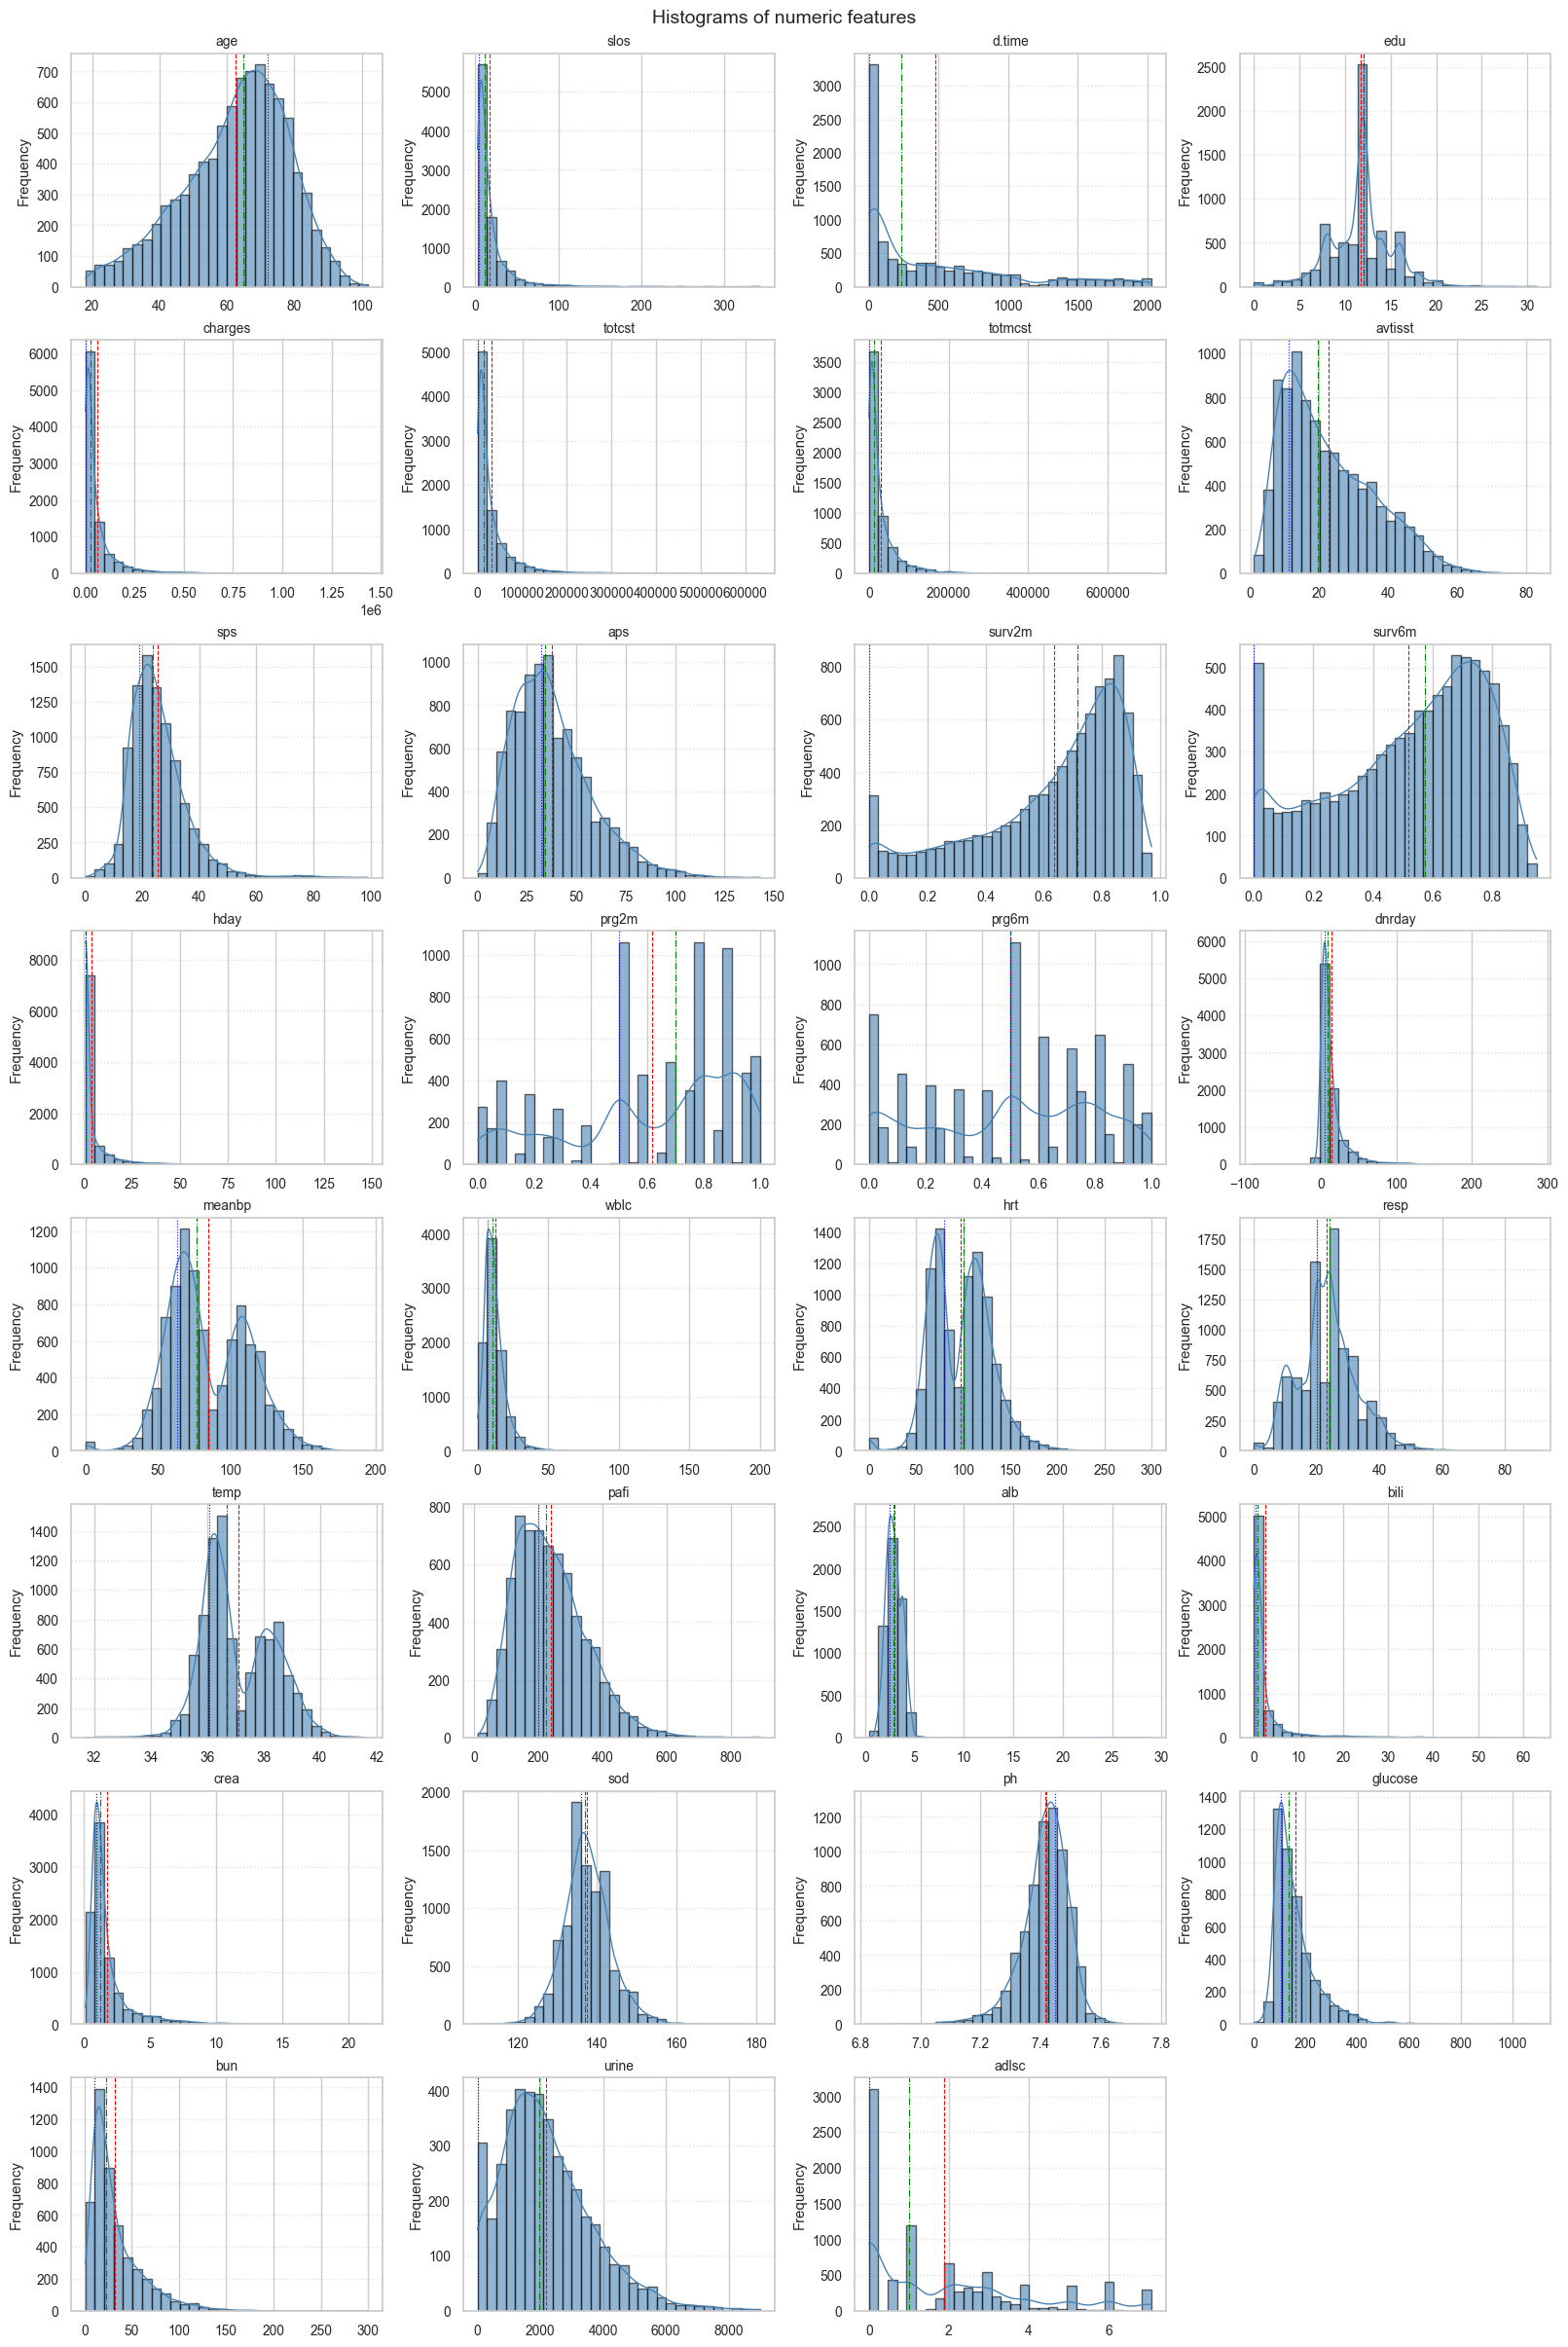

In [15]:
num_cols = ['age', 'slos', 'd.time', 'edu', 'charges', 'totcst', 'totmcst', 'avtisst', 'sps', 'aps', 'surv2m', 'surv6m', 'hday', 'prg2m', 'prg6m', 'dnrday', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun', 'urine', 'adlsc']
plot_hist_grid(df, num_cols, bins=30, n_cols=4)

- **Visualize overall the MEAN, MEDIAN, MODE.**

In [16]:
summarize_numeric(df, num_cols) # mean, median, mode

Mean        Median         Mode
age         62.650823     64.856990    71.996950
slos        17.863042     11.000000     5.000000
d.time     478.449863    233.000000     4.000000
edu         11.747691     12.000000    12.000000
charges  59995.787811  25024.000000  4510.000000
totcst   30825.867768  14452.734400     0.000000
totmcst  28828.877838  13223.500000     0.000000
avtisst     22.610928     19.500000    11.000000
sps         25.525872     23.898438    18.898438
aps         37.597979     34.000000    32.000000
surv2m       0.635870      0.715942     0.000000
surv6m       0.520096      0.574951     0.000000
hday         4.400000      1.000000     1.000000
prg2m        0.618769      0.700000     0.500000
prg6m        0.499679      0.500000     0.500000
dnrday      14.582590      9.000000     5.000000
meanbp      84.546408     77.000000    63.000000
wblc        12.347677     10.599609     6.799805
hrt         97.156711    100.000000    80.000000
resp        23.330294     24.000000    20.000000
temp        37.103341     36.695310    36.093750
pafi       239.529070    224.000000   200.000000
alb          2.950520      2.899902     2.500000
bili         2.554463      0.899902     0.399963
crea         1.770961      1.199951     0.899902
sod        137.568541    137.000000   136.000000
ph           7.415364      7.419922     7.449219
glucose    159.873398    135.000000   103.000000
bun         32.349463     23.000000    11.000000
urine     2191.546047   1968.000000     0.000000
adlsc        1.888272      1.000000     0.000000

### **5.2.2. Visualize Distribution in Data Using Box Plots**

In [17]:
def plot_box_grid(df, cols, n_cols=4):
    n = len(cols)
    n_rows = ceil(n / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), constrained_layout=True)
    axes = axes.flatten()
    for i, col in enumerate(cols):
        series = df[col].dropna()
        axes[i].boxplot(series, vert=True, patch_artist=True, boxprops=dict(facecolor="lightblue", color="black"), medianprops=dict(color="red"), whiskerprops=dict(color="black"), capprops=dict(color="black"))
        axes[i].set_title(col, fontsize=10)
        axes[i].set_ylabel("")
        axes[i].grid(axis="y", linestyle=":", alpha=0.6)
    for j in range(i+1, n_rows*n_cols):
        axes[j].set_visible(False)
    fig.suptitle("Boxplots of numeric features", fontsize=14)
    plt.show()

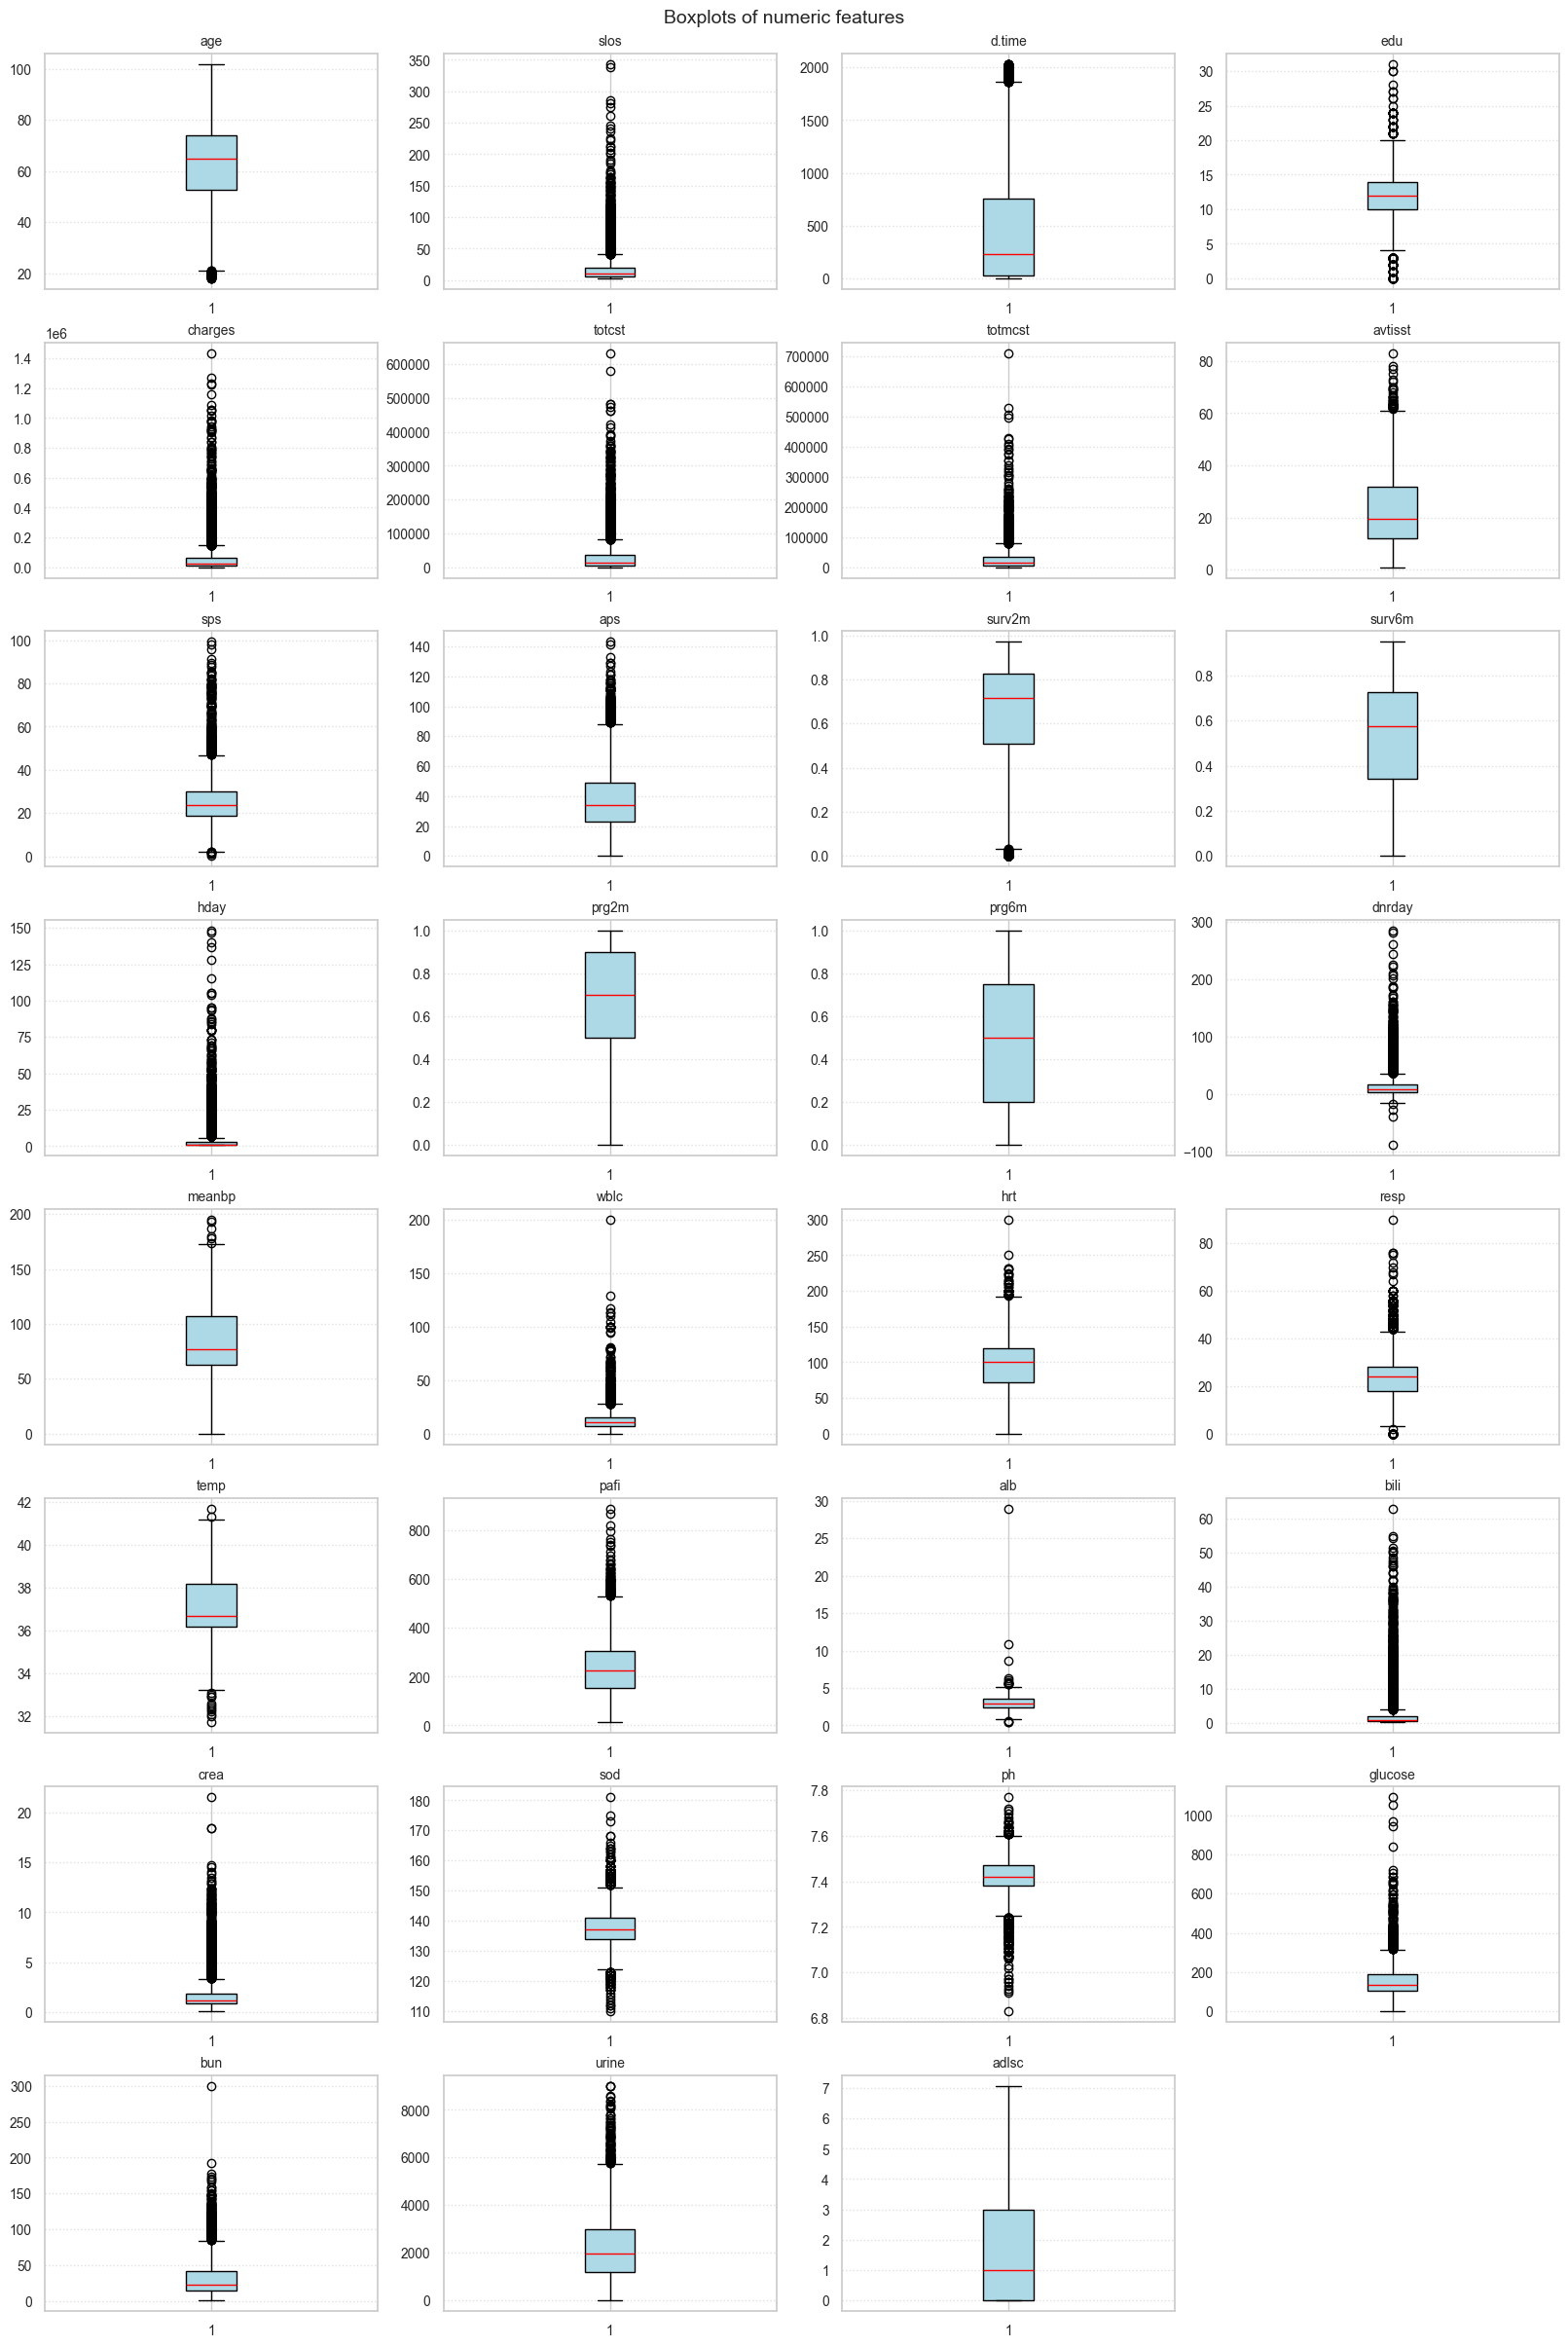

In [18]:
num_cols = ['age', 'slos', 'd.time', 'edu', 'charges', 'totcst', 'totmcst', 'avtisst', 'sps', 'aps', 'surv2m', 'surv6m', 'hday', 'prg2m', 'prg6m', 'dnrday', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun', 'urine', 'adlsc']
plot_box_grid(df, num_cols, n_cols=4)

### **5.2.3. Histogram and Boxplot Interpretation**

- **📌Note:** All continuous variables are **retained** for further analysis.  
- **⚠️Observation:** Several variables display **right-skewed** or **bimodal** distributions; however, all remain analytically acceptable.

---

📊 **Selected Continuous Variables**
| **Status** | **Variable(s)** | **Observation** |
|:--|:--|:--|
| ✅**Selected** | `age`, `ph`, `sps`, `aps`, `resp`, `sod` | Approximately normal or near-normal distribution; acceptable. |
| ✅**Selected** | `edu`, `pafi`, `urine` | Slight right-skew; acceptable without transformation. |
| ✅**Selected** | `slos`, `d.time`, `totcst`, `totmcst`, `avtisst`, `hday`, `dnrday`, `wblc`, `glucose`, `bun`, `alb`, `bili`, `crea` | Strong positive skew; expected due to medical cost and physiological variability. Acceptable for now. |
| ✅**Selected** | `meanbp`, `hrt`, `temp` | Bimodal patterns reflecting physiological subgroups (e.g., fever, hypothermia, tachycardia). Acceptable. |
| ✅**Selected** | `surv2m`, `surv6m` | Well-distributed model-predicted survival scores. |
| ✅**Selected** | `prg2m`, `prg6m`, `adlsc` | Irregular with spikes; acceptable as they reflect clinical judgment or imputed scales. |

**📗Conclusion**
- No continuous variables are removed at this stage.  
- **All 31 predictors are retained** for statistical testing and modeling.  
- Because **visual interpretation can mislead without statistical support**, these distributions will be further assessed using quantitative normality and outlier diagnostics.

## **5.3. Visual Exploration Data and Results**

- The SUPPORT880 dataset includes clinical data from hospitalized patients across nine disease groups. Some extreme values are clinically valid (e.g., 250 BPM in tachycardia), so **all continuous variables are retained** to preserve meaningful variation.

1. **Data Transformation:**  
   Log transformation may be applied to reduce skewness in features and target.
   
2. **Outliers Retained:**  
   Outliers represent real clinical conditions and are **kept**, as they may indicate high-cost cases.

**📗Conclusion**
- **Model 1** will **apply transformation** and **kept outliers** in variables.

## **5.4. Data Leakage**

**📌Note:** Certain variables contain information unavailable, These were **excluded** to prevent data leakage during modeling.

---

🚫 **Data Leakage Removal**
| **Status** | **Variable(s)** | **Reason for Exclusion** |
|:--|:--|:--|
| ❌ **Removed** | `death` | Directly defines the target variable `hospdead`; would cause perfect data leakage. |
| ❌ **Removed** | `scoma` | Derived from a pre-trained model (Glasgow coma prediction) → indirect leakage. |
| ❌ **Removed** | `sps` | Simplified Physiology Score computed from model-based estimations → indirect leakage. |
| ❌ **Removed** | `surv2m`, `surv6m` | Predicted survival estimates using future outcomes → not available at admission. |
| ❌ **Removed** | `prg2m`, `prg6m` | Physician survival prognosis based on post-admission outcomes → future information leakage. |

**📗Conclusion**
- A total of **7 variables** are excluded to ensure fair model training and avoid target contamination.  
- All retained variables represent **information realistically available at admission** for predictive modeling.

**📙Data Summary Table**
| **Category** | **Type** | **Count** |
|:--|:--|:--:|
| **Feature Variables** | Numeric, Nominal / Ordinal / Binary | **26, 13**|
| **Target Variable** | Binary — *y* (Term Deposit Subscription) | **1** |
| **Overall Variables** | Total (Features + Target) | **40** |

In [19]:
leak_col_num = ['sps', 'surv2m', 'surv6m', 'prg2m', 'prg6m']
leak_col_cat = ['scoma', 'death']
df = df.drop(columns=leak_col_num+leak_col_cat)
print(df.shape)

(9105, 41)


In [20]:
num_feature = [col for col in num_feature if col not in leak_col_num]
cat_feature = [col for col in cat_feature if col not in leak_col_cat]

# **6. Outlier Treatment**

**📌Note:** Outliers are retained across all continuous variables to preserve clinical variability and real-world data behavior.  
**⚠️Observation:** Medical datasets often contain **true physiological extremes** rather than statistical errors; hence, trimming would risk information loss.

---

📊 **Outlier Treatment Summary**
| **Status** | **Variable(s)** | **Outliers** | **Observation** |
|:--|:--|:--|:--|
| ✅**Retained** | `age`, `edu`, `hday`, `dnrday` | Keep | Natural variability across age and hospital timelines. |
| ✅**Retained** | `slos`, `d.time` | Keep | Reflects real clinical length of stay and follow-up differences. |
| ✅**Retained** | `avtisst`, `aps` | Keep | Clinical score range wide by design; not erroneous. |
| ✅**Retained** | `meanbp`, `hrt`, `resp`, `temp` | Keep | Represents diverse physiological states. |
| ✅**Retained** | `wblc`, `pafi`, `alb`, `bili`, `crea`, `sod`, `ph`, `glucose`, `bun`, `urine` | Keep | High medical variability, outliers are clinically valid. |
| ✅**Retained** | `adlsc` | Keep | Functional ability varies greatly; extreme scores are meaningful. |

**📗Conclusion**
- No outliers were removed at this stage.  

# **7. Missing Value Treatment**

- Columns with **>30% missing values** are rejected due to excessive data loss.  

**📌Note:**
- **Continuous:** Impute with **MEAN** or **MEDIAN**  
- **Categorical:** Impute with **MODE**

## **7.1. Missing Values Treatment for Continuous Features**

### **7.1.1. Removing the Missing Values**

In [21]:
missing = df[num_feature].isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_table = pd.DataFrame({'Missing Values': missing,'Percentage': missing_percent.round(2)})
print(missing_table.sort_values(by="Percentage", ascending=False))
missing_table = missing_table[missing_table['Missing Values'] > 0]

         Missing Values  Percentage
column                             
urine              4862       53.40
glucose            4500       49.42
bun                4352       47.80
totmcst            3475       38.17
alb                3372       37.03
bili               2601       28.57
pafi               2325       25.54
ph                 2284       25.09
edu                1634       17.95
totcst              888        9.75
wblc                212        2.33
charges             172        1.89
avtisst              82        0.90
crea                 67        0.74
dnrday               30        0.33
aps                   1        0.01
meanbp                1        0.01
hrt                   1        0.01
resp                  1        0.01
temp                  1        0.01
sod                   1        0.01
slos                  0        0.00
hday                  0        0.00
d.time                0        0.00
age                   0        0.00
adlsc                 0     

In [22]:
to_drop = missing_table[missing_table['Percentage'] > 30].index.tolist()
df_clean = df.drop(columns=to_drop)
print("Dropped features:", to_drop)
print("New shape:", df_clean.shape)

Dropped features: ['totmcst', 'alb', 'glucose', 'bun', 'urine']
New shape: (9105, 36)


In [23]:
num_feature = [col for col in num_feature if col not in to_drop]

- 🗑️ **Drop `totmcst` , `alb` ,`glucose`, `bun`, `urine`** — features with >30% Missing Values Removed.

**📙Data Summary Table**
| **Category** | **Type** | **Count** |
|:--|:--|:--:|
| **Feature Variables** | Numeric, Nominal / Ordinal / Binary | **21, 13**|
| **Target Variable** | Binary — *y* (Term Deposit Subscription) | **1** |
| **Overall Variables** | Total (Features + Target) | **35** |

### **7.1.2. Filling Missing Values**


**📌Note:**
- **Skewed features:** Fill with **MEDIAN** (less sensitive to outliers).  
- **Non-skewed features:** Fill with **MEAN**.

---

#### **7.1.2.1. Fill missing values with MEAN**

From the histogram and boxplot interpretation (Section 5.2.3), the following features show approximately **normal distributions** and thus have their missing values filled with the **MEAN**
- `age`, `surv6m`, `meanbp`, `hrt`, `temp`, `sod`, `ph`

In [24]:
mean_features = ['age', 'meanbp', 'hrt', 'temp', 'sod', 'ph']
df_clean[mean_features] = df_clean[mean_features].fillna(df_clean[mean_features].mean())

#### **7.1.2.2. Fill missing values with MEDIAN**

**All the features left have skewed distributions**, so missing values are filled wit the **MEDIAN**

In [25]:
miss = df_clean[num_feature].isna().mean() * 100
to_impute = miss[(miss > 0) & (miss < 30)].index
df_clean[to_impute] = df_clean[to_impute].fillna(df_clean[to_impute].median())
print("Imputed (median):", list(to_impute))
print(df_clean[to_impute].isna().sum()[lambda s: s > 0])

Imputed (median): ['edu', 'charges', 'totcst', 'avtisst', 'aps', 'dnrday', 'wblc', 'resp', 'pafi', 'bili', 'crea']
Series([], dtype: int64)


### **7.1.3. Result After Missing Values Treatment**

In [26]:
missing_clean = df_clean[num_feature].isnull().sum()
missing_percent_clean = (missing_clean / len(df_clean[num_feature])) * 100
missing_table_clean = pd.DataFrame({'Missing Values': missing_clean,'Percentage': missing_percent_clean.round(2)})
print(missing_table_clean.sort_values(by="Percentage", ascending=False))
missing_table_clean = missing_table_clean[missing_table_clean['Missing Values'] > 0]

         Missing Values  Percentage
column                             
age                   0         0.0
slos                  0         0.0
d.time                0         0.0
edu                   0         0.0
charges               0         0.0
totcst                0         0.0
avtisst               0         0.0
aps                   0         0.0
hday                  0         0.0
dnrday                0         0.0
meanbp                0         0.0
wblc                  0         0.0
hrt                   0         0.0
resp                  0         0.0
temp                  0         0.0
pafi                  0         0.0
bili                  0         0.0
crea                  0         0.0
sod                   0         0.0
ph                    0         0.0
adlsc                 0         0.0


**📗Conclusion**
- No missing values left in continuous features

## **7.2. Missing Values Treatment for Categorical Features**

### **7.2.1.Removing the Missing Values**

In [27]:
missing = df_clean[cat_feature].isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_table = pd.DataFrame({'Missing Values': missing,'Percentage': missing_percent.round(2)})
print(missing_table.sort_values(by="Percentage", ascending=False))
missing_table = missing_table[missing_table['Missing Values'] > 0]

          Missing Values  Percentage
column                              
adlp                5641       61.95
income              2982       32.75
adls                2867       31.49
sfdm2               1400       15.38
race                  42        0.46
dnr                   30        0.33
num.co                 0        0.00
dzclass                0        0.00
dzgroup                0        0.00
hospdead               0        0.00
sex                    0        0.00
ca                     0        0.00
diabetes               0        0.00
dementia               0        0.00


In [28]:
to_drop_cat = missing_table[missing_table['Percentage'] > 30].index.tolist()
df_clean = df_clean.drop(columns=to_drop_cat)
print("Dropped categorical features:", to_drop_cat)
print("New shape:", df_clean.shape)

Dropped categorical features: ['income', 'adlp', 'adls']
New shape: (9105, 33)


In [29]:
cat_feature = [col for col in cat_feature if col not in to_drop_cat]

### **7.2.2. Filling the missing values**

- Categorical fill values with **MODE**

In [30]:
mode_features = ['sfdm2','race','dnr']
mode_dict = {col: df_clean[col].mode()[0] for col in mode_features}
df_clean[mode_features] = df_clean[mode_features].fillna(mode_dict)

In [31]:
num_missing_cols = (df_clean.isnull().sum() > 0).sum()
print("Number of features with missing values:", num_missing_cols)
print("New shape:", df_clean.shape)

Number of features with missing values: 0
New shape: (9105, 33)


In [32]:
missing = df_clean.isnull().sum()
missing_percent = (missing / len(df_clean)) * 100
missing_table = pd.DataFrame({'Missing Values': missing,'Percentage': missing_percent.round(2)})
print(missing_table.sort_values(by="Percentage", ascending=False))
missing_table = missing_table[missing_table['Missing Values'] > 0]

          Missing Values  Percentage
column                              
id                     0         0.0
age                    0         0.0
sex                    0         0.0
hospdead               0         0.0
slos                   0         0.0
d.time                 0         0.0
dzgroup                0         0.0
dzclass                0         0.0
num.co                 0         0.0
edu                    0         0.0
charges                0         0.0
totcst                 0         0.0
avtisst                0         0.0
race                   0         0.0
aps                    0         0.0
hday                   0         0.0
diabetes               0         0.0
dementia               0         0.0
ca                     0         0.0
dnr                    0         0.0
dnrday                 0         0.0
meanbp                 0         0.0
wblc                   0         0.0
hrt                    0         0.0
resp                   0         0.0
t

**📗Conclusion**
- No missing values left in categorical features

## **7.3. Visualization After Missing Value Treatment**

**📌Note:** Histograms and boxplots confirm that imputation preserved each feature’s distribution, spread, and outliers without distortion.

- ***Continuous Features***

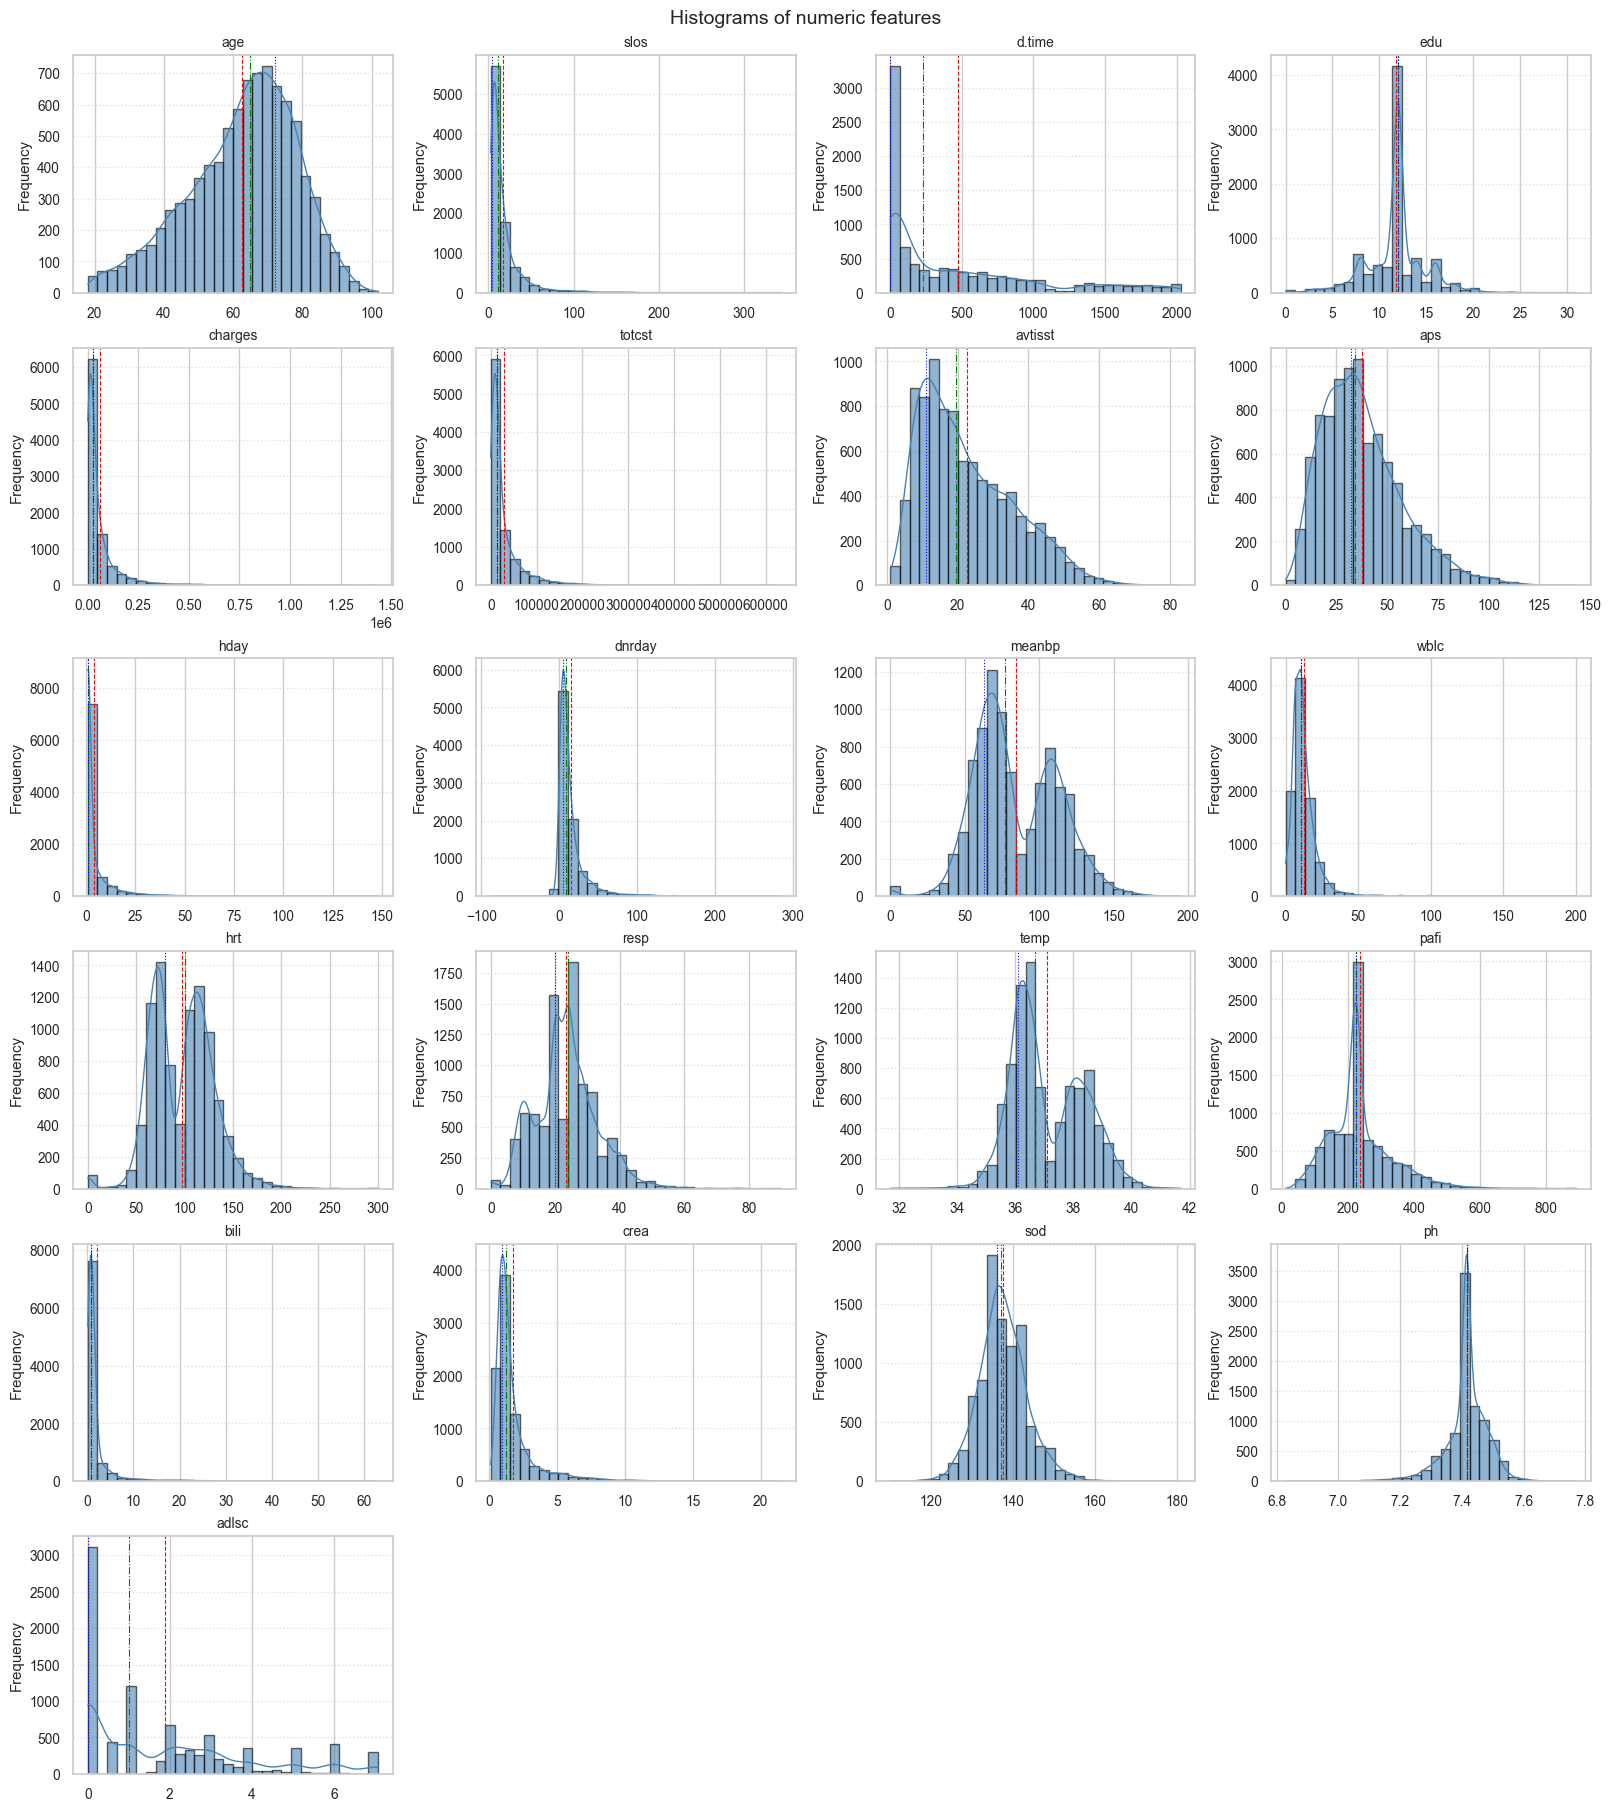

In [33]:
plot_hist_grid(df_clean, num_feature, bins=30, n_cols=4)

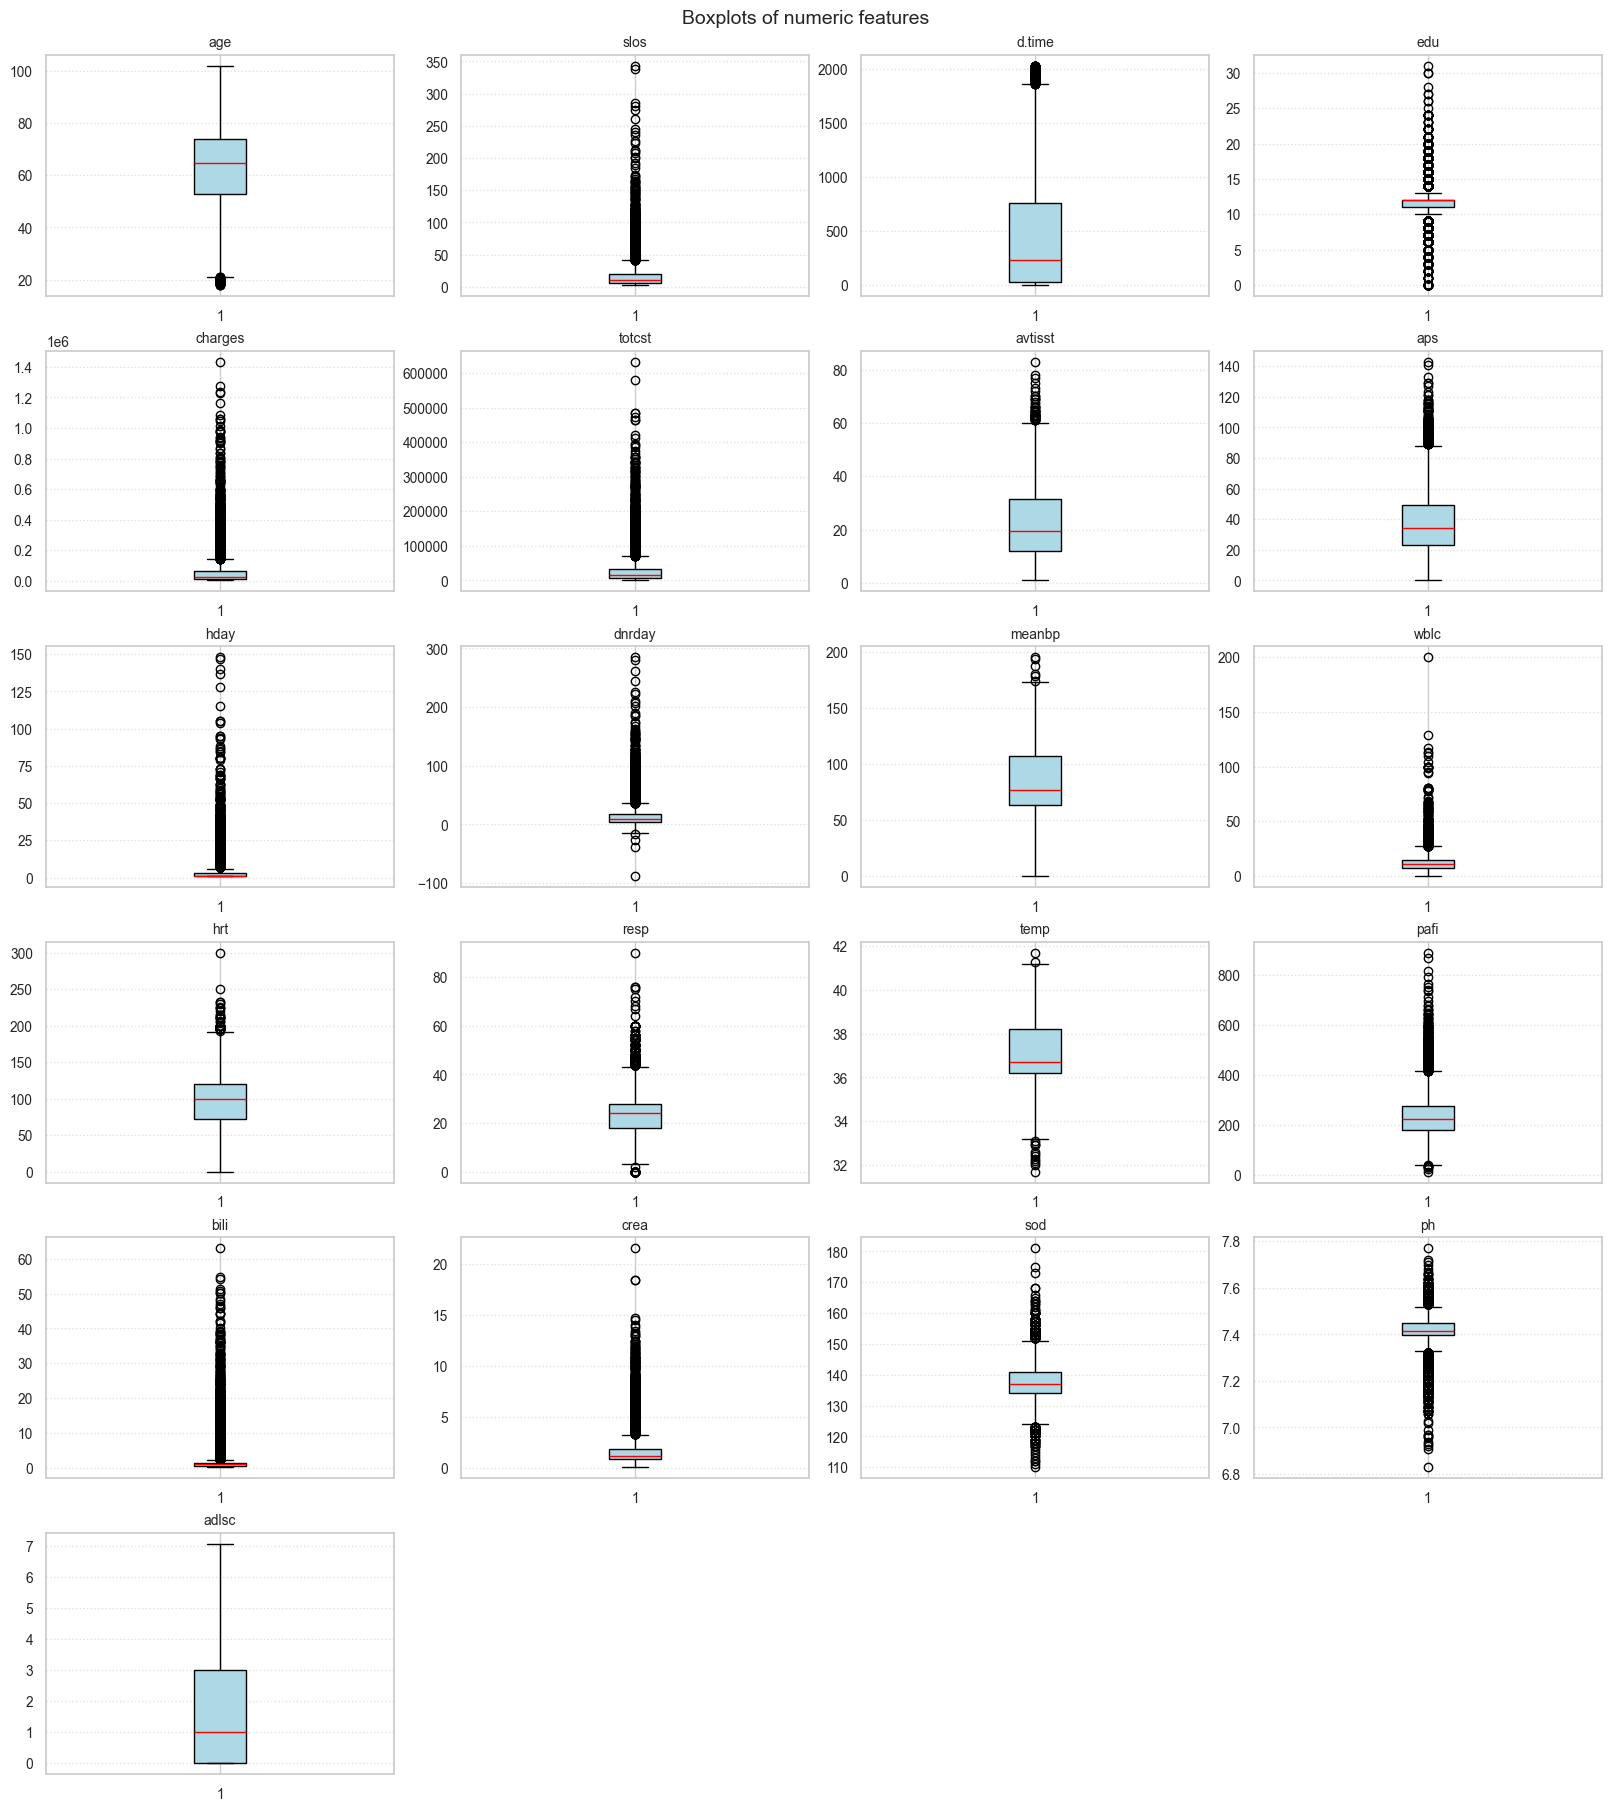

In [34]:
plot_box_grid(df_clean, num_feature, n_cols=4,)

- ***Categorical Features***

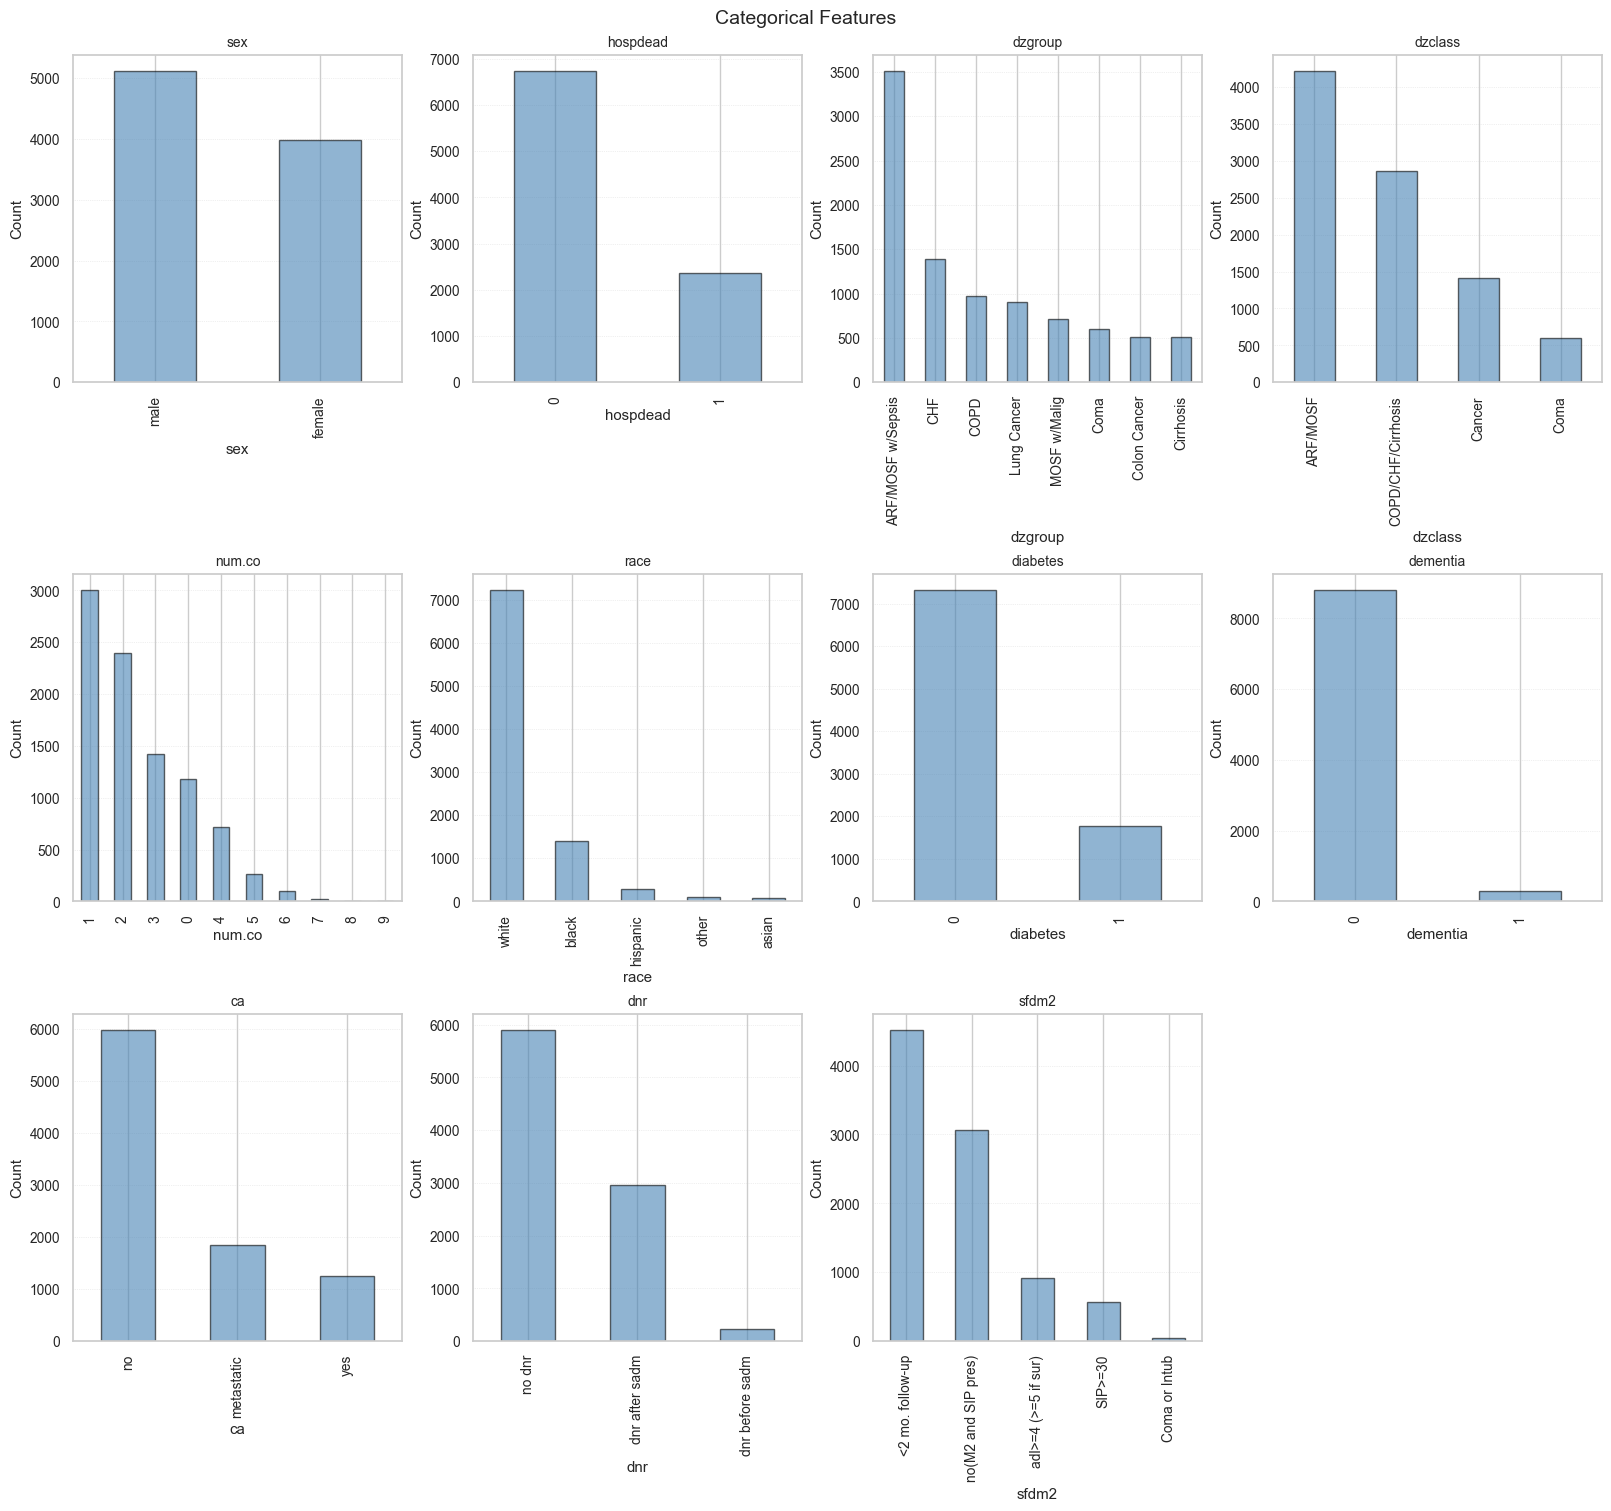

In [35]:
plot_categorical_bars(df_clean, cat_feature, n_cols=4,)

**📗Conclusion**
- Histograms and boxplots after missing value treatment show that the data’s distribution and spread **remain the same**, indicating the imputation did not distort the dataset.

## **7.4. Training and Testing Sample**

**Splitting the Data**
- **70%** of data is used as Training data and the rest **30%** is used as Tesing data.

In [36]:
target_var = ['hospdead'] 
cat_feature = [col for col in cat_feature if col != 'hospdead']
predicted_var = num_feature + cat_feature

In [37]:
X = df_clean[predicted_var]
y = df_clean[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

- **Check the distribution y_train and y_test**

C:\Users\User\AppData\Local\Temp\ipykernel_30588\2253256308.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=c.index, y=c.values, palette=pal, ax=ax, alpha=0.9, width=0.6)
C:\Users\User\AppData\Local\Temp\ipykernel_30588\2253256308.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=c.index, y=c.values, palette=pal, ax=ax, alpha=0.9, width=0.6)


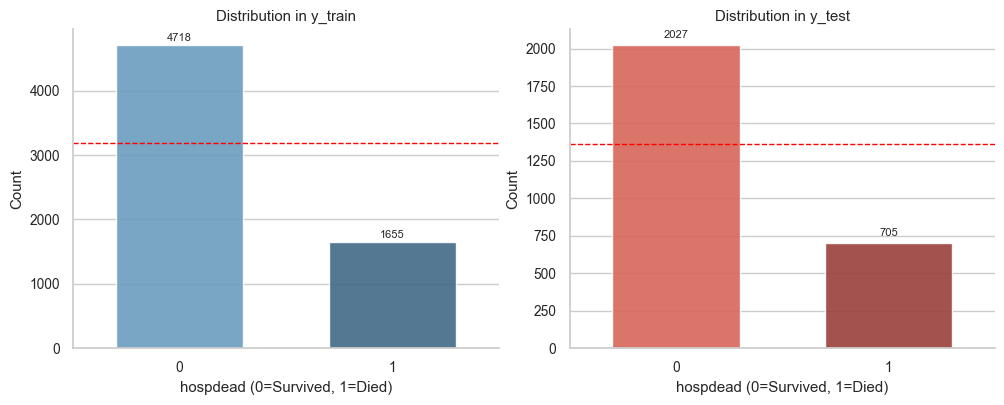

In [38]:
sns.set(style="whitegrid", font_scale=0.9)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, (data, pal, title) in zip(axes, [(y_train, "Blues_d", "y_train"), (y_test, "Reds_d", "y_test")]):
    c = data["hospdead"].value_counts().sort_index()
    sns.barplot(x=c.index, y=c.values, palette=pal, ax=ax, alpha=0.9, width=0.6)
    ax.axhline(c.mean(), color="red", ls="--", lw=1)
    for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, p.get_height()+30, f"{int(p.get_height())}",
                ha="center", va="bottom", fontsize=8)
    ax.set(title=f"Distribution in {title}", xlabel="hospdead (0=Survived, 1=Died)", ylabel="Count")
    sns.despine(ax=ax)

plt.tight_layout(pad=0.5)
plt.show()

**📗Conclusion**
- The visualization of training and testing data shows **similar distributions**.

In [39]:
train_df = X_train.copy()
train_df["hospdead"] = y_train

test_df = X_test.copy()
test_df["hospdead"] = y_test

print(train_df.shape)
print(test_df.shape)

(6373, 32)
(2732, 32)


# **8. Feature Selection by Visual Correlation Analysis and Statistical Measurement**

## **8.1. Relationship Exploration: Categorical Vs Categorical**

### **8.1.1. Visual Exploration -- Grouped Bar Plots**

In [40]:
def plot_grouped_bar_grid(df, x_cols, y_col, n_cols=3):
    sns.set(style="whitegrid", font_scale=0.8)
    rows = ceil(len(x_cols) / n_cols)
    fig, axes = plt.subplots(rows, n_cols, figsize=(4*n_cols, 3*rows), constrained_layout=True)

    custom_palette = ["skyblue", "lightcoral"]

    for ax, col in zip(axes.flatten(), x_cols):
        sns.countplot(data=df, x=col, hue=y_col, palette=custom_palette,
                      edgecolor="gray", alpha=0.7, ax=ax)
        ax.set_title(f"{col} vs {y_col}", fontsize=9, pad=6)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(axis="x", rotation=50, labelsize=7)
        ax.tick_params(axis="y", labelsize=7)
        ax.legend(title=y_col, fontsize=7, frameon=False, loc="best")
        ax.grid(axis="y", linestyle=":", alpha=0.4)

    for ax in axes.flatten()[len(x_cols):]:
        ax.set_visible(False)

    plt.suptitle(f"Grouped Bar Plots vs {y_col}", fontsize=12, weight="bold", y=1.02)
    plt.tight_layout(pad=0.4)
    sns.despine()
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_30588\283731965.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.4)


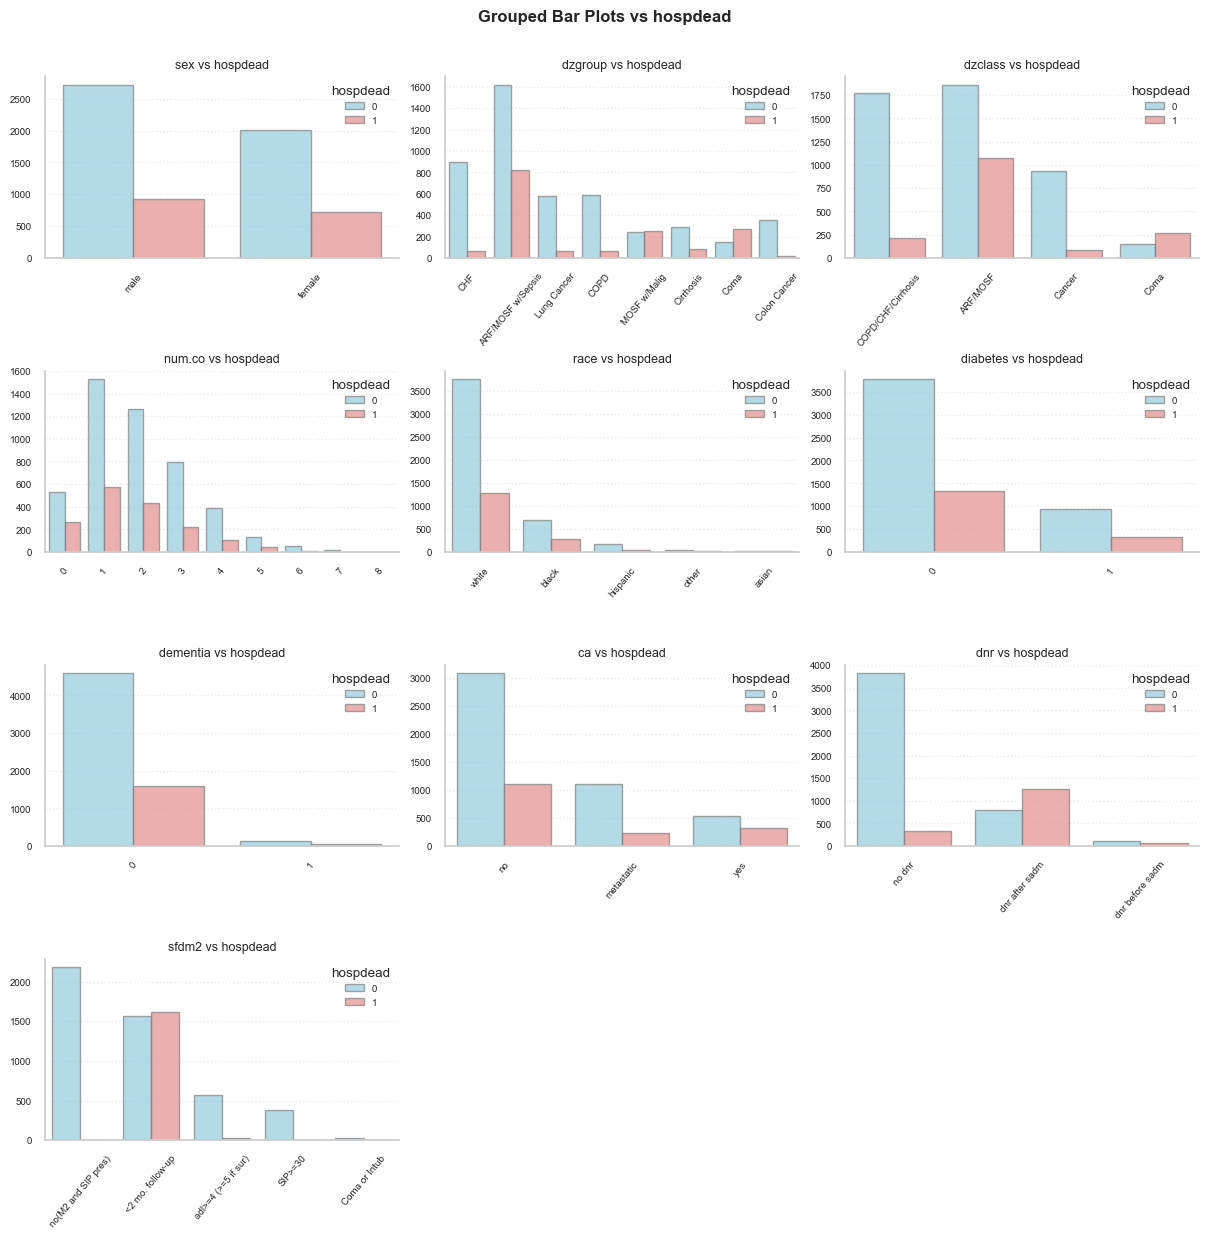

In [41]:
plot_grouped_bar_grid(train_df, x_cols=cat_feature, y_col='hospdead', n_cols=3)

### **8.1.2. Statistical Feature Selection**

- Using **Chi-square** and **Mutual Information** together helps assess both **linear and non-linear relationships** with the target.


In [42]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
X_cat_encoded = train_df[cat_feature].apply(LabelEncoder().fit_transform)
y_encoded = LabelEncoder().fit_transform(train_df['hospdead'])
chi_scores, p_values = chi2(X_cat_encoded, y_encoded)
chi2_results = pd.DataFrame({'Feature': cat_feature, 'Chi2 Score': chi_scores, 'p-value': p_values}).sort_values('Chi2 Score', ascending=False)

In [43]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_cat_encoded, y_encoded, discrete_features=True, random_state=42)
mi_results = pd.DataFrame({'Feature': cat_feature,'MI Score': mi_scores}).sort_values('MI Score', ascending=False)

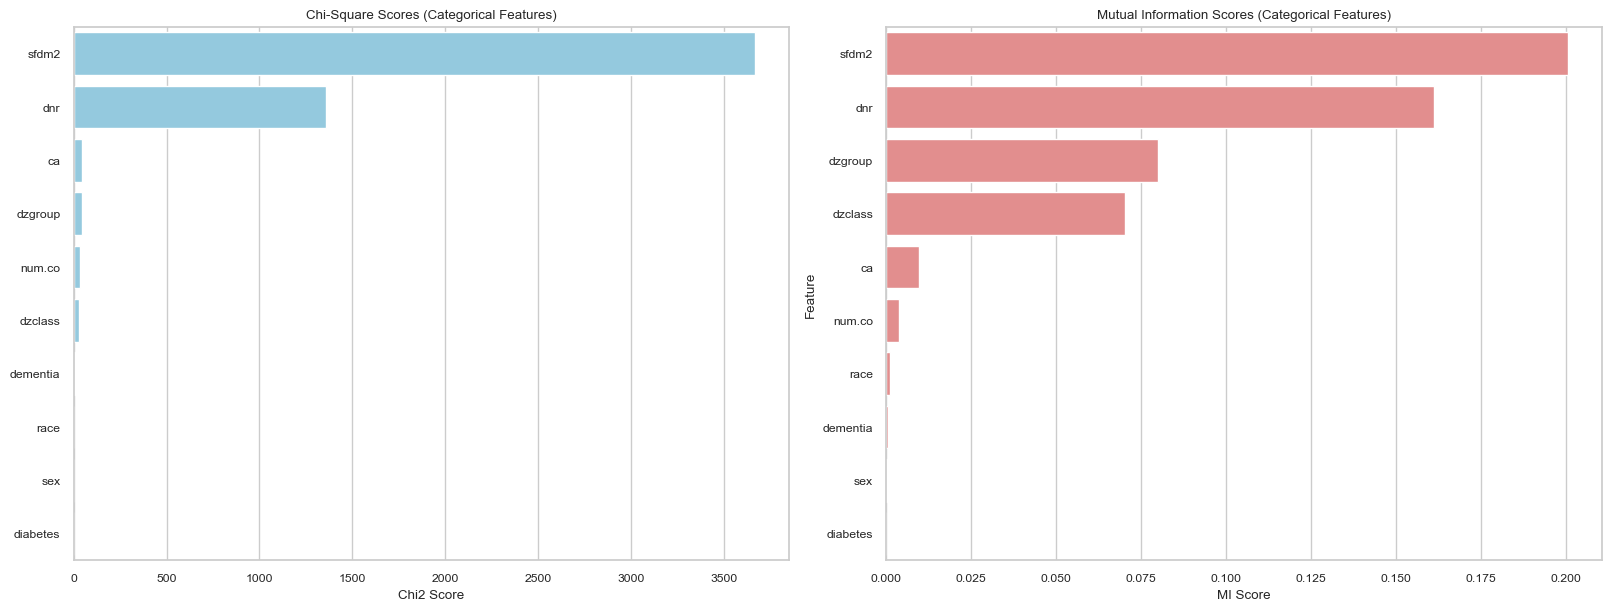

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
sns.barplot(x='Chi2 Score', y='Feature', data=chi2_results,color='skyblue', ax=axes[0])
axes[0].set_title("Chi-Square Scores (Categorical Features)")
axes[0].set_xlabel("Chi2 Score")
axes[0].set_ylabel("")
sns.barplot(x='MI Score', y='Feature', data=mi_results,color='lightcoral', ax=axes[1])
axes[1].set_title("Mutual Information Scores (Categorical Features)")
axes[1].set_xlabel("MI Score")
axes[1].set_ylabel("Feature")
plt.show()

In [45]:
s_cat_features = ['sfdm2','dnr']

**📊 Categorical Feature Selection**

**🔍 Interpretation Summary**

* **Strong Evidence of Association** → `sfdm2`, `dnr`  
  These variables show strong Chi-squared and Mutual Information evidence of linear dependence with the target.

* **Moderate/Non-linear Association** → `dzgroup`, `dzclass`  
  These display potential non-linear relationships that may emerge under deeper Mutual Information or interaction analysis.

* **Weak/No Association** → `ca`, `num.co`, `race`  
  Minimal evidence of linear dependence; potential weak non-linear effects but limited predictive value.

**📈 Statistical Summary**

| **Feature** | **Chi2** | **MI** | **Type of Relationship** | **Interpretation** |
|:--|:--|:--|:--|:--|
| `sfdm2` | High | High | Strong linear association | Functional disability scale shows consistent linear dependency with mortality outcomes. |
| `dnr` | High | Moderate | Linear and potential non-linear association | Do-Not-Resuscitate status strongly correlates with hospital death; possible complex dependence patterns. |
| `dzgroup` | Moderate | Moderate | Potential non-linear association | Disease sub-category may influence mortality in interaction with comorbidities. |
| `dzclass` | Moderate | Moderate | Potential non-linear association | Broad disease class contributes moderately through mixed disease interactions. |
| `ca` | Low | Low | Weak association | Cancer status has limited direct association with mortality when adjusted for disease class. |
| `num.co` | Low | Low | Weak association | Number of comorbidities shows minor standalone impact on hospital death. |
| `race` | Low | Low | Weak association | Race shows minimal influence on mortality after adjusting for clinical variables. |

**📥 Final Feature Selection**

| **Selected Feature** | **Reason for Inclusion** | **Type of Dependence** |
|:--|:--|:--|
| `sfdm2` | Exhibits strong linear dependence with the target variable, directly tied to patient functional capacity. | Linear association |
| `dnr` | Demonstrates strong linear and potential non-linear association; ethically and clinically significant predictor. | Linear / Non-linear association |

## **8.2. Relationship Exploration: Categorical Vs Continuous**

### **8.2.1. Visual Exploration -- Box Plots**

In [46]:
def plot_box_grid(df, x_cols, y_col='hospdead', n_cols=3):
    n_rows = ceil(len(x_cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), constrained_layout=True)
    axes = axes.flatten()
    palette = ["skyblue", "lightcoral"]

    for i, col in enumerate(x_cols):
        sns.boxplot(data=df, x=y_col, y=col, palette=palette, ax=axes[i], width=0.6, showfliers=True, boxprops={'alpha': 0.7})
        axes[i].set(title=f"{col} vs {y_col}", xlabel=y_col, ylabel=col)
        axes[i].grid(linestyle=":", alpha=0.5)

    for ax in axes[len(x_cols):]:
        ax.set_visible(False)

    fig.suptitle(f"Boxplots of Numerical Features vs {y_col}", fontsize=14)
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_30588\12334736.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y_col, y=col, palette=palette, ax=axes[i], width=0.6, showfliers=True, boxprops={'alpha': 0.7})
C:\Users\User\AppData\Local\Temp\ipykernel_30588\12334736.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y_col, y=col, palette=palette, ax=axes[i], width=0.6, showfliers=True, boxprops={'alpha': 0.7})
C:\Users\User\AppData\Local\Temp\ipykernel_30588\12334736.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(dat

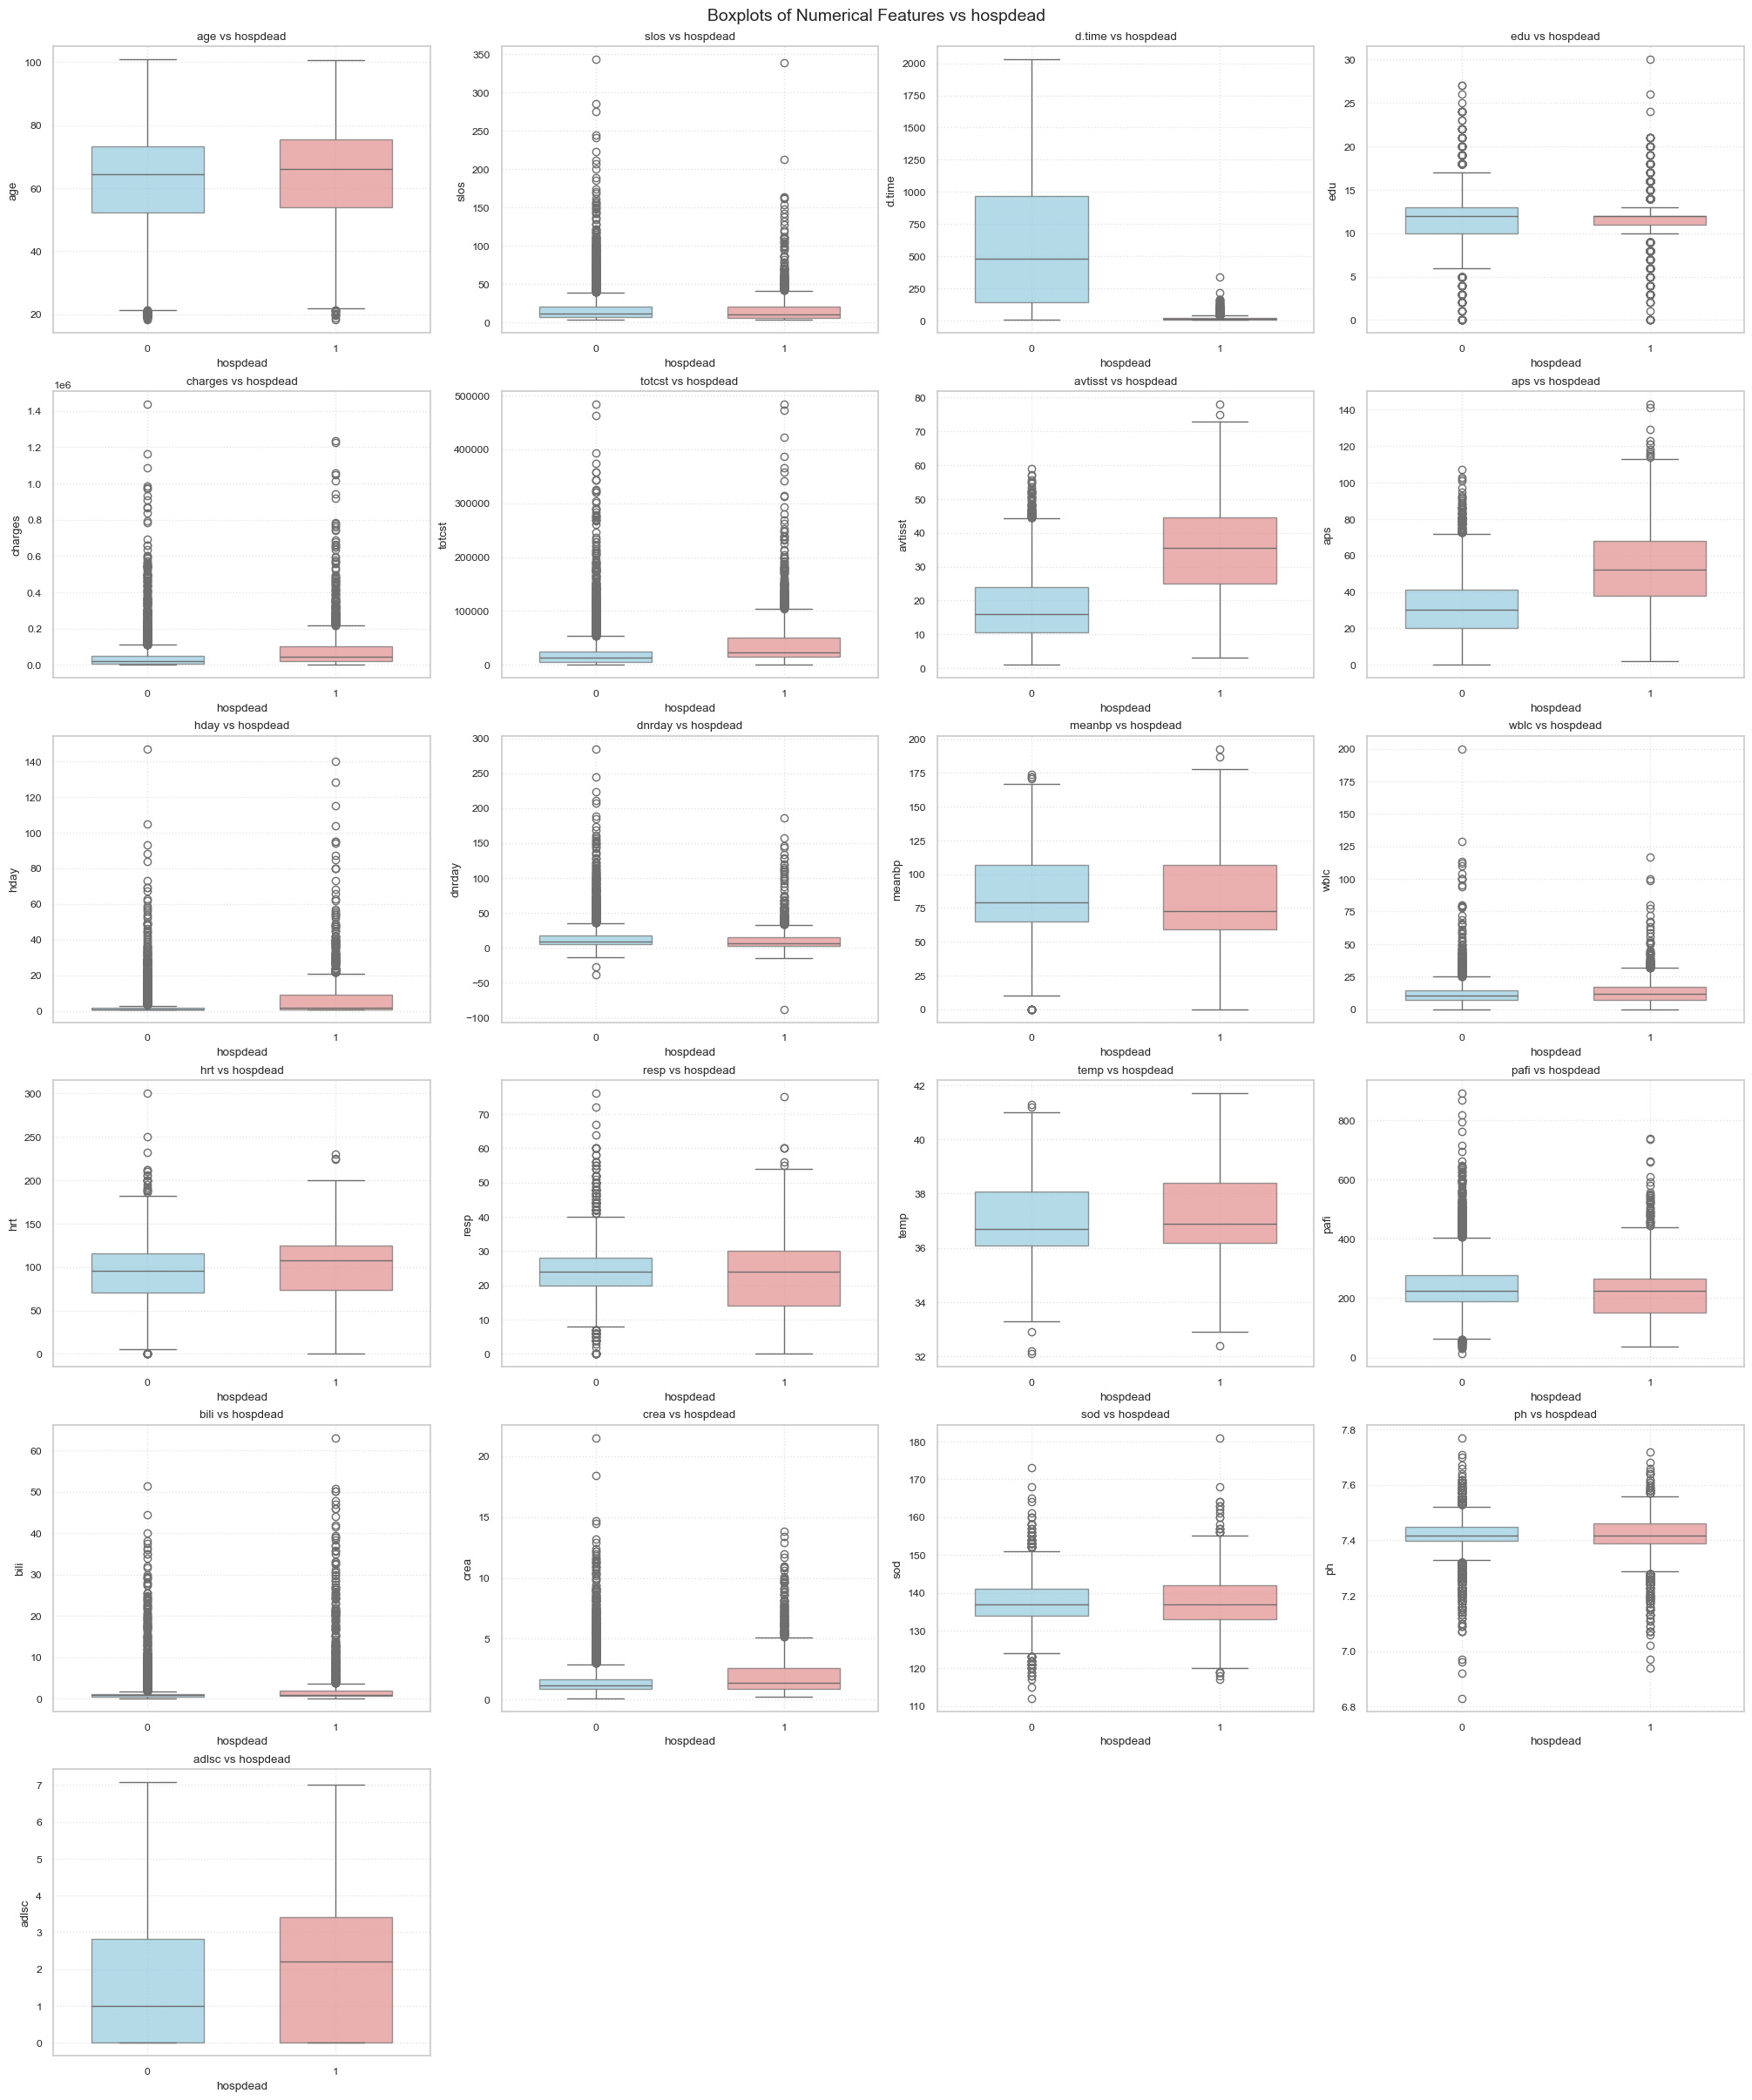

In [47]:
plot_box_grid(train_df, num_feature, y_col='hospdead', n_cols=4)

### **8.2.2. Statistical Feature Selection**

- **ANOVA :**  Applied to assess the statistical significance of categorical predictors with respect to the target variable.

In [48]:
from scipy.stats import f_oneway

anova_results = []
for col in num_feature:
    g0 = train_df[train_df['hospdead']==0][col].dropna()
    g1 = train_df[train_df['hospdead']==1][col].dropna()
    f_stat, p_val = f_oneway(g0, g1)
    anova_results.append((col, p_val))

anova_results = sorted(anova_results, key=lambda x: x[1])

print("------- ANOVA Results -------\n")
significant = []
for col, p_val in anova_results:
    if p_val < 0.05:
        print(f"{col} is significantly correlated with hospdead | P-Value: {p_val:.3e}")
        significant.append(col)
    else:
        print(f"{col} is NOT significantly correlated with hospdead | P-Value: {p_val}")
print("\nSignificant predictors:", significant)

------- ANOVA Results -------

d.time is significantly correlated with hospdead | P-Value: 0.000e+00
avtisst is significantly correlated with hospdead | P-Value: 0.000e+00
aps is significantly correlated with hospdead | P-Value: 0.000e+00
hday is significantly correlated with hospdead | P-Value: 1.497e-67
charges is significantly correlated with hospdead | P-Value: 4.826e-47
totcst is significantly correlated with hospdead | P-Value: 3.407e-45
bili is significantly correlated with hospdead | P-Value: 3.078e-33
adlsc is significantly correlated with hospdead | P-Value: 2.270e-31
crea is significantly correlated with hospdead | P-Value: 2.108e-19
hrt is significantly correlated with hospdead | P-Value: 9.220e-14
pafi is significantly correlated with hospdead | P-Value: 6.159e-12
meanbp is significantly correlated with hospdead | P-Value: 1.162e-10
temp is significantly correlated with hospdead | P-Value: 3.130e-10
wblc is significantly correlated with hospdead | P-Value: 4.093e-08
dnrday

In [49]:
sig_num_features = ['d.time', 'avtisst', 'aps',
                    'hday', 'charges', 'totcst',
                    'bili', 'adlsc', 'crea', 'hrt',
                    'meanbp', 'pafi', 'wblc', 'temp',
                    'dnrday', 'age', 'ph', 'sod', 'resp'] 

* **Mutual Information:** Features with a score above **0.03** are **retained** for further analysis.

C:\Users\User\AppData\Local\Temp\ipykernel_30588\1889529003.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mi_df, x='MI Score', y='Feature', palette='viridis')


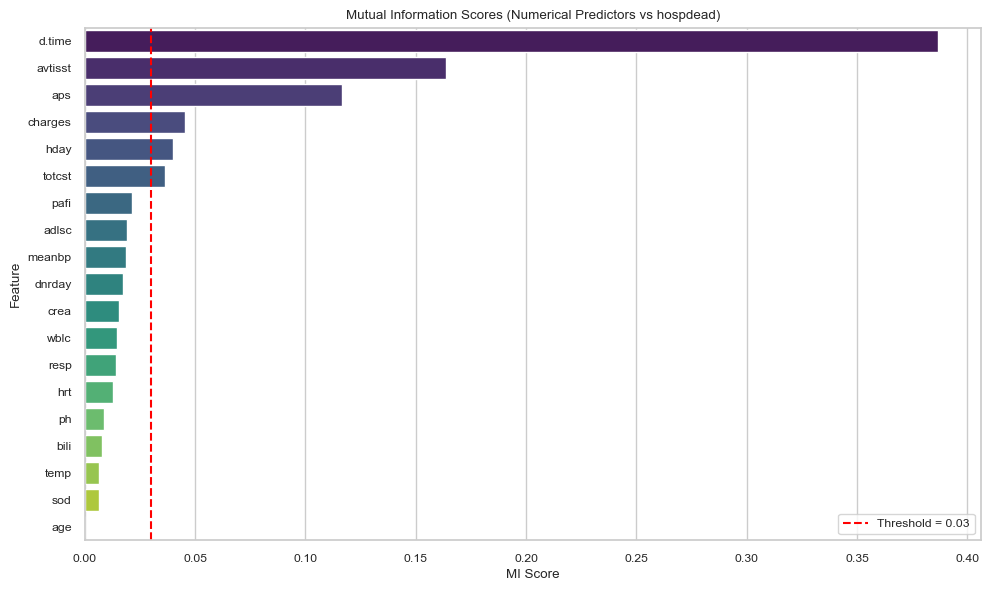

In [50]:
X, y = train_df[sig_num_features], train_df['hospdead']

mi_df = (pd.DataFrame({'Feature': X.columns,'MI Score': mutual_info_classif(X, y, random_state=42)}).sort_values('MI Score', ascending=False).reset_index(drop=True))

plt.figure(figsize=(10, 6))
sns.barplot(data=mi_df, x='MI Score', y='Feature', palette='viridis')
plt.title("Mutual Information Scores (Numerical Predictors vs hospdead)")
plt.axvline(0.03, color='red', ls='--', label='Threshold = 0.03')
plt.legend()
plt.tight_layout()
plt.show()

* **Pearson's Correlation:** Used to check **multicollinearity** between continuous features.

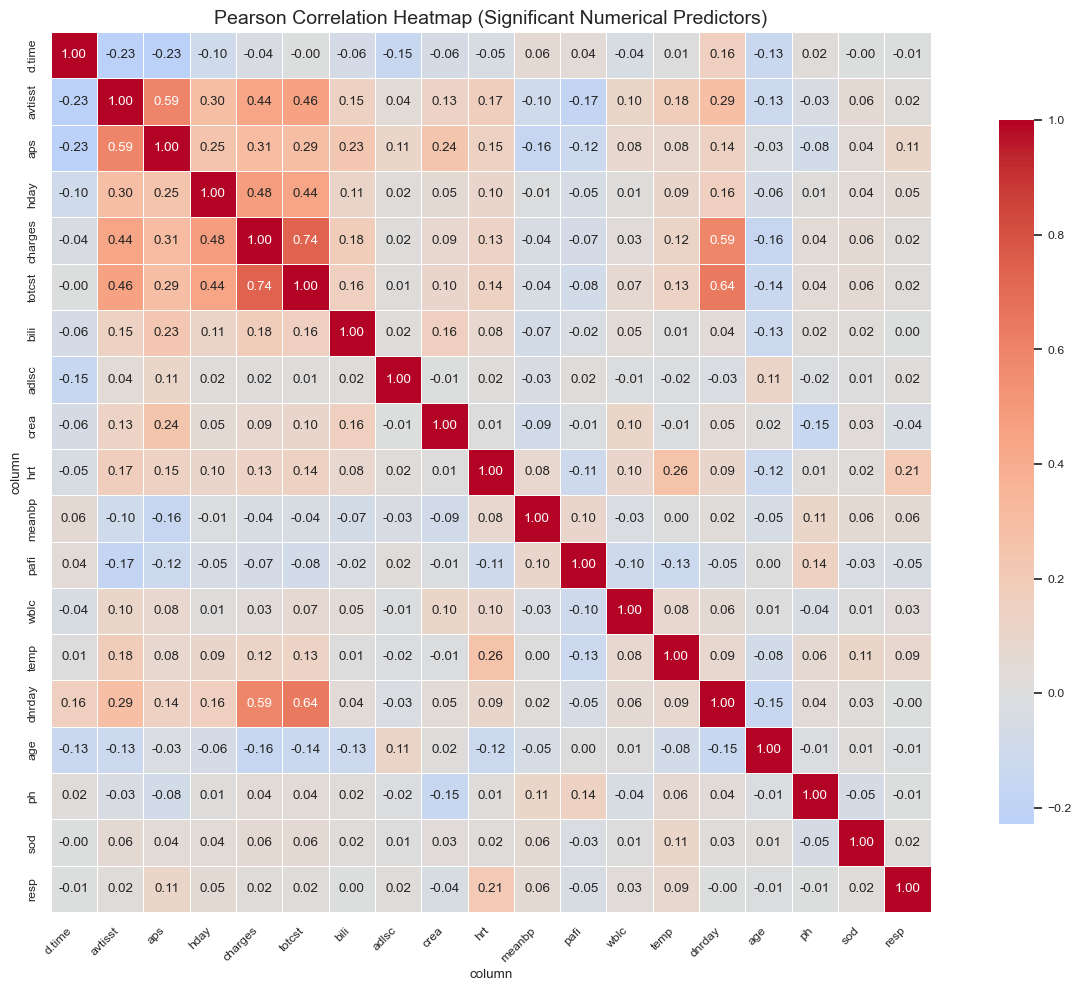

In [51]:
corr = train_df[sig_num_features].corr('pearson')

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title("Pearson Correlation Heatmap (Significant Numerical Predictors)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [52]:
s_num_features = ['d.time','avtisst','charges','hday']

**📊 Numerical Feature Selection**

- To identify continuous predictors linked to **`hospdead`**, three complementary methods were used to capture both **linear** and **non-linear** relationships while avoiding redundancy.

**1️⃣ ANOVA**
- Tested mean differences across `hospdead` groups.  
- **Significant (p < 0.05):** `d.time`, `avtisst`, `aps`, `hday`, `charges`, `totcst`, `bili`, `adlsc`, `crea`, `hrt`, `meanbp`, `pafi`, `wblc`, `temp`, `dnrday`, `age`, `ph`, `sod`, `resp`

**2️⃣ Mutual Information (MI)**
- Captured non-linear dependencies (MI ≥ 0.03).  
- **Selected:** `d.time`, `avtisst`, `aps`, `hday`, `charges`, `totcst`

**3️⃣ Pearson Correlation**
- Removed redundant variables:  
  - `avtisst` kept (correlated with `aps`)  
  - `charges` kept (`totcst` dropped as derived)

---

**📥 Final Selected Continuous Features**

| **Feature** | **Rationale** | **Type** |
|:--|:--|:--|
| `d.time` | Strong significance across ANOVA and MI; reflects follow-up duration. | Linear / Non-linear |
| `avtisst` | Captures ICU activity and resource intensity; stable independent predictor. | Linear |
| `charges` | Represents hospitalization cost; relevant economic indicator. | Linear |
| `hday` | Temporal factor with consistent mortality association. | Linear |

# **9. Selecting Final Predictors for Machine Learning Summary**
Based on the above tests, selecting the final columns for machine learning

In [53]:
SelectedColumns = s_cat_features + s_num_features
df_ml = train_df[SelectedColumns] 
print("Data Frame Shape:",df_ml.shape)
print("Selected Features:", SelectedColumns)

Data Frame Shape: (6373, 6)
Selected Features: ['sfdm2', 'dnr', 'd.time', 'avtisst', 'charges', 'hday']


# **10. Data Preprocessing for Machine Learning**

**📙Feature Summary**
| **Feature Type** | **Feature** |
|------------------|-------------|
| **Target** | hospdead |
| **Ordinary** | sfdm2 |
| **Nominal** | dnr |
| **Numerical** | d.time, avtisst, charges, hday |

## **10.1. Converting the Ordinal Variable to Numeric**

In [54]:
df_pp = train_df.copy()

In [55]:
sfdm2_mapping = {"<2 mo. follow-up": 0, "no(M2 and SIP pres)": 1, "adl>=4 (>=5 if sur)": 2, "SIP>=30": 3, "Coma or Intub": 4}
df_pp["sfdm2"] = df_pp["sfdm2"].map(sfdm2_mapping)
test_df["sfdm2"] = test_df["sfdm2"].map(sfdm2_mapping)

In [56]:
print(df_pp[["sfdm2"]].head())
print(test_df[["sfdm2"]].head())

column  sfdm2
5744        1
7976        0
2283        1
4253        0
3704        2
column  sfdm2
8629        2
1068        0
6548        3
5458        0
5317        1


## **10.2. Converting the Binary Variable to Numeric Using 1/0 Mapping**

In [57]:
binary_features = ['hospdead']
df_pp[binary_features].head()

column  hospdead
5744           0
7976           1
2283           0
4253           0
3704           0

In [58]:
for col in binary_features:
    if col in df_pp.columns:
        if df_pp[col].dtype == 'object':
            df_pp[col] = df_pp[col].map({'No': 0, 'Yes': 1, 'no': 0, 'yes': 1, '0': 0, '1': 1})
        else:
            df_pp[col] = df_pp[col].astype(int)
df_pp[binary_features].head()

column  hospdead
5744           0
7976           1
2283           0
4253           0
3704           0

In [59]:
for col in binary_features:
    if col in test_df.columns:
        if test_df[col].dtype == 'object':
            test_df[col] = test_df[col].map({'No': 0, 'Yes': 1, 'no': 0, 'yes': 1, '0': 0, '1': 1})
        else:
            test_df[col] = test_df[col].astype(int)
test_df[binary_features].head()

column  hospdead
8629           0
1068           0
6548           0
5458           0
5317           0

## **10.3. Converting the Nominal Variable to Numeric Using get_dummies()**

In [60]:
df_pp = pd.get_dummies(
    df_pp,
    columns=["dnr"],
    drop_first=False   # drop_first=True avoids dummy variable trap
)

In [61]:
df_pp.filter(regex=r'^(dnr)_').head()

dnr_dnr after sadm  dnr_dnr before sadm  dnr_no dnr
5744               False                False        True
7976                True                False       False
2283               False                False        True
4253               False                False        True
3704               False                False        True

In [62]:
test_df = pd.get_dummies(
    test_df,
    columns=["dnr"],
    drop_first=False   # drop_first=True avoids dummy variable trap
)

In [63]:
test_df.filter(regex=r'^(dnr)_').head()

dnr_dnr after sadm  dnr_dnr before sadm  dnr_no dnr
8629                True                False       False
1068               False                False        True
6548               False                False        True
5458               False                False        True
5317               False                False        True

## **10.4. Data Transformation**

### **10.4.1. Transformation on Training Data**

***-------------Fixing Skewness-------------***

In [64]:
skew_vals = df_pp[s_num_features].skew().sort_values(ascending=False)
skew_df = pd.DataFrame({'Feature': skew_vals.index, 'Skewness': skew_vals.values})

***-------------Before Fixing-------------***

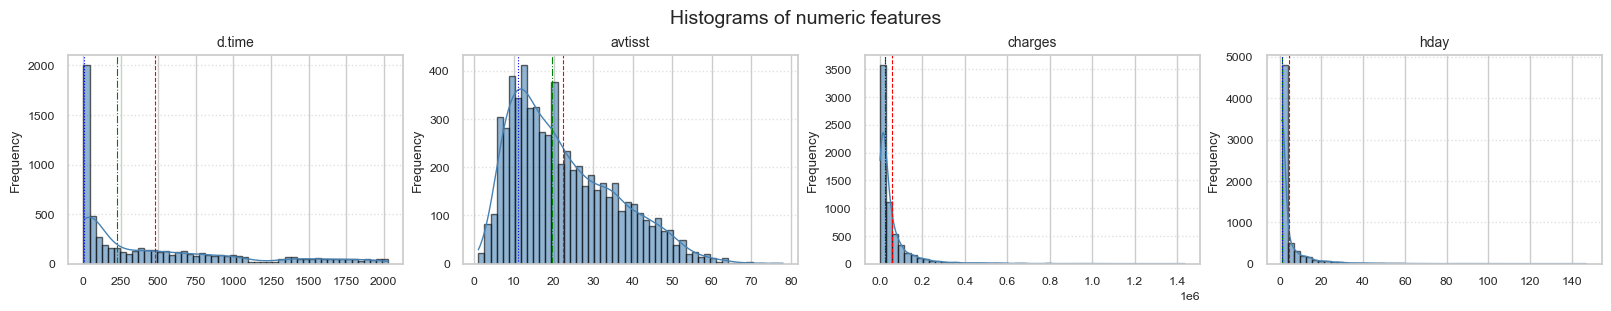

Feature  Skewness
0     hday  5.915829
1  charges  4.946725
2   d.time  1.188809
3  avtisst  0.773262

In [65]:
plot_hist_grid(df_pp, s_num_features, bins=50, n_cols=4)
display(skew_df)

In [66]:
df_skewfix = df_pp.copy()

In [67]:
for col in []:
    df_skewfix[col] = np.cbrt(df_skewfix[col].clip(lower=0))   # cube root
    
for col in [s_num_features]:
    df_skewfix[col] = np.log1p(df_skewfix[col].clip(lower=0))  # log(1+x)

df_skewfix.replace([np.inf, -np.inf], np.nan, inplace=True)

In [68]:
skew_vals = df_skewfix[s_num_features].skew().sort_values(ascending=False)
skew_df = pd.DataFrame({'Feature': skew_vals.index, 'Skewness': skew_vals.values})

***-------------After Fixing-------------***

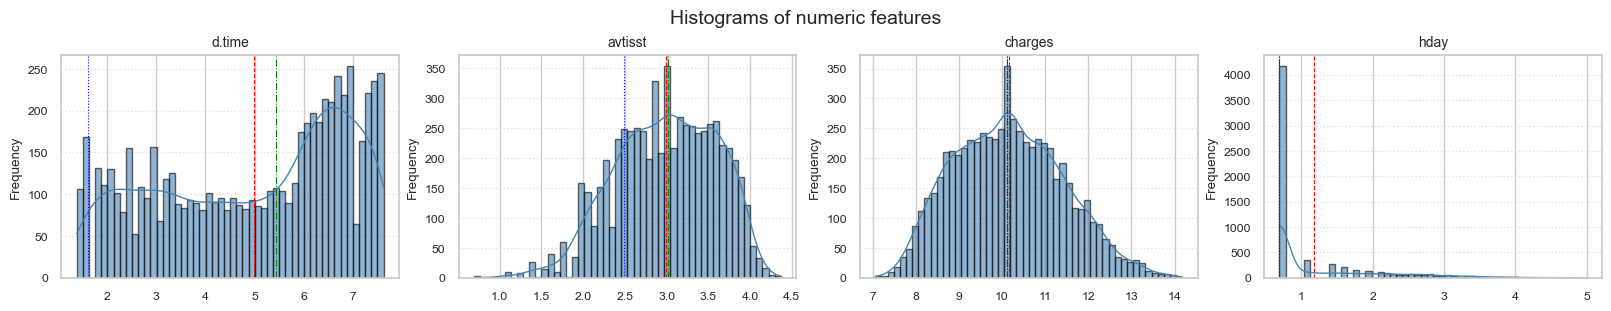

Feature  Skewness
0     hday  1.681466
1  charges  0.237855
2  avtisst -0.308624
3   d.time -0.357348

In [69]:
plot_hist_grid(df_skewfix, s_num_features, bins=50, n_cols=4)
df_skewfix[s_num_features].isnull().sum()
display(skew_df)

In [70]:
df_pp[s_num_features] = df_skewfix[s_num_features]

***-------------Standardization-------------***

In [71]:
df_std = df_pp[s_num_features].copy()

In [72]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_std[s_num_features] = scaler.fit_transform(df_std[s_num_features])
print(df_std.head())
print(df_std.shape)

        d.time   avtisst   charges      hday
5744  0.519337 -0.168616 -0.575838 -0.594816
7976 -1.600359  0.089136 -1.238214 -0.594816
2283  1.203285  0.424672  0.600328  0.949332
4253 -0.655642 -1.524554 -1.122641 -0.594816
3704 -0.242210 -1.871744 -0.164514 -0.594816
(6373, 4)


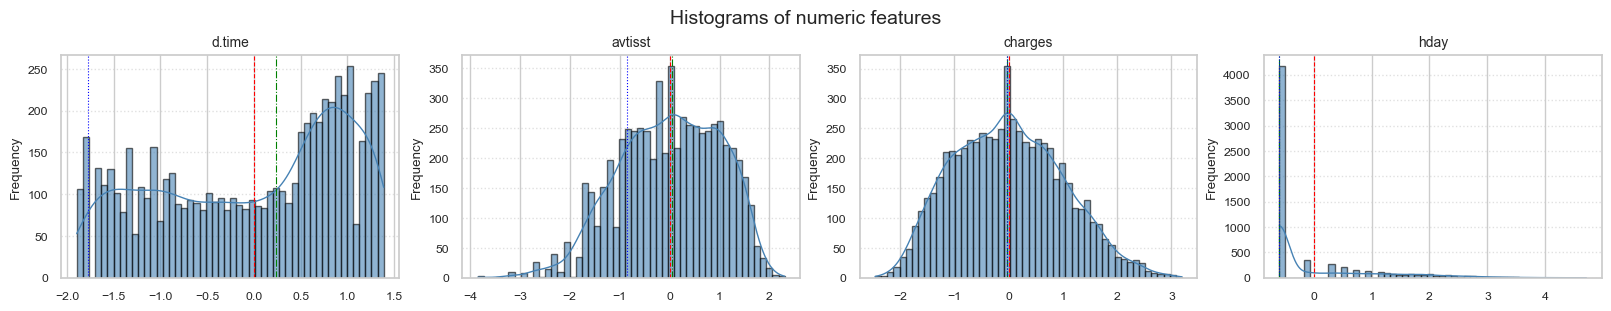

d.time     0
avtisst    0
charges    0
hday       0
dtype: int64

In [73]:
plot_hist_grid(df_std, s_num_features, bins=50, n_cols=4)
df_std[s_num_features].isnull().sum()

### **10.4.2. Transformation on Testing Data**

***-------------Fixing Skewness-------------***

In [74]:
skew_vals = test_df[s_num_features].skew().sort_values(ascending=False)
skew_df = pd.DataFrame({'Feature': skew_vals.index, 'Skewness': skew_vals.values})

***-------------Before Fixing-------------***

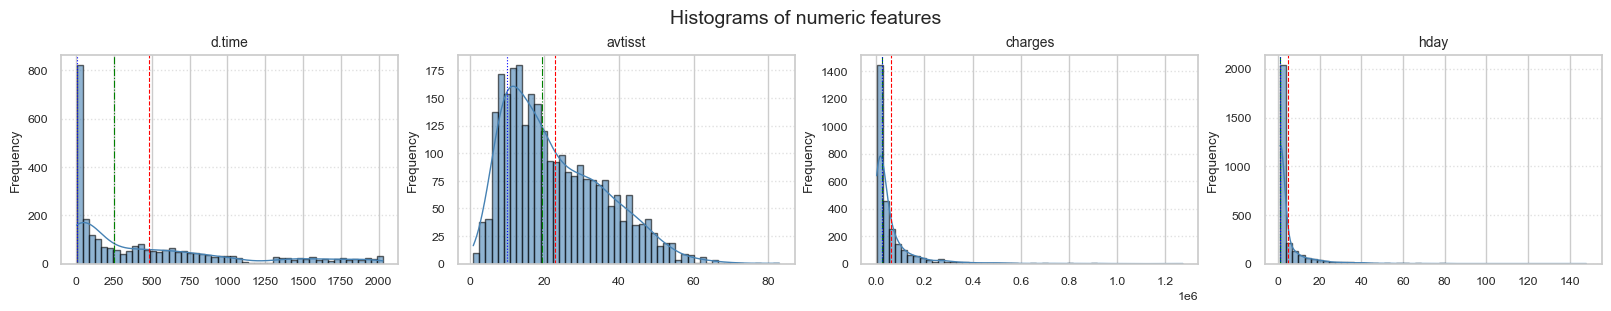

Feature  Skewness
0     hday  5.704039
1  charges  4.278185
2   d.time  1.223772
3  avtisst  0.780214

In [75]:
plot_hist_grid(test_df,s_num_features, bins=50, n_cols=4)
display(skew_df)

In [76]:
dft_skewfix = test_df.copy()

In [77]:
for col in []:
    dft_skewfix[col] = np.cbrt(dft_skewfix[col].clip(lower=0))   # cube root

for col in s_num_features:
    dft_skewfix[col] = np.log1p(dft_skewfix[col].clip(lower=0))  # log(1+x)
dft_skewfix.replace([np.inf, -np.inf], np.nan, inplace=True)

In [78]:
skew_vals = dft_skewfix[s_num_features].skew().sort_values(ascending=False)
skew_dft = pd.DataFrame({'Feature': skew_vals.index,'Skewness': skew_vals.values})

***-------------After Fixing-------------***

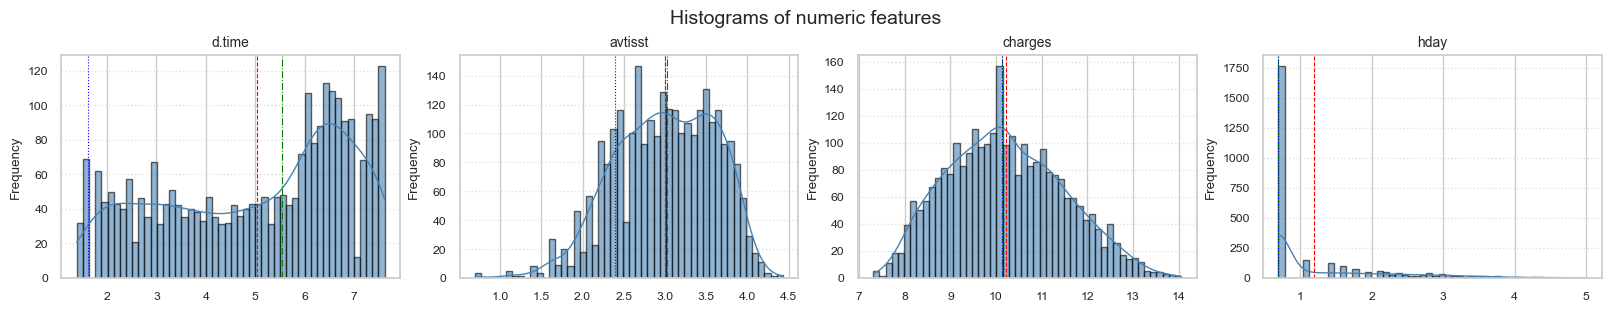

Feature  Skewness
0     hday  1.653056
1  charges  0.246703
2  avtisst -0.324057
3   d.time -0.406196

In [79]:
plot_hist_grid(dft_skewfix, s_num_features, bins=50, n_cols=4)
dft_skewfix[s_num_features].isnull().sum()
display(skew_dft)

In [80]:
test_df[s_num_features] = dft_skewfix[s_num_features]

***-------------Standardization-------------***

In [81]:
dft_std = test_df[s_num_features].copy()

In [82]:
dft_std[s_num_features] = scaler.fit_transform(dft_std[s_num_features])
print(dft_std.head())
print(dft_std.shape)

        d.time   avtisst   charges      hday
8629 -0.181390 -1.007253 -0.923047 -0.602659
1068  0.923409  0.426936  0.761957 -0.602659
6548 -0.096128  0.609000 -0.322662 -0.602659
5458 -0.779106 -0.453497 -0.211336 -0.602659
5317  0.711043 -1.609161 -0.691705 -0.602659
(2732, 4)


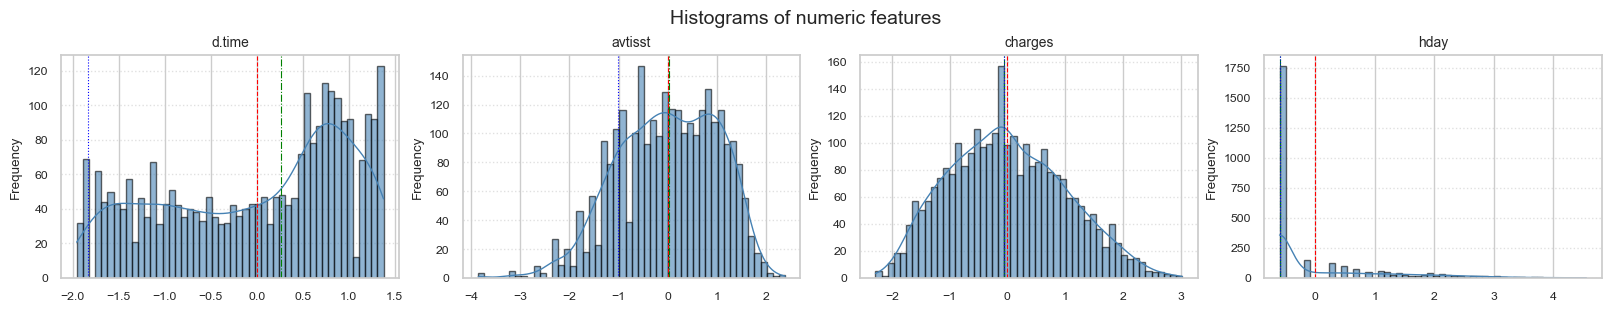

d.time     0
avtisst    0
charges    0
hday       0
dtype: int64

In [83]:
plot_hist_grid(dft_std, s_num_features, bins=50, n_cols=4)
dft_std[s_num_features].isnull().sum()

In [84]:
test_df[s_num_features] = dft_std[s_num_features]

# **11. Model Construction: Model 1 - Without Outlier Treatment**

In [85]:
import re

target = ['hospdead']
dummy_cols = [c for c in df_pp.columns if re.match(r'^(dnr)_', c)]
all_predictors_1 = s_num_features + dummy_cols + ['sfdm2']
X_train, y_train = df_pp[all_predictors_1].values, df_pp[target].values
X_test,  y_test  = test_df[all_predictors_1].values, test_df[target].values

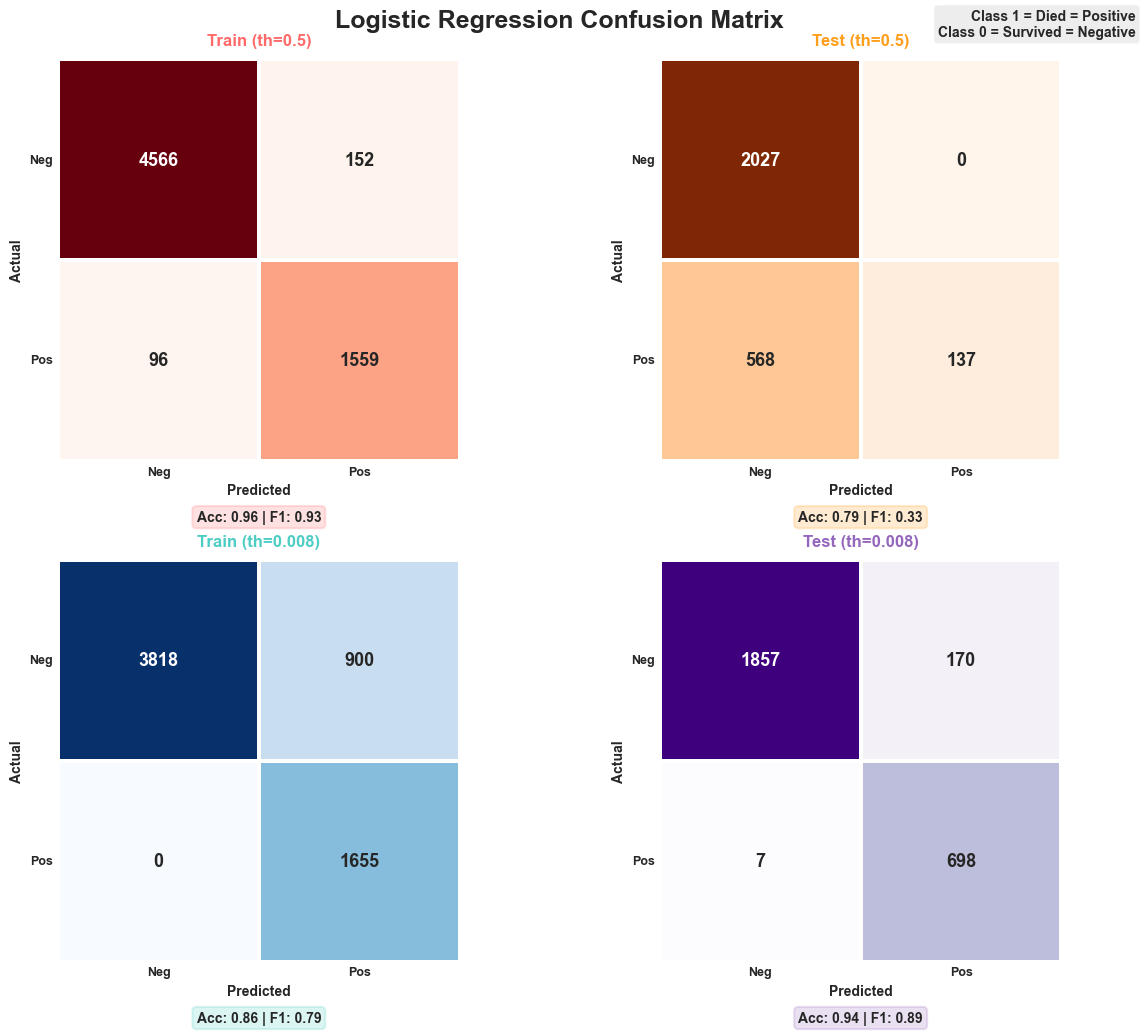

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ==================== ADJUSTABLE PARAMETERS ====================
THRESHOLD_1 = 0.5  # First threshold
THRESHOLD_2 = 0.008  # Second threshold
FIGSIZE = (12, 10)
# ========================================================

# Train model
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train.ravel())
y_train_prob = log_reg.predict_proba(X_train)[:, 1]
y_test_prob = log_reg.predict_proba(X_test)[:, 1]

# Calculate ROC & AUC
fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_prob)
fpr_te, tpr_te, _ = roc_curve(y_test, y_test_prob)
auc_tr, auc_te = auc(fpr_tr, tpr_tr), auc(fpr_te, tpr_te)

# Helper functions
def predict(th):
    return (y_train_prob >= th).astype(int), (y_test_prob >= th).astype(int)

def plot_cm(ax, y_true, y_pred, title, cmap, color):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc, f1 = (tp+tn)/cm.sum(), 2*tp/(2*tp+fp+fn+1e-6)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, ax=ax, square=True,
                annot_kws={'fontsize':13,'weight':'bold'}, linewidths=1.5, linecolor='w')
    ax.set_title(title, fontsize=12, color=color, weight='bold', pad=10)
    ax.set_xlabel("Predicted", fontsize=10, weight='bold')
    ax.set_ylabel("Actual", fontsize=10, weight='bold')
    ax.set_xticklabels(['Neg', 'Pos'], fontsize=9, weight='bold')
    ax.set_yticklabels(['Neg', 'Pos'], fontsize=9, rotation=0, weight='bold')
    ax.text(0.5, -0.15, f"Acc: {acc:.2f} | F1: {f1:.2f}", ha='center', transform=ax.transAxes,
            fontsize=10, weight='bold', bbox=dict(boxstyle='round', facecolor=color, alpha=0.2, edgecolor=color, linewidth=1.5))

# Plot
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(2, 2, figsize=FIGSIZE, constrained_layout=True)
ax = ax.flatten()
fig.suptitle("Logistic Regression Confusion Matrix", fontsize=18, weight='bold', y=1.02)
fig.text(0.98, 1.02, "Class 1 = Died = Positive\nClass 0 = Survived = Negative", 
         ha='right', va='top', fontsize=10, weight='bold', 
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.4))

# Plot confusion matrices
configs = [
    (0, y_train, predict(THRESHOLD_1)[0], f"Train (th={THRESHOLD_1})", "Reds", "#FF6B6B"),
    (1, y_test, predict(THRESHOLD_1)[1], f"Test (th={THRESHOLD_1})", "Oranges", "#FF9F1C"),
    (2, y_train, predict(THRESHOLD_2)[0], f"Train (th={THRESHOLD_2})", "Blues", "#4ECDC4"),
    (3, y_test, predict(THRESHOLD_2)[1], f"Test (th={THRESHOLD_2})", "Purples", "#9467bd")
]

for i, y, yhat, title, cmap, color in configs:
    plot_cm(ax[i], y, yhat, title, cmap, color)

plt.show()

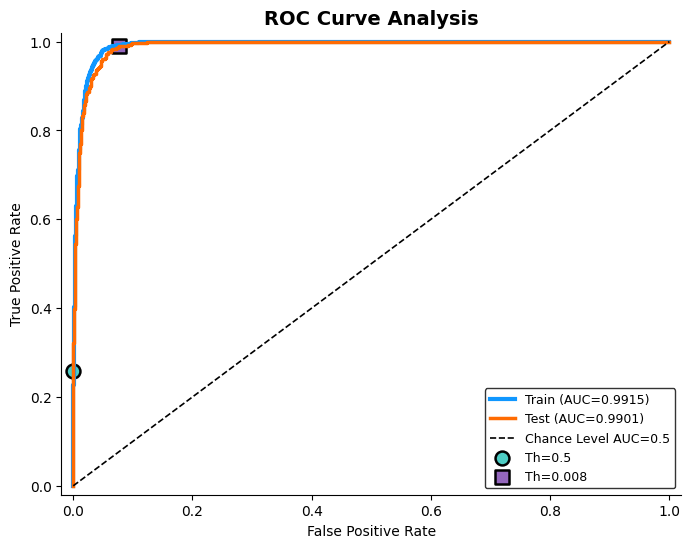


ROC Analysis Summary:
Train AUC: 0.9915
Test AUC: 0.9901
AUC Diff: 0.0014


In [87]:
# === ROC Curve Visualization ===
plt.style.use('default')  # ensures white background
plt.figure(figsize=(8, 6))
plt.plot(fpr_tr, tpr_tr, lw=3, color="#1097FF", label=f"Train (AUC={auc_tr:.4f})")
plt.plot(fpr_te, tpr_te, lw=2.5, color="#FF6B02", label=f"Test (AUC={auc_te:.4f})")
plt.plot([0, 1], [0, 1], '--', color='black', lw=1.2, label='Chance Level AUC=0.5')

# Mark thresholds
_, _, thr_te = roc_curve(y_test, y_test_prob)
for th, color, marker in zip([THRESHOLD_1, THRESHOLD_2], ["#4ECDC4", "#9467bd"], ['o', 's']):
    idx = np.argmin(np.abs(thr_te - th))
    plt.scatter(fpr_te[idx], tpr_te[idx], s=100, c=color, edgecolor='black', marker=marker, lw=1.8, label=f'Th={th}')

plt.title("ROC Curve Analysis", fontsize=14, weight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend(loc='lower right', frameon=True, fancybox=True, edgecolor='black', fontsize=9)
sns.despine()
plt.show()

print(f"\nROC Analysis Summary:\nTrain AUC: {auc_tr:.4f}\nTest AUC: {auc_te:.4f}\nAUC Diff: {abs(auc_tr - auc_te):.4f}")

In [88]:
# --- Metric Function ---
def calc_metrics(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    div = lambda a, b: a / b if b else 0
    return {
        'Accuracy': (TP + TN) / (TP + TN + FP + FN),
        'Specificity': div(TN, TN + FP),
        'Precision': div(TP, TP + FP),
        'Sensitivity': div(TP, TP + FN)
    }

# --- Predictions ---
y_train_prob, y_test_prob = log_reg.predict_proba(X_train)[:, 1], log_reg.predict_proba(X_test)[:, 1]
predict_at = lambda th: ((y_train_prob >= th).astype(int), (y_test_prob >= th).astype(int))
preds = {THRESHOLD_1: predict_at(THRESHOLD_1), THRESHOLD_2: predict_at(THRESHOLD_2)}

# --- Summary ---
print("\n" + "="*65)
print(" Logistic Regression Performance Summary ".center(65))
print("="*65)

for th, (ytr, yte) in preds.items():
    tr, te = calc_metrics(y_train, ytr), calc_metrics(y_test, yte)
    df = pd.DataFrame({'Metric': tr.keys(),
                       'Train (%)': [f"{v*100:.2f}" for v in tr.values()],
                       'Test (%)': [f"{v*100:.2f}" for v in te.values()]})
    print(f"\nThreshold = {th:.2f}\n" + df.to_string(index=False) + "\n" + "-"*65)

print("="*65 + "\n")


             Logistic Regression Performance Summary             

Threshold = 0.50
     Metric Train (%) Test (%)
   Accuracy     96.11    79.21
Specificity     96.78   100.00
  Precision     91.12   100.00
Sensitivity     94.20    19.43
-----------------------------------------------------------------

Threshold = 0.01
     Metric Train (%) Test (%)
   Accuracy     85.88    93.52
Specificity     80.92    91.61
  Precision     64.77    80.41
Sensitivity    100.00    99.01
-----------------------------------------------------------------



In [89]:
coef_df = pd.Series(log_reg.coef_[0], index=all_predictors_1).abs().sort_values(ascending=False).to_frame('Magnitude')

print("\n" + "="*45)
print("  Logistic Regression Coefficients")
print("="*45)
print("\nTop Features by Importance:\n")
print(coef_df.to_string())
print(f"\nIntercept (Bias): {log_reg.intercept_[0]:.4f}")
print("="*45 + "\n")


  Logistic Regression Coefficients

Top Features by Importance:

                     Magnitude
d.time                3.029966
dnr_no dnr            2.376045
dnr_dnr before sadm   1.847045
charges               1.351172
dnr_dnr after sadm    1.066500
avtisst               0.948162
sfdm2                 0.327526
hday                  0.234849

Intercept (Bias): -5.2896



---

## **11.1. Model Development: Evaluating Prediction Robustness**

- The aim is to determine whether the extreme prediction errors observed in **Model 1** (⚠️ potential outliers) distort the model’s underlying structure. Ensuring **robustness** means verifying that performance remains stable even under atypical or noisy data conditions.

- For **Model 2**, we will either **🧹 remove outliers** or apply a **🤖 model architecture robust to outliers**, then compare its performance with **Model 1** to evaluate improvements in predictive stability and overall reliability.

# **12. Defining the Problem Statement for Model 2**
Now, we aim to build a machine learning model that can predict the **hospdead** (in-hospital death) of **normal hospitalized patients**.

**📌Note:**  Here, **"normal patients"** refers to those whose records do **not contain extreme outlier values**. Outliers are excluded, since they can distort model training and reduce prediction accuracy. These outliers were identified and cut using statistical methods

- **Target Variable:** `hospdead`  
- **Predictors:** `age`, `sex`, `d.time`, `meanbp`, `adlp`, `wblc`, etc.  
- **Samples:** Medical records of **9,105 hospitalized patients** from five U.S. states, spanning **1989–1991** and **1992–1994**.

---

**📜 Determining the Type of Machine Learning**

- The target variable (`hospdead`) is binary; hence, this is a **Supervised Binary Classification** problem.

---

**🔑 Model Assumptions**

| **Algorithm** | **Assumptions** |
| :--- | :--- |
| **Logistic Regression (LogReg)** | 1. **Linearity** The relationship should be linear.<br>2. **Multicollinearity** Each feature must contribute unique information.<br>3. **Normality of Residuals** normal distribution with mean = 0.<br>4. **No Influential Outliers** Outliers should not dominate or distort.<br>5. **No Autocorrelation** Residuals should be independent.<br>6. **Homoscedasticity** Residuals should have constant variance across all predicted values. |

In [90]:
df = pd.read_pickle('support2_raw.pkl')

In [91]:
leak_col_num = ['id', 'sps', 'surv2m', 'surv6m', 'prg2m', 'prg6m']
leak_col_cat = ['scoma', 'death']
df = df.drop(columns=leak_col_num + leak_col_cat)
print(df.shape)

(9105, 40)


In [92]:
df_outlier = df.copy()
df_outlier.shape

(9105, 40)

In [93]:
def classify_features(df):
    cat_feature = [col for col in df.columns if df[col].nunique(dropna=True) < 20]
    num_feature = [col for col in df.columns if df[col].nunique(dropna=True) >= 20]
    feature_types = {col: ('Categorical' if col in cat_feature else 'Numerical') for col in df.columns}
    counts = {"Categorical": len(cat_feature), "Numerical": len(num_feature)}
    return feature_types, cat_feature, num_feature, counts

feature_types, cat_feature, num_feature, counts = classify_features(df)
print(f"Categorical Features ({len(cat_feature)}): {cat_feature}")
print(f"Numerical Features ({len(num_feature)}): {num_feature}")
print(f"Counts: {counts}")


Categorical Features (14): ['sex', 'hospdead', 'dzgroup', 'dzclass', 'num.co', 'income', 'race', 'diabetes', 'dementia', 'ca', 'dnr', 'adlp', 'adls', 'sfdm2']
Numerical Features (26): ['age', 'slos', 'd.time', 'edu', 'charges', 'totcst', 'totmcst', 'avtisst', 'aps', 'hday', 'dnrday', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun', 'urine', 'adlsc']
Counts: {'Categorical': 14, 'Numerical': 26}


## **12.1. Outlier Treatment**

In [94]:
# Continuous variables and categorical variables for outlier detection
num_var_ol, cat_var_ol = num_feature, cat_feature

In [95]:
def remove_outliers_iqr(df_outlier, cols, whisker=1.5):
    mask = np.all([
        (df_outlier[col] >= df_outlier[col].quantile(0.25) - whisker * (df_outlier[col].quantile(0.75) - df_outlier[col].quantile(0.25))) &
        (df_outlier[col] <= df_outlier[col].quantile(0.75) + whisker * (df_outlier[col].quantile(0.75) - df_outlier[col].quantile(0.25)))
        for col in cols
    ], axis=0)
    return df_outlier.loc[mask].copy()

In [96]:
def remove_outliers_zscore(df_outlier, cols, z_max=3.0):
    mask = np.ones(len(df_outlier), dtype=bool)
    for col in cols:
        mu = df_outlier[col].mean()
        sd = df_outlier[col].std(ddof=0)
        z = (df_outlier[col] - mu) / (sd if sd > 0 else 1e-8)
        mask &= (z.abs() <= z_max)
    return df_outlier.loc[mask].copy()


In [97]:
def remove_rare_categorical(df_outlier, cols, min_percent=0.01):
    n = len(df_outlier)
    for col in cols:
        freqs = df_outlier[col].value_counts(normalize=True)
        rare_cats = freqs[freqs < min_percent].index
        df_outlier = df_outlier[~df_outlier[col].isin(rare_cats)]

    return df_outlier

In [98]:
# Remove outliers using IQR
df_outlier = remove_outliers_iqr(df_outlier, num_feature, whisker=1.5)
print("Shape after IQR removal:", df_outlier.shape)

# Remove outliers using Z-score
df_outlier = remove_outliers_zscore(df_outlier, num_feature, z_max=3.0)
print("Shape after Z-score removal:", df_outlier.shape)

# Remove rare categories in categorical variables
df_cat_clean = remove_rare_categorical(df_outlier, cat_feature, min_percent=0.01)
print("Shape after Rare categories removal:", df_outlier.shape)

Shape after IQR removal: (541, 40)
Shape after Z-score removal: (456, 40)
Shape after Rare categories removal: (456, 40)


**📗Conclusion**

- **Continuous outliers removal:** using both the **IQR method** and the **Z-score method** (tested separately).  
- **Categorical outliers removal:** we **removed rows containing rare categories**.

## **12.2. Missing Value Treatment**

### **12.2.1. Missing Values Treatment for Continuous Features**

#### **12.2.1.1. Removing the Missing Values**

In [99]:
df_clean_2 = df_outlier.copy()
df_clean_2.shape

(456, 40)

In [100]:
num_feature = [col for col in num_var_ol if col not in leak_col_num]
cat_feature = [col for col in cat_var_ol if col not in leak_col_cat]

In [101]:
missing = df_clean_2[num_feature].isnull().sum()
missing_percent = (missing / len(df_clean_2)) * 100
missing_table = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent.round(2)})
print(missing_table.sort_values(by="Percentage", ascending=False))
missing_table = missing_table[missing_table['Missing Values'] > 0]
print(f"Numerical Features ({len(num_feature)}): {num_feature}")

         Missing Values  Percentage
age                   0         0.0
slos                  0         0.0
d.time                0         0.0
edu                   0         0.0
charges               0         0.0
totcst                0         0.0
totmcst               0         0.0
avtisst               0         0.0
aps                   0         0.0
hday                  0         0.0
dnrday                0         0.0
meanbp                0         0.0
wblc                  0         0.0
hrt                   0         0.0
resp                  0         0.0
temp                  0         0.0
pafi                  0         0.0
alb                   0         0.0
bili                  0         0.0
crea                  0         0.0
sod                   0         0.0
ph                    0         0.0
glucose               0         0.0
bun                   0         0.0
urine                 0         0.0
adlsc                 0         0.0
Numerical Features (26): ['a

**📗Conclusion**
- Following the outlier treatment, all **continuous variables** now contain **no missing values.**
- There are no **remaining missing values** in the continuous variables.

### **12.2.2. Missing Values Treatment for Categorical Features**

#### **12.2.2.1. Removing the Missing Values**

In [102]:
missing = df_clean_2[cat_feature].isnull().sum()
missing_percent = (missing / len(df_clean_2)) * 100
missing_table = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent.round(2)})
print(missing_table.sort_values(by="Percentage", ascending=False))
missing_table = missing_table[missing_table['Missing Values'] > 0]

          Missing Values  Percentage
adlp                 190       41.67
adls                 101       22.15
income                93       20.39
sfdm2                 44        9.65
hospdead               0        0.00
sex                    0        0.00
num.co                 0        0.00
dzclass                0        0.00
dzgroup                0        0.00
race                   0        0.00
ca                     0        0.00
dementia               0        0.00
diabetes               0        0.00
dnr                    0        0.00


In [103]:
# features to drop if more than 30% missing
to_drop_cat = missing_table[missing_table['Percentage'] > 30].index.tolist()

# drop them from df_clean
df_clean_2 = df_clean_2.drop(columns=to_drop_cat)

cat_feature = [col for col in cat_feature if col not in to_drop_cat]
print("Dropped categorical features:", to_drop_cat)
print("New shape:", df_clean_2.shape)

Dropped categorical features: ['adlp']
New shape: (456, 39)


#### **12.2.2.2. Filling the Missing Values**

- Impute the missing values with **MODE** value for categorical variables

In [104]:
mode_features = ['sfdm2','income','adls']
mode_dict = {col: df_clean_2[col].mode()[0] for col in mode_features}
df_clean_2[mode_features] = df_clean_2[mode_features].fillna(mode_dict)

In [105]:
num_missing_cols = (df_clean_2.isnull().sum() > 0).sum()
print("Number of features with missing values:", num_missing_cols)
print("New shape:", df_clean_2.shape)

Number of features with missing values: 0
New shape: (456, 39)


In [106]:
missing = df_clean_2[cat_feature].isnull().sum()
missing_percent = (missing / len(df_clean_2)) * 100
missing_table = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent.round(2)})
print(missing_table.sort_values(by="Percentage", ascending=False))
missing_table = missing_table[missing_table['Missing Values'] > 0]

          Missing Values  Percentage
sex                    0         0.0
hospdead               0         0.0
dzgroup                0         0.0
dzclass                0         0.0
num.co                 0         0.0
income                 0         0.0
race                   0         0.0
diabetes               0         0.0
dementia               0         0.0
ca                     0         0.0
dnr                    0         0.0
adls                   0         0.0
sfdm2                  0         0.0


**📗Conclusion**
- No missing values left in categorical features

### **12.2.3. Visualization of Histograms and Boxplots After Missing Value Treatment**

**📌Note:** Histograms and boxplots confirm that imputation preserved each feature’s distribution, spread, and outliers without distortion.

- ***Continuous Features***

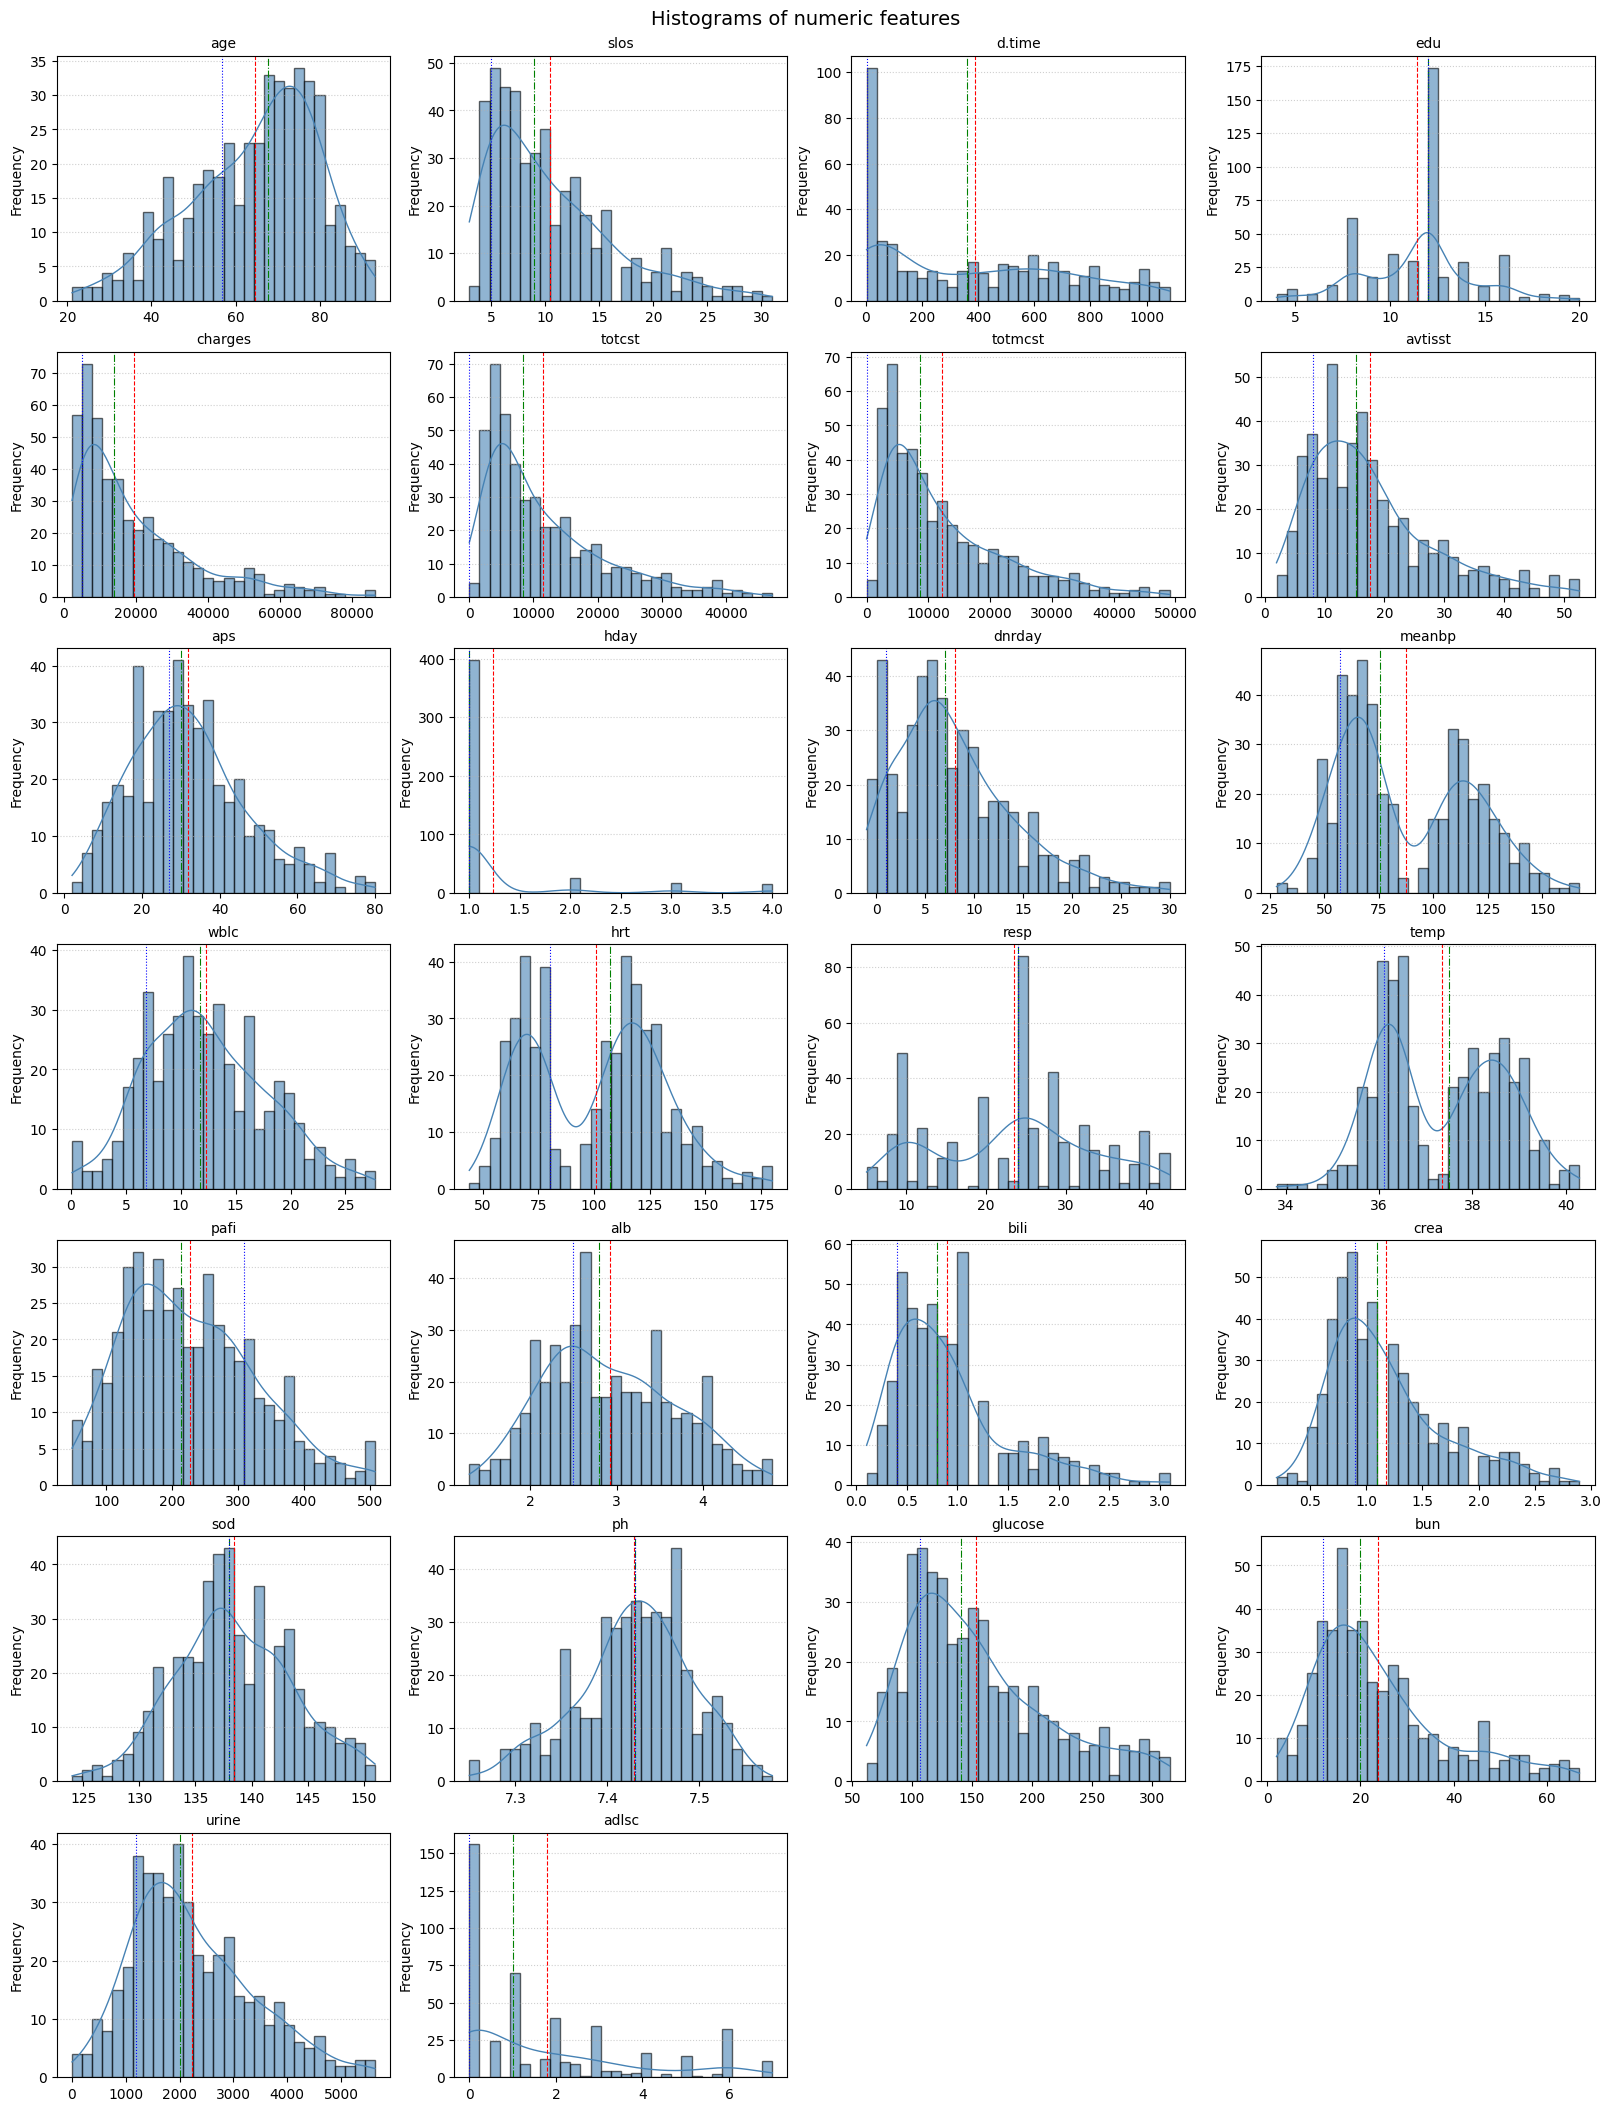

In [107]:
plot_hist_grid(df_clean_2, num_feature, bins=30, n_cols=4)

C:\Users\User\AppData\Local\Temp\ipykernel_30588\12334736.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y_col, y=col, palette=palette, ax=axes[i], width=0.6, showfliers=True, boxprops={'alpha': 0.7})
C:\Users\User\AppData\Local\Temp\ipykernel_30588\12334736.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y_col, y=col, palette=palette, ax=axes[i], width=0.6, showfliers=True, boxprops={'alpha': 0.7})
C:\Users\User\AppData\Local\Temp\ipykernel_30588\12334736.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(dat

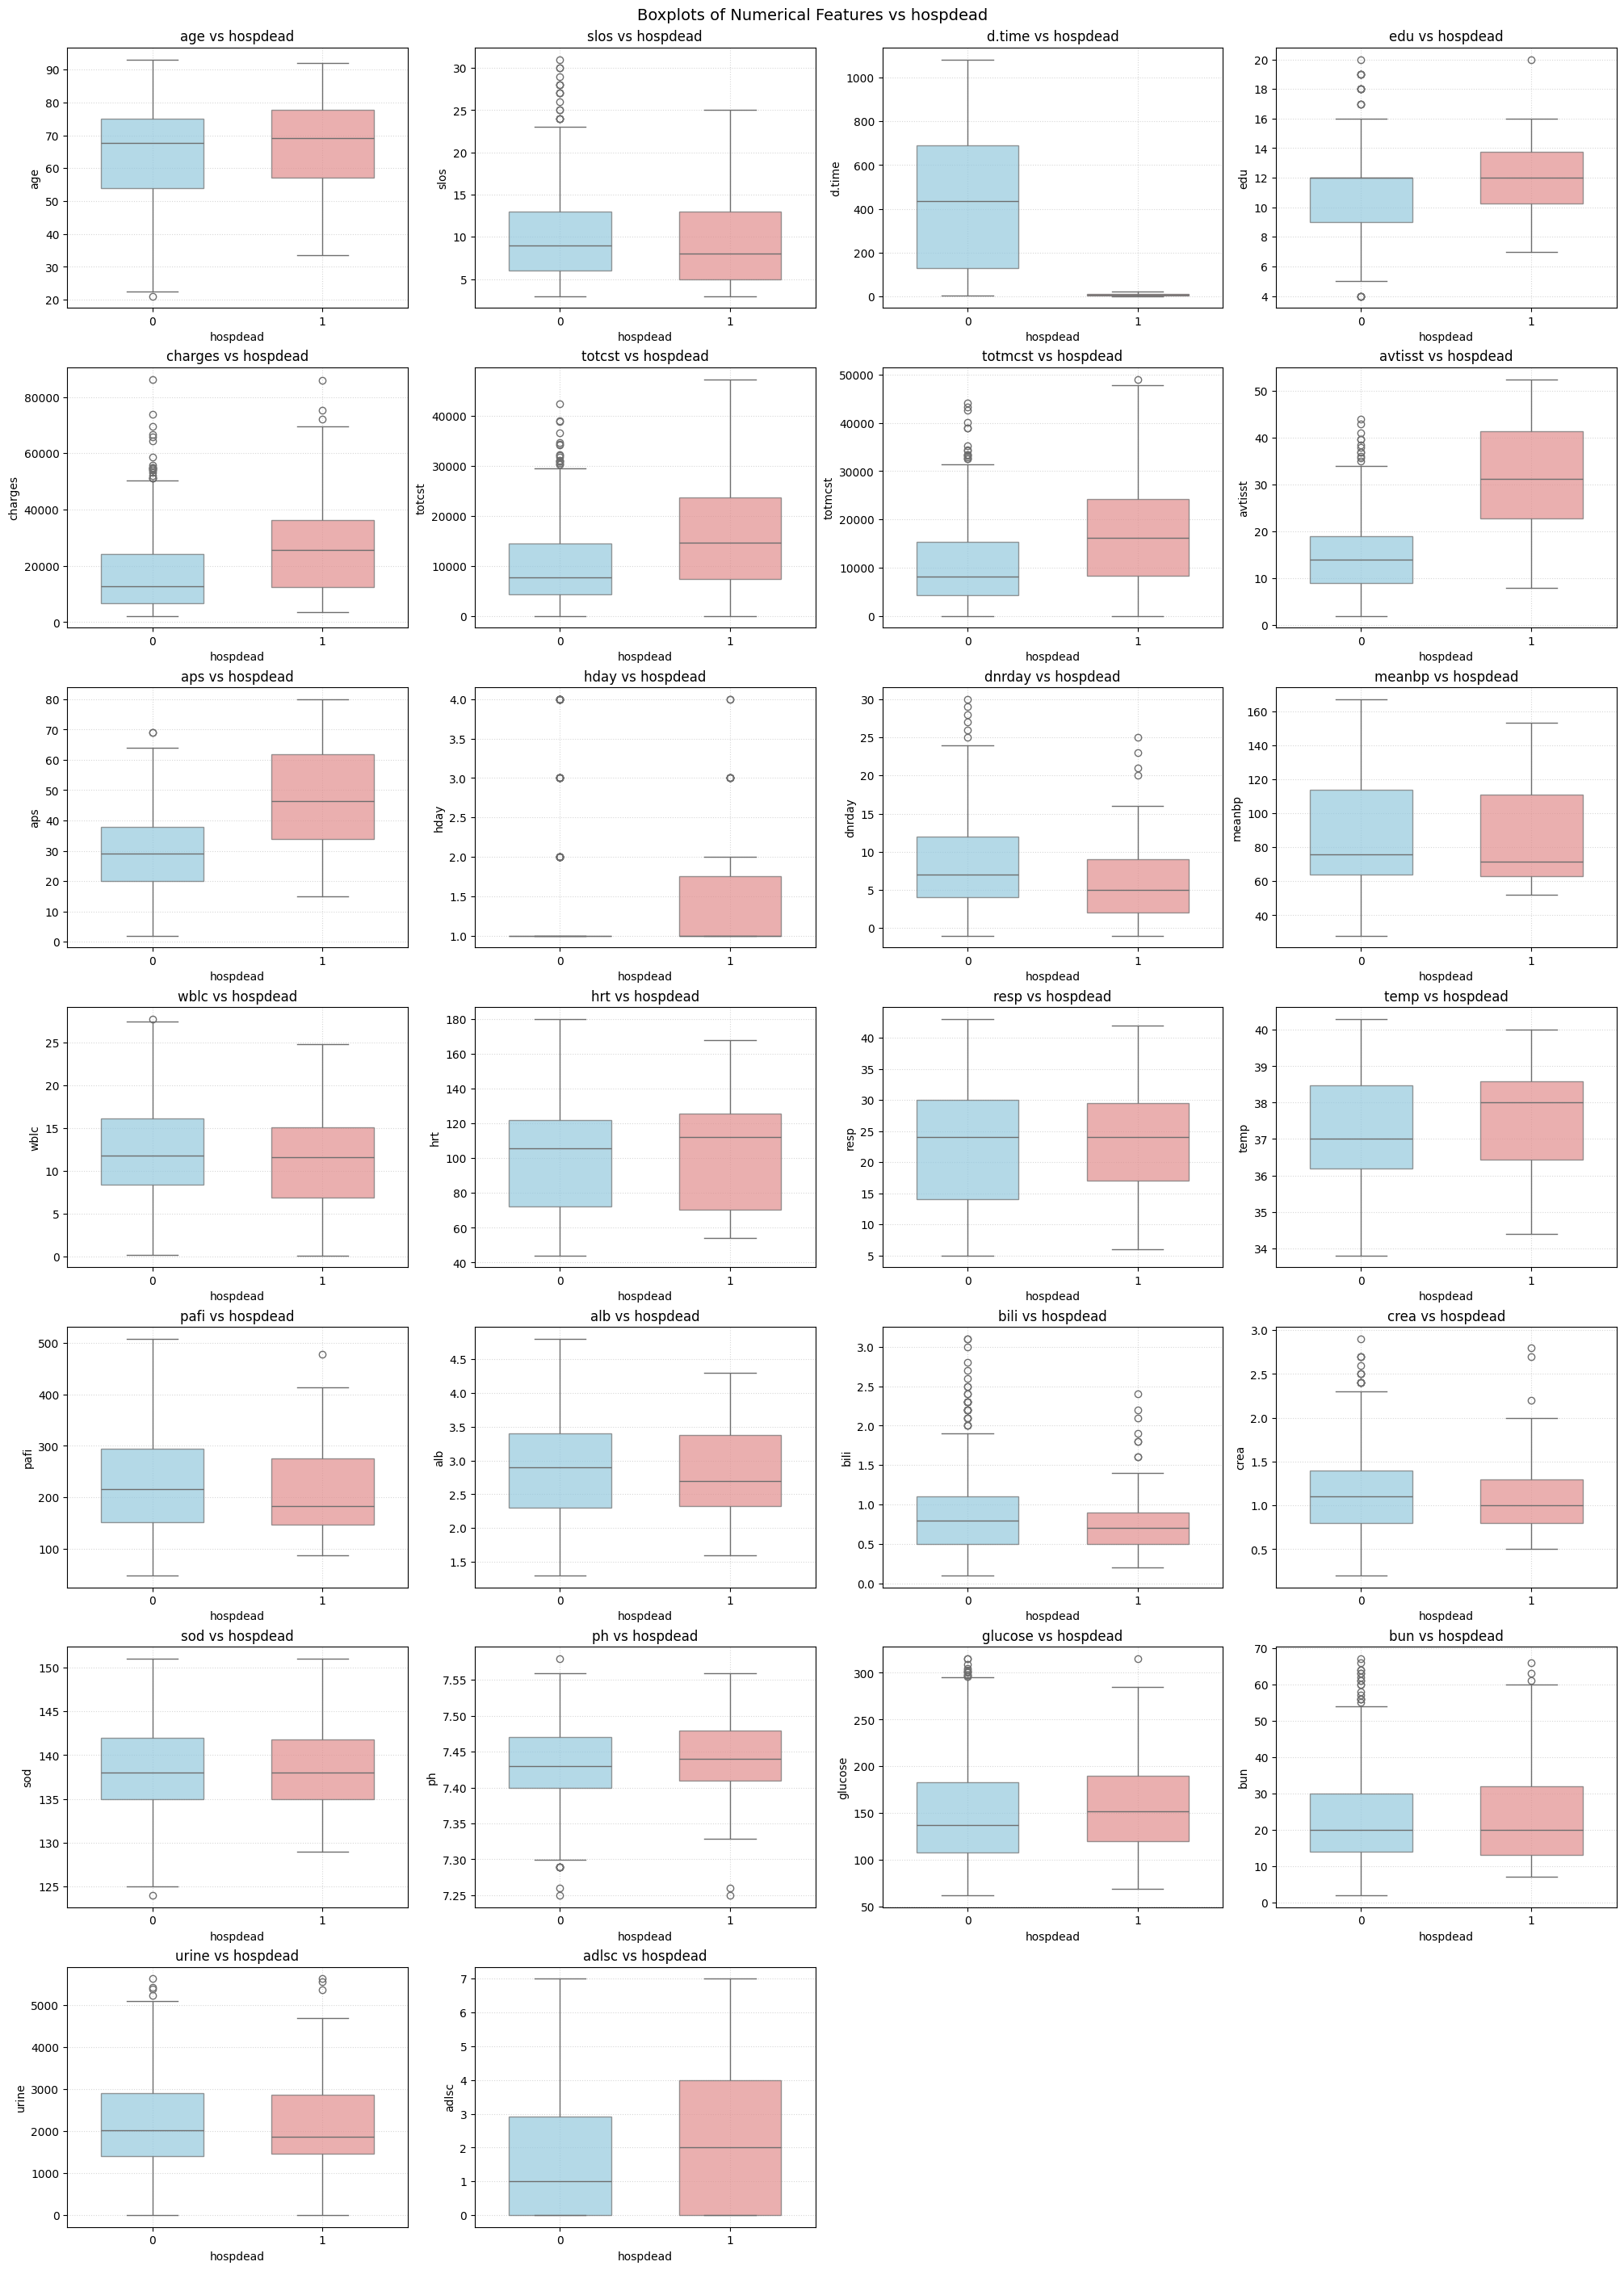

In [108]:
plot_box_grid(df_clean_2, num_feature, n_cols=4)

- ***Categorical Features***

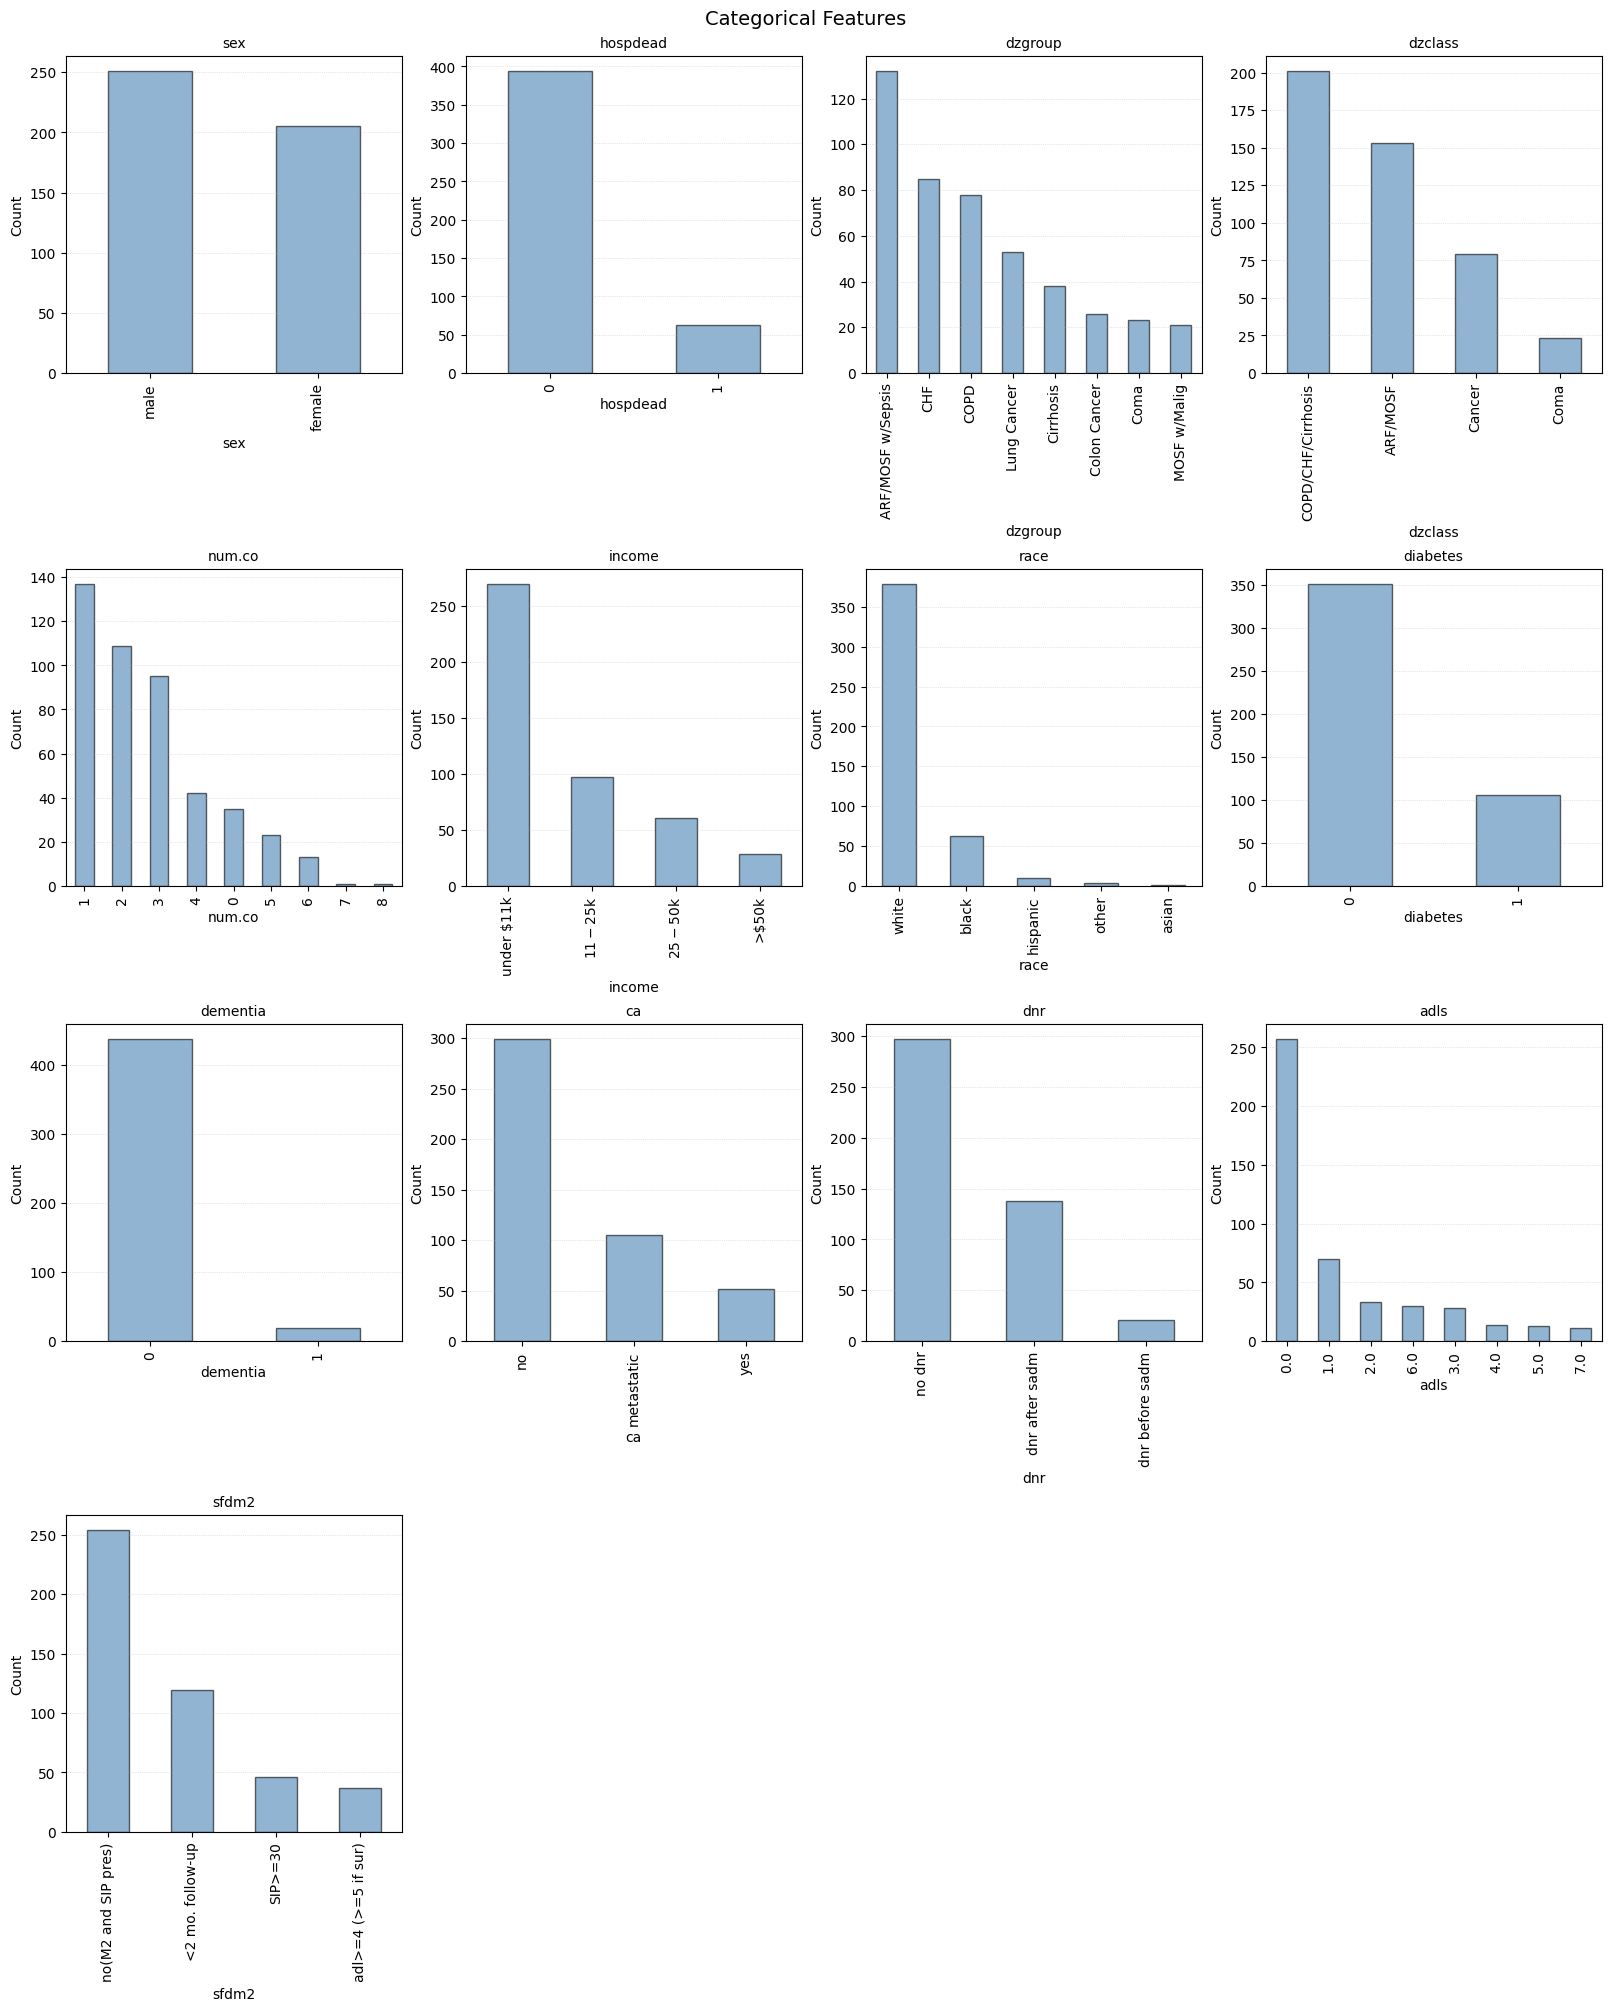

In [109]:
plot_categorical_bars(df_clean_2, cols=cat_feature, n_cols=4, top=None, normalize=False)

**📗Conclusion**
- Post-imputation histograms and boxplots confirm that data **distribution and spread remain unchanged**, indicating no distortion.

**📌Note:** Extreme outliers were removed via IQR/Z-score. Remaining **black dots** represent values beyond **1.5×IQR** per boxplot definition, not unremoved outliers.

### **12.2.4. Training and Testing Sample**

**Splitting the Data**
- **70%** of data is used as Training data and the rest **30%** is used as Tesing data.

In [110]:
target_var = ['hospdead'] 
cat_feature = [col for col in cat_feature if col != 'hospdead']
predicted_var = num_feature + cat_feature

In [111]:
X = df_clean_2[predicted_var]
y = df_clean_2[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

C:\Users\User\AppData\Local\Temp\ipykernel_30588\199811329.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=c.index, y=c.values, palette=pal, ax=ax, alpha=0.9, width=0.6)
C:\Users\User\AppData\Local\Temp\ipykernel_30588\199811329.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=c.index, y=c.values, palette=pal, ax=ax, alpha=0.9, width=0.6)


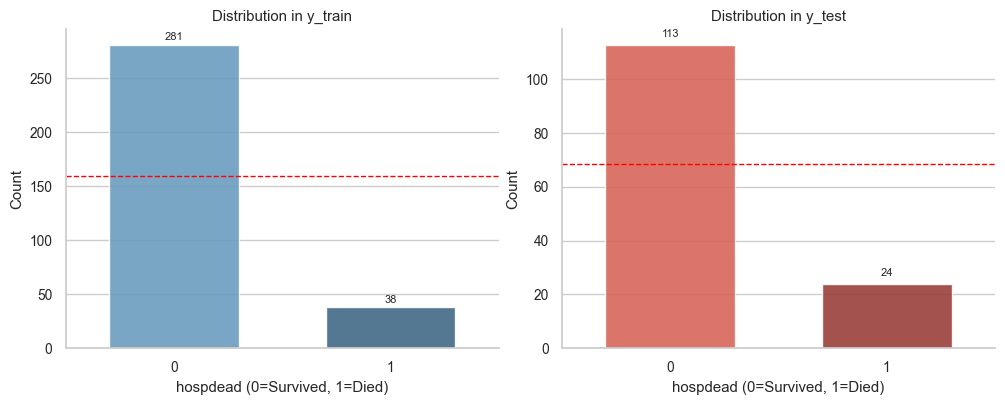

In [112]:
sns.set(style="whitegrid", font_scale=0.9)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, (data, pal, title) in zip(axes, [(y_train, "Blues_d", "y_train"), (y_test, "Reds_d", "y_test")]):
    c = data["hospdead"].value_counts().sort_index()
    sns.barplot(x=c.index, y=c.values, palette=pal, ax=ax, alpha=0.9, width=0.6)
    ax.axhline(c.mean(), color="red", ls="--", lw=1)
    for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, p.get_height()+2, f"{int(p.get_height())}",
                ha="center", va="bottom", fontsize=8)
    ax.set(title=f"Distribution in {title}", xlabel="hospdead (0=Survived, 1=Died)", ylabel="Count")
    sns.despine(ax=ax)

plt.tight_layout(pad=0.5)
plt.show()

In [113]:
train_df = X_train.copy()
train_df["hospdead"] = y_train

test_df = X_test.copy()
test_df["hospdead"] = y_test

print(train_df.shape)
print(test_df.shape)

(319, 39)
(137, 39)


## **12.3. Feature Selection by Visual Correlation Analysis and Statistical Measurement**

### **12.3.1. Relationship Exploration: Categorical Vs Categorical**

#### **12.3.1.1. Visual Exploration -- Grouped Bar Plots**

C:\Users\User\AppData\Local\Temp\ipykernel_30588\283731965.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.4)


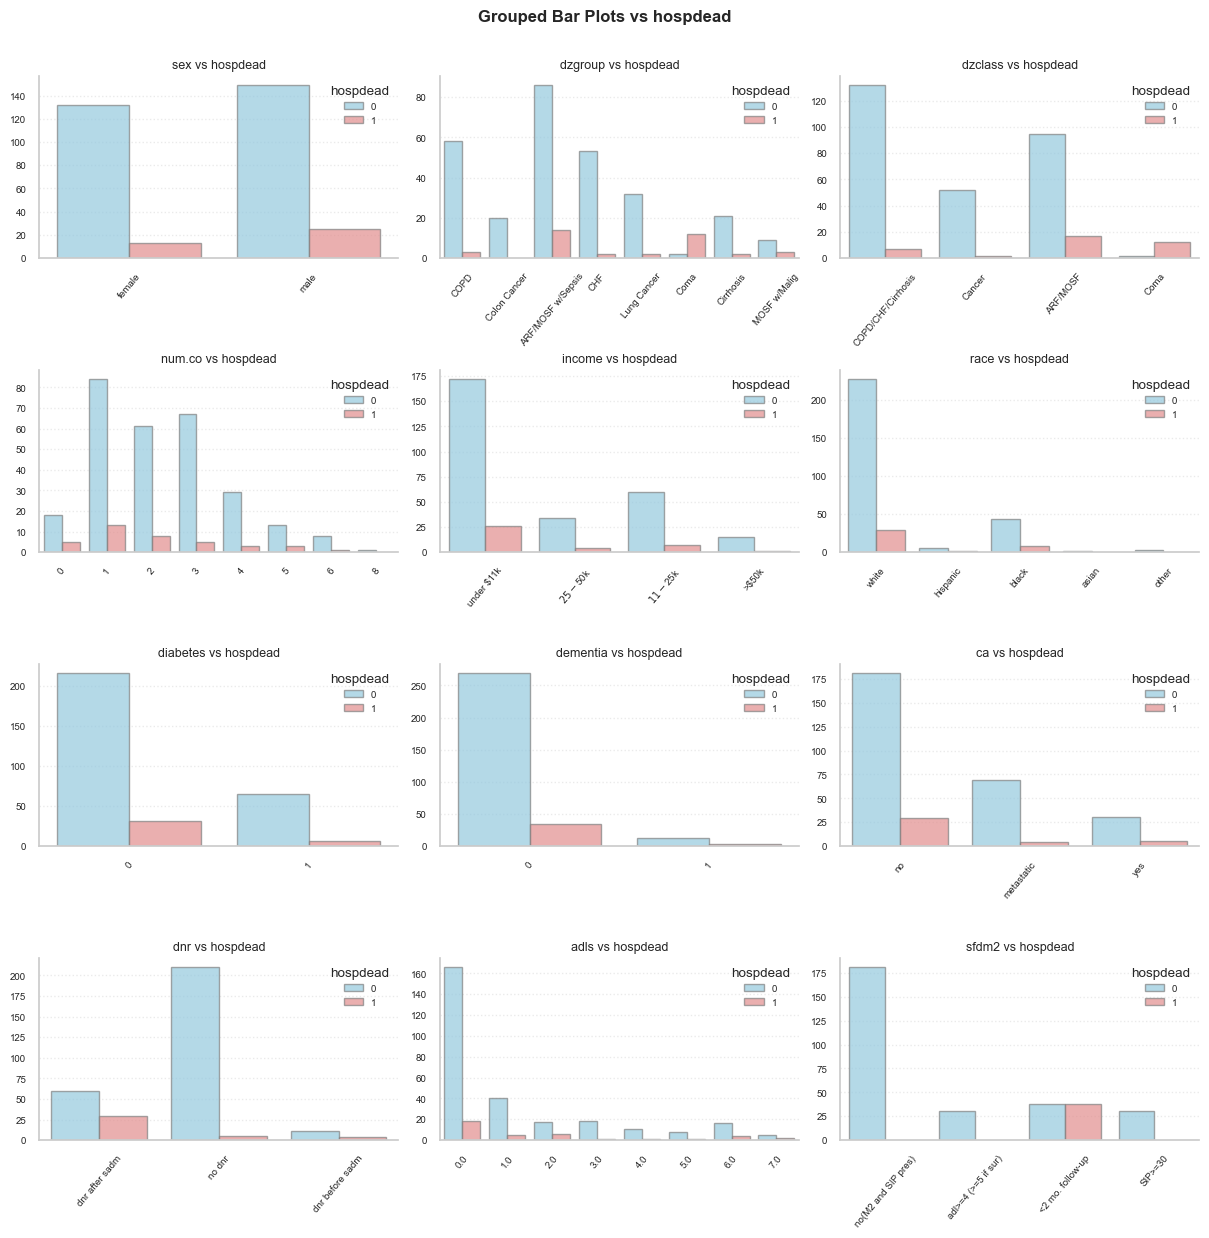

In [114]:
plot_grouped_bar_grid(train_df, x_cols=cat_feature, y_col='hospdead', n_cols=3)

#### **12.3.1.2. Statistical Feature Selection**

- Using **Chi-square** and **Mutual Information** together helps assess both **linear and non-linear relationships** with the target.

In [115]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
X_cat_encoded = train_df[cat_feature].apply(LabelEncoder().fit_transform)
y_encoded = LabelEncoder().fit_transform(train_df['hospdead'])
chi_scores, p_values = chi2(X_cat_encoded, y_encoded)
chi2_results = pd.DataFrame({'Feature': cat_feature, 'Chi2 Score': chi_scores, 'p-value': p_values}).sort_values('Chi2 Score', ascending=False)

In [116]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_cat_encoded, y_encoded, discrete_features=True, random_state=42)
mi_results = pd.DataFrame({'Feature': cat_feature,'MI Score': mi_scores}).sort_values('MI Score', ascending=False)

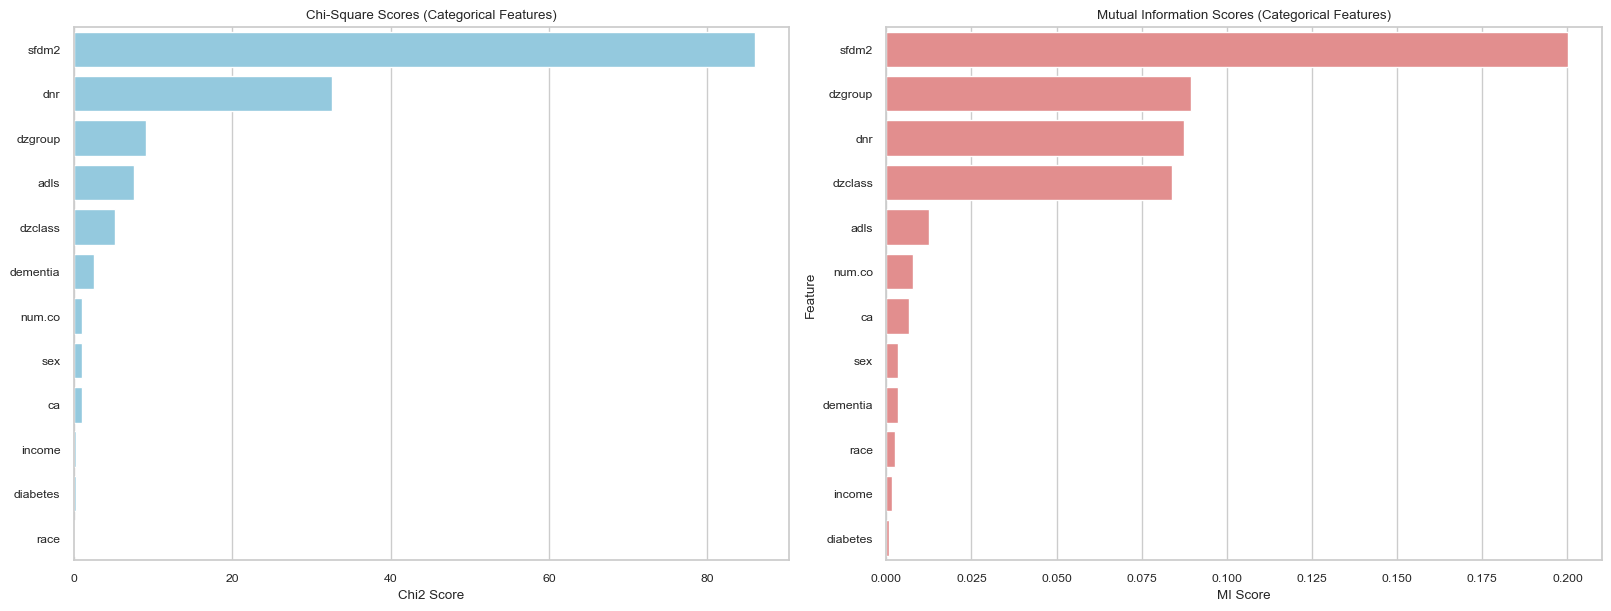

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
sns.barplot(x='Chi2 Score', y='Feature', data=chi2_results,color='skyblue', ax=axes[0])
axes[0].set_title("Chi-Square Scores (Categorical Features)")
axes[0].set_xlabel("Chi2 Score")
axes[0].set_ylabel("")
sns.barplot(x='MI Score', y='Feature', data=mi_results,color='lightcoral', ax=axes[1])
axes[1].set_title("Mutual Information Scores (Categorical Features)")
axes[1].set_xlabel("MI Score")
axes[1].set_ylabel("Feature")
plt.show()

In [118]:
s2_cat_feature = ['sfdm2','dnr']

**📊 Categorical Feature Selection**

**🔍 Interpretation Summary**

* **Strong Evidence of Association** → `sfdm2`, `dnr`  
  Both features show strong Chi-squared significance, indicating clear **linear dependence** with the target variable.

* **Moderate / Non-linear Association** → `dzgroup`, `dzclass`  
  These may display **non-linear or interaction-based effects**, warranting further investigation using Mutual Information.

* **Weak / No Association** → `adls`, `ca`, `num.co`, `sex`, `dementia`, `income`, `race`  
  These variables exhibit minimal evidence of association with the target, contributing little predictive value.

**📈 Statistical Summary**

| **Feature** | **Chi2** | **MI** | **Type of Relationship** | **Interpretation** |
|:--|:--|:--|:--|:--|
| `sfdm2` | High | High | Strong linear association | Functional disability scale strongly correlated with survival outcomes. |
| `dnr` | High | Moderate | Linear and possible non-linear | Do-Not-Resuscitate status consistently linked with hospital mortality. |
| `dzgroup` | Moderate | Moderate | Potential non-linear | Disease sub-category may affect mortality through complex interactions. |
| `dzclass` | Moderate | Moderate | Potential non-linear | Broader disease categories show mild non-linear relationships. |
| `adls`, `ca`, `num.co`, `sex`, `dementia`, `income`, `race` | Low | Low | Weak association | Minimal or inconsistent influence on target variable. |

**📥 Final Feature Selection**

| **Selected Feature** | **Reason for Inclusion** | **Type of Dependence** |
|:--|:--|:--|
| `sfdm2` | Shows strong linear dependence with the target variable, reflecting patient functional capacity. | Linear association |
| `dnr` | Displays strong linear and possible non-linear dependence; clinically and ethically significant indicator. | Linear / Non-linear association |

### **12.3.2. Relationship Exploration: Categorical Vs Continuous -- Box Plots**

#### **12.3.2.1. Visual Exploration**

In [119]:
def plot_box_grid(df, x_cols, y_col='hospdead', n_cols=3):
    n_rows = ceil(len(x_cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), constrained_layout=True)
    axes = axes.flatten()
    palette = ["skyblue", "lightcoral"]

    for i, col in enumerate(x_cols):
        sns.boxplot(data=df, x=y_col, y=col, palette=palette, ax=axes[i], width=0.6, showfliers=True, boxprops={'alpha': 0.7})
        axes[i].set(title=f"{col} vs {y_col}", xlabel=y_col, ylabel=col)
        axes[i].grid(linestyle=":", alpha=0.5)

    for ax in axes[len(x_cols):]:
        ax.set_visible(False)

    fig.suptitle(f"Boxplots of Numerical Features vs {y_col}", fontsize=14)
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_30588\12334736.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y_col, y=col, palette=palette, ax=axes[i], width=0.6, showfliers=True, boxprops={'alpha': 0.7})
C:\Users\User\AppData\Local\Temp\ipykernel_30588\12334736.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y_col, y=col, palette=palette, ax=axes[i], width=0.6, showfliers=True, boxprops={'alpha': 0.7})
C:\Users\User\AppData\Local\Temp\ipykernel_30588\12334736.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(dat

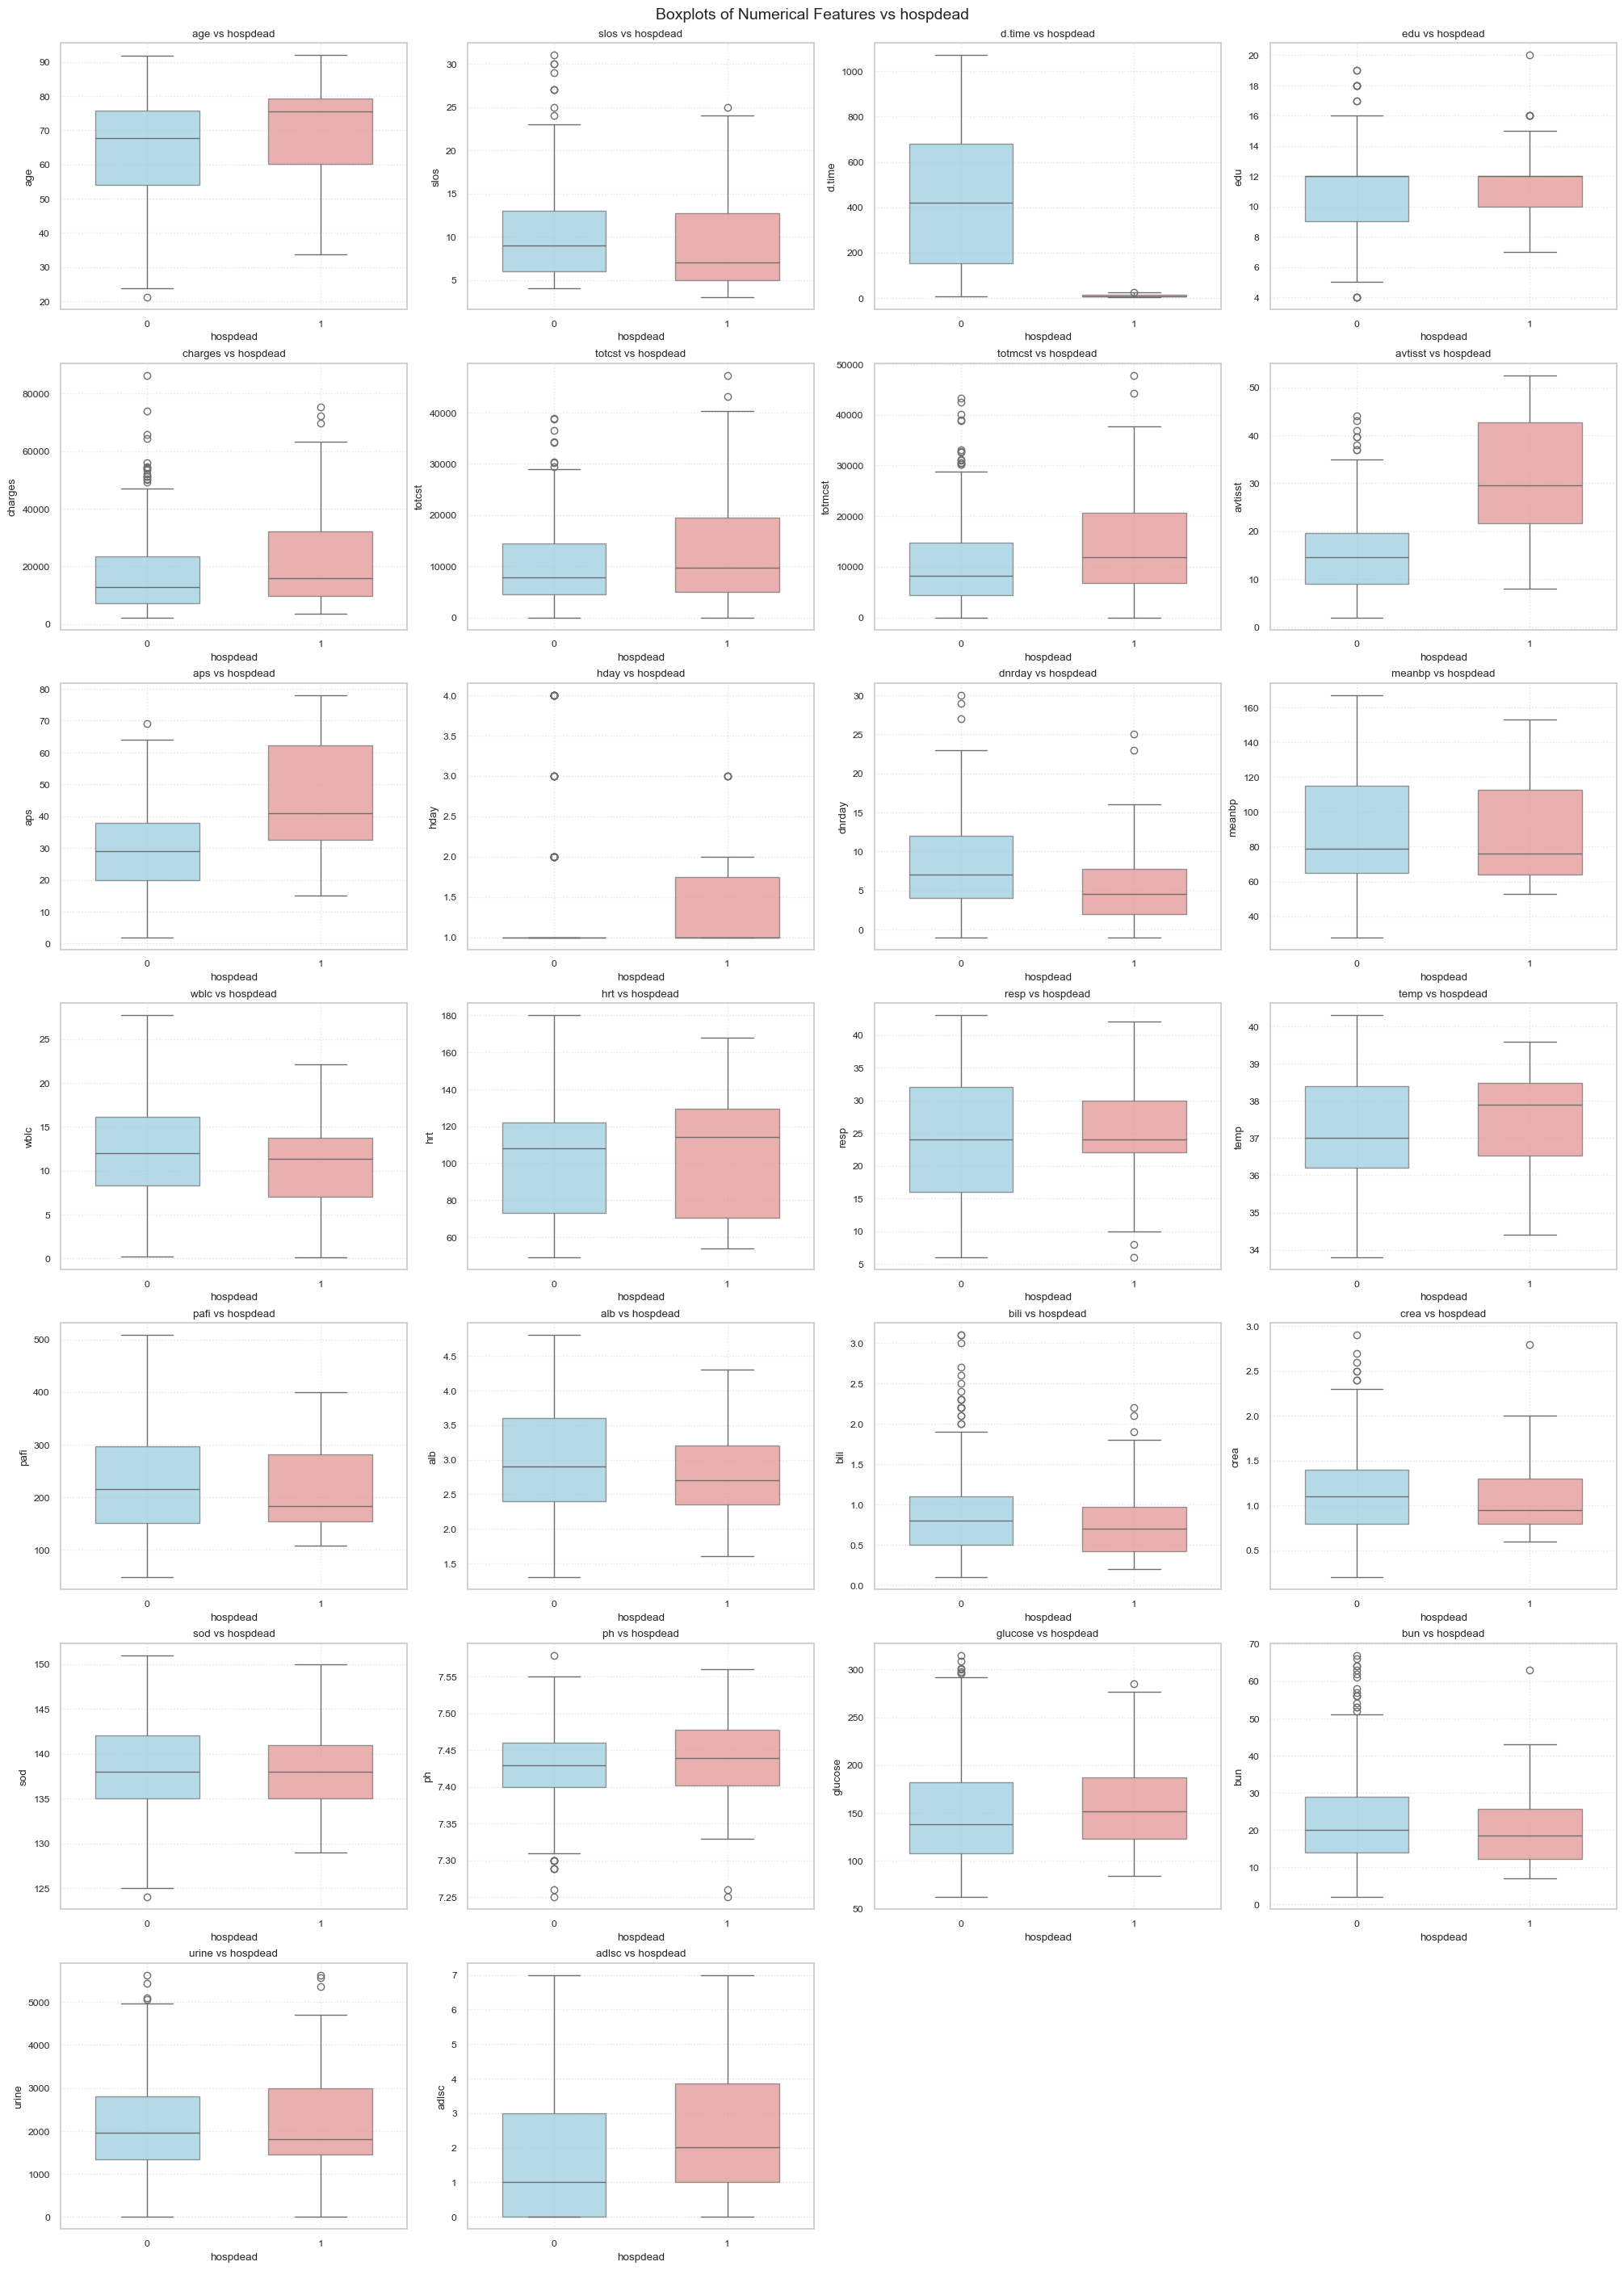

In [120]:
plot_box_grid(train_df, num_feature, y_col='hospdead', n_cols=4)

#### **12.3.2.2. Statistical Feature Selection**

- **ANOVA :**  Applied to assess the statistical significance of categorical predictors with respect to the target variable.

In [121]:
from scipy.stats import f_oneway

anova_results = []
for col in num_feature:
    g0 = train_df[train_df['hospdead']==0][col].dropna()
    g1 = train_df[train_df['hospdead']==1][col].dropna()
    f_stat, p_val = f_oneway(g0, g1)
    anova_results.append((col, p_val))

anova_results = sorted(anova_results, key=lambda x: x[1])

print("------- ANOVA Results -------\n")
significant = []
for col, p_val in anova_results:
    if p_val < 0.05:
        print(f"{col} is significantly correlated with hospdead | P-Value: {p_val:.3e}")
        significant.append(col)
    else:
        print(f"{col} is NOT significantly correlated with hospdead | P-Value: {p_val}")
print("\nSignificant predictors:", significant)

------- ANOVA Results -------

avtisst is significantly correlated with hospdead | P-Value: 6.481e-20
d.time is significantly correlated with hospdead | P-Value: 4.027e-16
aps is significantly correlated with hospdead | P-Value: 1.094e-10
totcst is significantly correlated with hospdead | P-Value: 2.638e-03
totmcst is significantly correlated with hospdead | P-Value: 4.628e-03
adlsc is significantly correlated with hospdead | P-Value: 6.218e-03
charges is significantly correlated with hospdead | P-Value: 7.501e-03
dnrday is significantly correlated with hospdead | P-Value: 1.708e-02
age is significantly correlated with hospdead | P-Value: 4.864e-02
wblc is NOT significantly correlated with hospdead | P-Value: 0.12456637755290845
hday is NOT significantly correlated with hospdead | P-Value: 0.19065771525735978
urine is NOT significantly correlated with hospdead | P-Value: 0.239651694472861
temp is NOT significantly correlated with hospdead | P-Value: 0.2537876098430669
bun is NOT signif

In [122]:
sig_num_features = ['avtisst', 'd.time', 'aps', 'totcst', 'totmcst', 'adlsc', 'charges', 'dnrday', 'age']

* **Mutual Information:** Features with a score above **0.03** are **retained** for further analysis.

C:\Users\User\AppData\Local\Temp\ipykernel_30588\1889529003.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mi_df, x='MI Score', y='Feature', palette='viridis')


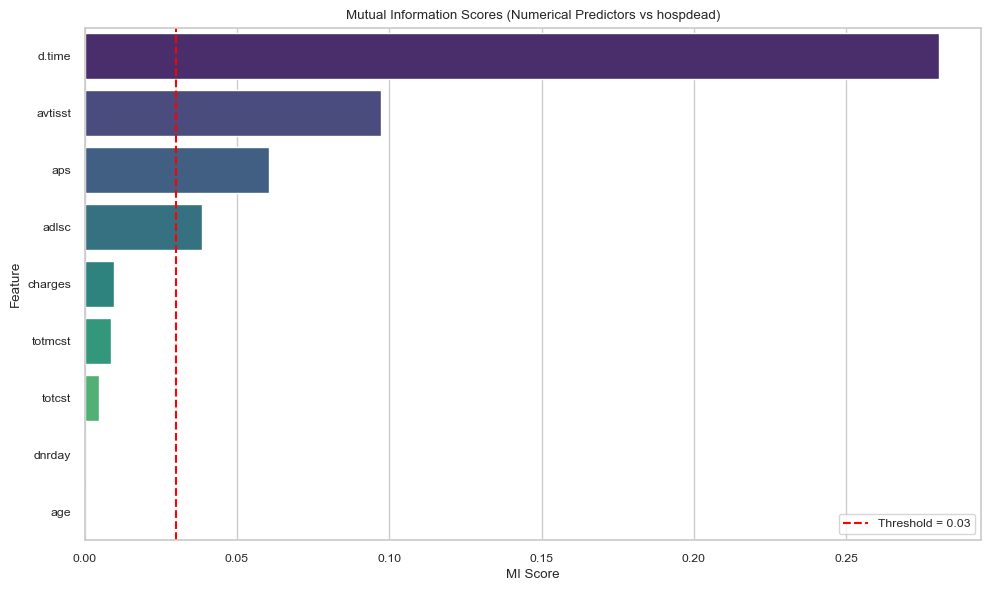

In [123]:
X, y = train_df[sig_num_features], train_df['hospdead']

mi_df = (pd.DataFrame({'Feature': X.columns,'MI Score': mutual_info_classif(X, y, random_state=42)}).sort_values('MI Score', ascending=False).reset_index(drop=True))

plt.figure(figsize=(10, 6))
sns.barplot(data=mi_df, x='MI Score', y='Feature', palette='viridis')
plt.title("Mutual Information Scores (Numerical Predictors vs hospdead)")
plt.axvline(0.03, color='red', ls='--', label='Threshold = 0.03')
plt.legend()
plt.tight_layout()
plt.show()

* **Pearson's Correlation:** Used to check **multicollinearity** between continuous features.

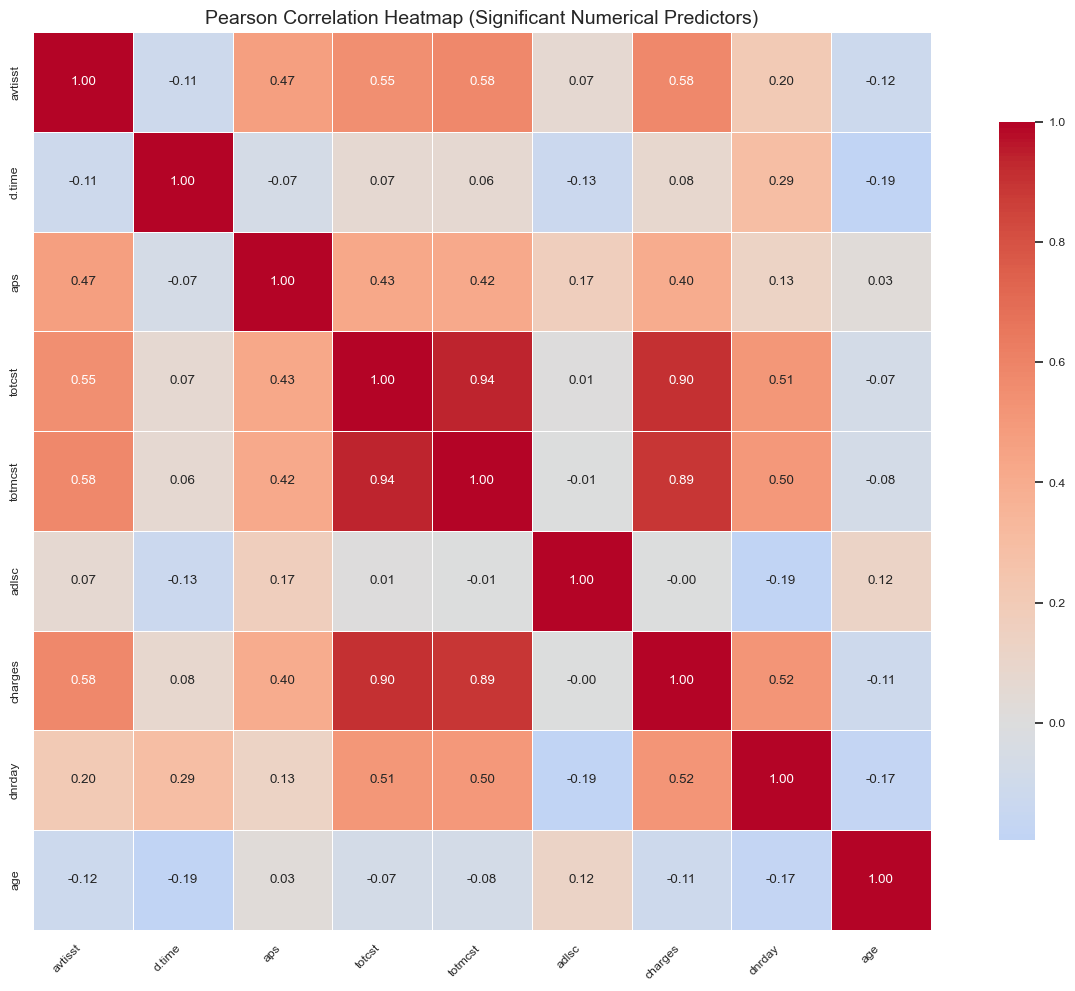

In [124]:
corr = train_df[sig_num_features].corr('pearson')

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title("Pearson Correlation Heatmap (Significant Numerical Predictors)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [125]:
s2_num_feature = ['d.time','avtisst','aps', 'adlsc']

**📊 Numerical Feature Selection**

**Objective:**  
Identify continuous predictors significantly associated with the categorical target **`hospdead`** through a combination of **linear**, **non-linear**, and **correlation-based** analyses.

**1️⃣ ANOVA (Linear Association)**
- Tested mean differences across `hospdead` groups.  
- **Significant (p < 0.05):** `avtisst`, `d.time`, `aps`, `totcst`, `totmcst`, `adlsc`, `charges`, `dnrday`, `age`  
- ➤ Indicates strong **linear dependence** between these predictors and the target.

**2️⃣ Mutual Information (Non-linear Association)**
- Captures both **linear** and **non-linear dependencies** (MI ≥ 0.03).  
- **Selected:** `d.time`, `avtisst`, `aps`, `adlsc`  
- ➤ Confirms consistent relevance across multiple dependency types.

**3️⃣ Pearson Correlation (Redundancy Check)**
- Removed features with high inter-correlation.  
  - `avtisst` retained (strongest link with target).  
  - `charges`, `totcst`, `totmcst` removed due to strong interdependence.  

**📥 Final Selected Continuous Features**

| **Feature** | **Reason for Inclusion** | **Type of Relationship** |
|:--|:--|:--|
| `d.time` | Strong significance across ANOVA and MI; captures survival-related follow-up duration. | Linear / Non-linear |
| `avtisst` | Reflects ICU activity and patient care intensity; stable, independent predictor. | Linear |
| `aps` | Clinical severity score showing consistent linear influence on mortality. | Linear |
| `adlsc` | Functional score contributing moderate non-linear association with outcomes. | Linear / Non-linear |

## **12.4. Selecting Final Predictors for Machine Learning Summary**
Based on the above tests, selecting the final columns for machine learning

In [126]:
SelectedColumns_2 = s2_cat_feature + s2_num_feature
df_ml = train_df[SelectedColumns_2] 
print("Data Frame Shape:",df_ml.shape)
print("Selected Features:", SelectedColumns_2)

Data Frame Shape: (319, 6)
Selected Features: ['sfdm2', 'dnr', 'd.time', 'avtisst', 'aps', 'adlsc']


## **12.5. Data Preprocessing for Machine Learning**

**📙Feature Summary**
| **Feature Type** | **Feature** |
|------------------|-------------|
| **Target** | hospdead |
| **Ordinary** | sfdm2 |
| **Nominal** | dnr |
| **Numerical** | d.time, avtisst, aps, adlsc |

### **12.5.1. Converting the Ordinal Variable to Numeric**

In [127]:
df_pp = train_df.copy()

In [128]:
sfdm2_mapping = {"<2 mo. follow-up": 0, "no(M2 and SIP pres)": 1, "adl>=4 (>=5 if sur)": 2, "SIP>=30": 3, "Coma or Intub": 4}
df_pp["sfdm2"] = df_pp["sfdm2"].map(sfdm2_mapping)
test_df["sfdm2"] = test_df["sfdm2"].map(sfdm2_mapping)

In [129]:
print(df_pp[["sfdm2"]].head())
print(test_df[["sfdm2"]].head())

      sfdm2
3102      1
7094      2
8900      1
3184      1
3150      0
      sfdm2
8552      1
2559      1
7659      3
6991      1
4941      1


### **12.5.2. Converting the Binary Variable to Numeric Using 1/0 Mapping**

In [130]:
binary_features = ['hospdead']
df_pp[binary_features].head()

hospdead
3102         0
7094         0
8900         0
3184         0
3150         0

In [131]:
for col in binary_features:
    if col in df_pp.columns:
        if df_pp[col].dtype == 'object':
            df_pp[col] = df_pp[col].map({'No': 0, 'Yes': 1, 'no': 0, 'yes': 1, '0': 0, '1': 1})
        else:
            df_pp[col] = df_pp[col].astype(int)
df_pp[binary_features].head()

hospdead
3102         0
7094         0
8900         0
3184         0
3150         0

In [132]:
for col in binary_features:
    if col in test_df.columns:
        if test_df[col].dtype == 'object':
            test_df[col] = test_df[col].map({'No': 0, 'Yes': 1, 'no': 0, 'yes': 1, '0': 0, '1': 1})
        else:
            test_df[col] = test_df[col].astype(int)
test_df[binary_features].head()

hospdead
8552         0
2559         0
7659         0
6991         0
4941         0

### **12.5.3. Converting the Nominal Variable to Numeric Using get_dummies()**

In [133]:
df_pp = pd.get_dummies(
    df_pp,
    columns=["dnr"],
    drop_first=False   # drop_first=True avoids dummy variable trap
)

In [134]:
df_pp.filter(regex=r'^(dnr)_').head()

dnr_dnr after sadm  dnr_dnr before sadm  dnr_no dnr
3102                True                False       False
7094                True                False       False
8900               False                False        True
3184                True                False       False
3150               False                 True       False

In [135]:
test_df = pd.get_dummies(
    test_df,
    columns=["dnr"],
    drop_first=False   # drop_first=True avoids dummy variable trap
)

In [136]:
test_df.filter(regex=r'^(dnr)_').head()

dnr_dnr after sadm  dnr_dnr before sadm  dnr_no dnr
8552               False                False        True
2559               False                False        True
7659               False                False        True
6991               False                False        True
4941                True                False       False

## **12.6. Data Transformation**

### **12.6.1. Transformation on Training Data**

***-------------Fixing Skewness-------------***

In [137]:
skew_vals = df_pp[s2_num_feature].skew().sort_values(ascending=False)
skew_df = pd.DataFrame({'Feature': skew_vals.index, 'Skewness': skew_vals.values})

***-------------Before Fixing-------------***

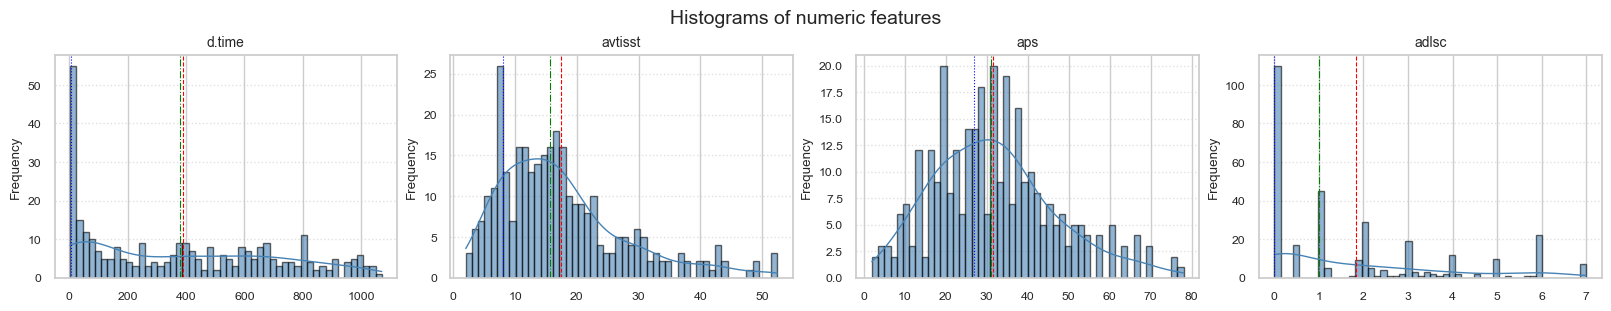

Feature  Skewness
0  avtisst  1.195026
1    adlsc  1.005630
2      aps  0.579234
3   d.time  0.365888

In [138]:
plot_hist_grid(df_pp, s2_num_feature, bins=50, n_cols=4)
display(skew_df)

In [139]:
df_skewfix = df_pp.copy()

In [140]:
# Apply log1p transformation to 'charges', 'avtisst', 'adlsc'
for col in ['avtisst', 'adlsc']:
    df_skewfix[col] = np.log1p(df_skewfix[col].clip(lower=0))
df_skewfix.replace([np.inf, -np.inf], np.nan, inplace=True)

In [141]:
skew_vals = df_skewfix[s2_num_feature].skew().sort_values(ascending=False)
skew_df = pd.DataFrame({'Feature': skew_vals.index, 'Skewness': skew_vals.values})

***-------------After Fixing-------------***

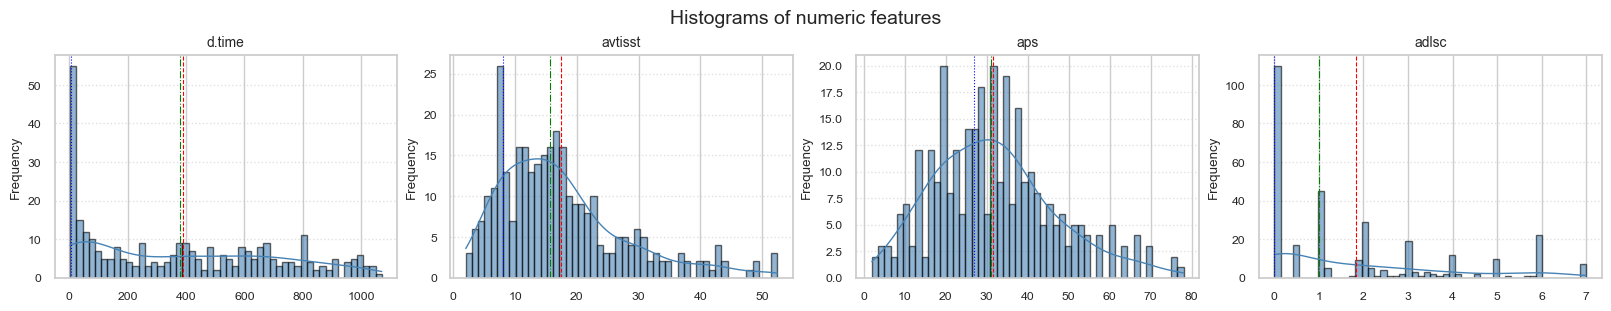

Feature  Skewness
0      aps  0.579234
1   d.time  0.365888
2    adlsc  0.244616
3  avtisst -0.167322

In [142]:
plot_hist_grid(df_pp, s2_num_feature, bins=50, n_cols=4)
display(skew_df)

***-------------Standardization-------------***

In [143]:
df_std = df_pp[s2_num_feature].copy()

In [144]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_std[s2_num_feature] = scaler.fit_transform(df_std[s2_num_feature])
print(df_std.head())
print(df_std.shape)

        d.time   avtisst       aps     adlsc
3102  0.282787 -0.625876 -1.053295  0.089798
7094 -0.922437 -0.920931 -0.850885 -0.906046
8900 -0.801605 -0.527524 -0.850885  0.584808
3184 -1.024680 -0.232468  0.296107  1.081760
3150 -1.114530 -0.084940  0.700928  2.075663
(319, 4)


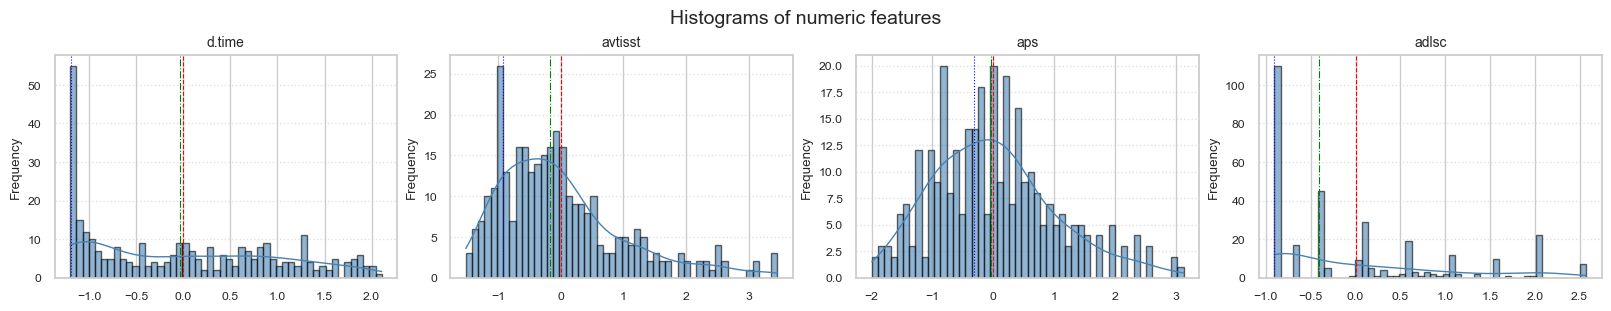

d.time     0
avtisst    0
aps        0
adlsc      0
dtype: int64

In [145]:
plot_hist_grid(df_std, s2_num_feature, bins=50, n_cols=4)
df_std[s2_num_feature].isnull().sum()

In [146]:
df_pp[s2_num_feature] = df_std[s2_num_feature]

### **12.6.2. Transformation on Testing Data**

***-------------Fixing Skewness-------------***

In [147]:
skew_vals = test_df[s2_num_feature].skew().sort_values(ascending=False)
skew_df = pd.DataFrame({'Feature': skew_vals.index,'Skewness': skew_vals.values})

***-------------Before Fixing-------------***

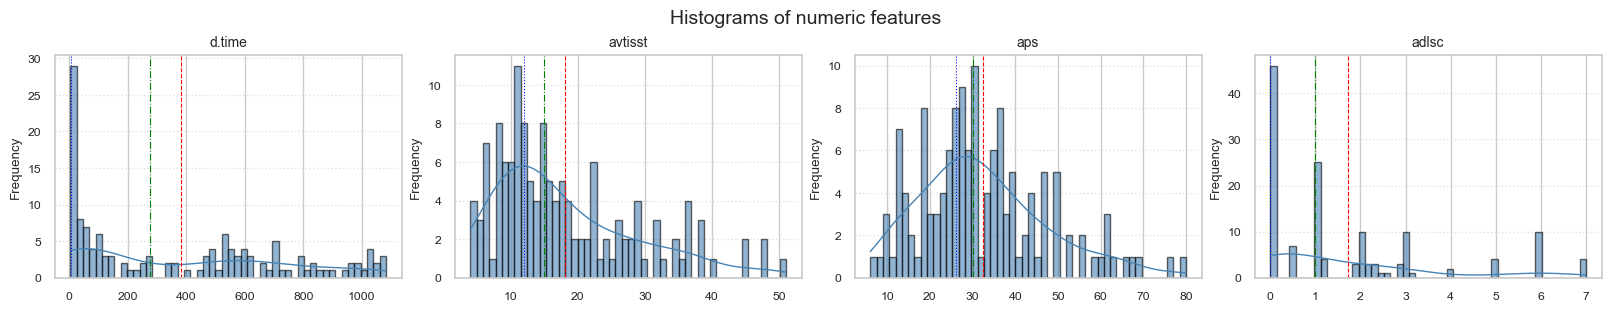

Feature  Skewness
0    adlsc  1.261619
1  avtisst  1.033835
2      aps  0.759964
3   d.time  0.493358

In [148]:
plot_hist_grid(test_df, s2_num_feature, bins=50, n_cols=4)
display(skew_df)

In [149]:
dft_skewfix = test_df.copy()

In [150]:
# Apply cube root transform
for col in ['d.time', 'aps', 'adlsc']:
    # Handle potential negative values before cube root
    dft_skewfix[col] = np.sqrt(dft_skewfix[col].clip(lower=0))   # cube root

# Apply log transform (add +1 to avoid log(0) errors)
for col in ['avtisst']:
    # Add a small constant and handle potential negative values before log
    dft_skewfix[col] = np.log1p(dft_skewfix[col].clip(lower=0))  # log(1+x)

# Replace infinite values with NaN
dft_skewfix.replace([np.inf, -np.inf], np.nan, inplace=True)

In [151]:
skew_vals = dft_skewfix[s2_num_feature].skew().sort_values(ascending=False)
skew_df = pd.DataFrame({'Feature': skew_vals.index, 'Skewness': skew_vals.values})

***-------------After Fixing-------------***

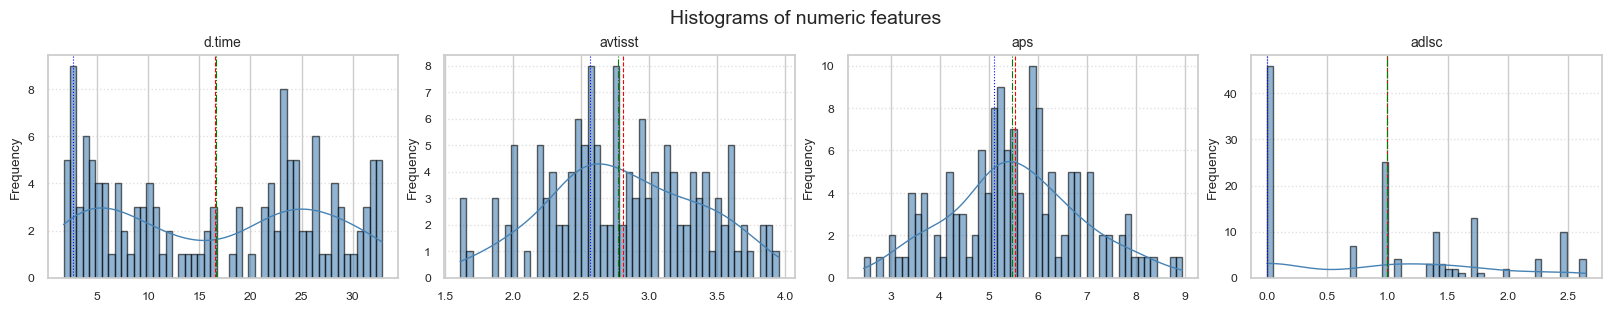

Feature  Skewness
0    adlsc  0.236384
1      aps  0.142859
2   d.time  0.012355
3  avtisst  0.003572

In [152]:
plot_hist_grid(dft_skewfix, s2_num_feature, bins=50, n_cols=4)
display(skew_df)

***-------------Standardization-------------***

In [153]:
dft_std = test_df[s2_num_feature].copy()

In [154]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dft_std[s2_num_feature] = scaler.fit_transform(dft_std[s2_num_feature])
print(dft_std.head())
print(dft_std.shape)

        d.time   avtisst       aps     adlsc
8552  1.715314 -0.957234 -1.228245  0.062782
2559  1.151763 -1.333445 -0.427597 -0.867551
7659 -0.359579 -0.298864 -0.827921 -0.867551
6991 -0.561661 -0.298864 -0.427597 -0.361624
4941 -0.772281  1.049227 -1.294966 -0.361624
(137, 4)


In [155]:
test_df[s2_num_feature] = dft_std[s2_num_feature]

## **12.7. Model Construction: Model 2 - With Outlier Treatment**

In [156]:
target = ['hospdead']

import re

dummy_cols = [col for col in df_pp.columns if re.match(r'^(dnr)_', col)]
all_predictors_2 = s2_num_feature + dummy_cols + ['sfdm2']
X_train, y_train = df_pp[all_predictors_2].values, df_pp[target].values
X_test, y_test = test_df[all_predictors_2].values, test_df[target].values

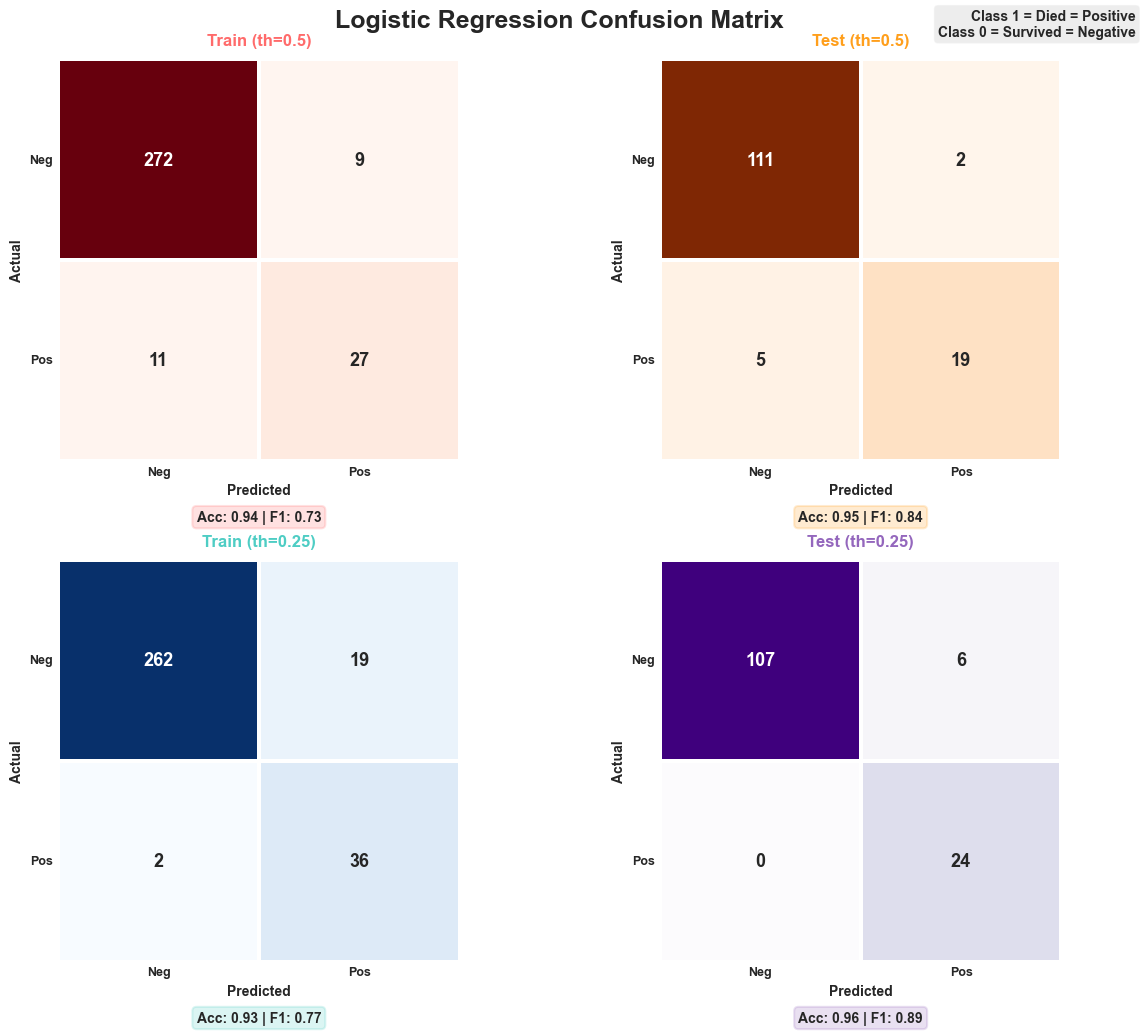

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ==================== ADJUSTABLE PARAMETERS ====================
THRESHOLD_1 = 0.5  # First threshold
THRESHOLD_2 = 0.25  # Second threshold
FIGSIZE = (12, 10)
# ========================================================

# Train model
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train.ravel())
y_train_prob = log_reg.predict_proba(X_train)[:, 1]
y_test_prob = log_reg.predict_proba(X_test)[:, 1]

# Calculate ROC & AUC
fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_prob)
fpr_te, tpr_te, _ = roc_curve(y_test, y_test_prob)
auc_tr, auc_te = auc(fpr_tr, tpr_tr), auc(fpr_te, tpr_te)

# Helper functions
def predict(th):
    return (y_train_prob >= th).astype(int), (y_test_prob >= th).astype(int)

def plot_cm(ax, y_true, y_pred, title, cmap, color):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc, f1 = (tp+tn)/cm.sum(), 2*tp/(2*tp+fp+fn+1e-6)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, ax=ax, square=True,
                annot_kws={'fontsize':13,'weight':'bold'}, linewidths=1.5, linecolor='w')
    ax.set_title(title, fontsize=12, color=color, weight='bold', pad=10)
    ax.set_xlabel("Predicted", fontsize=10, weight='bold')
    ax.set_ylabel("Actual", fontsize=10, weight='bold')
    ax.set_xticklabels(['Neg', 'Pos'], fontsize=9, weight='bold')
    ax.set_yticklabels(['Neg', 'Pos'], fontsize=9, rotation=0, weight='bold')
    ax.text(0.5, -0.15, f"Acc: {acc:.2f} | F1: {f1:.2f}", ha='center', transform=ax.transAxes,
            fontsize=10, weight='bold', bbox=dict(boxstyle='round', facecolor=color, alpha=0.2, edgecolor=color, linewidth=1.5))

# Plot
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(2, 2, figsize=FIGSIZE, constrained_layout=True)
ax = ax.flatten()
fig.suptitle("Logistic Regression Confusion Matrix", fontsize=18, weight='bold', y=1.02)
fig.text(0.98, 1.02, "Class 1 = Died = Positive\nClass 0 = Survived = Negative", 
         ha='right', va='top', fontsize=10, weight='bold', 
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.4))

# Plot confusion matrices
configs = [
    (0, y_train, predict(THRESHOLD_1)[0], f"Train (th={THRESHOLD_1})", "Reds", "#FF6B6B"),
    (1, y_test, predict(THRESHOLD_1)[1], f"Test (th={THRESHOLD_1})", "Oranges", "#FF9F1C"),
    (2, y_train, predict(THRESHOLD_2)[0], f"Train (th={THRESHOLD_2})", "Blues", "#4ECDC4"),
    (3, y_test, predict(THRESHOLD_2)[1], f"Test (th={THRESHOLD_2})", "Purples", "#9467bd")
]

for i, y, yhat, title, cmap, color in configs:
    plot_cm(ax[i], y, yhat, title, cmap, color)

plt.show()

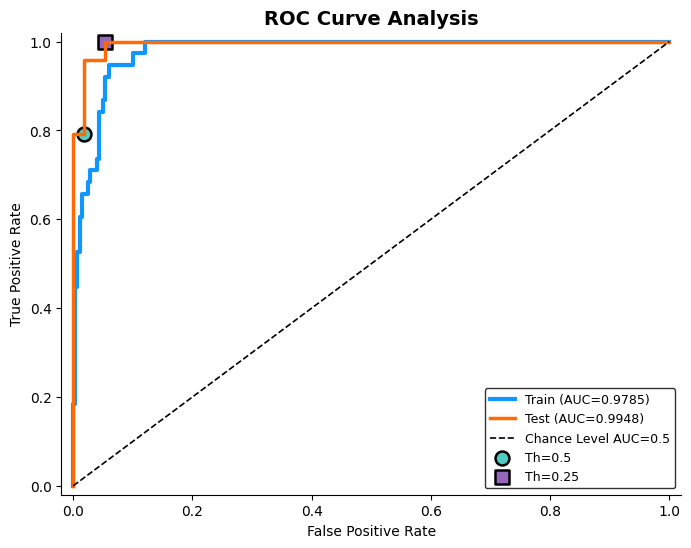


ROC Analysis Summary:
Train AUC: 0.9785
Test AUC: 0.9948
AUC Diff: 0.0164


In [158]:
# === ROC Curve Visualization ===
plt.style.use('default')  # ensures white background
plt.figure(figsize=(8, 6))
plt.plot(fpr_tr, tpr_tr, lw=3, color="#1097FF", label=f"Train (AUC={auc_tr:.4f})")
plt.plot(fpr_te, tpr_te, lw=2.5, color="#FF6B02", label=f"Test (AUC={auc_te:.4f})")
plt.plot([0, 1], [0, 1], '--', color='black', lw=1.2, label='Chance Level AUC=0.5')

# Mark thresholds
_, _, thr_te = roc_curve(y_test, y_test_prob)
for th, color, marker in zip([THRESHOLD_1, THRESHOLD_2], ["#4ECDC4", "#9467bd"], ['o', 's']):
    idx = np.argmin(np.abs(thr_te - th))
    plt.scatter(fpr_te[idx], tpr_te[idx], s=100, c=color, edgecolor='black', marker=marker, lw=1.8, label=f'Th={th}')

plt.title("ROC Curve Analysis", fontsize=14, weight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend(loc='lower right', frameon=True, fancybox=True, edgecolor='black', fontsize=9)
sns.despine()
plt.show()

print(f"\nROC Analysis Summary:\nTrain AUC: {auc_tr:.4f}\nTest AUC: {auc_te:.4f}\nAUC Diff: {abs(auc_tr - auc_te):.4f}")

In [159]:
# --- Metric Function ---
def calc_metrics(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    div = lambda a, b: a / b if b else 0
    return {
        'Accuracy': (TP + TN) / (TP + TN + FP + FN),
        'Specificity': div(TN, TN + FP),
        'Precision': div(TP, TP + FP),
        'Sensitivity': div(TP, TP + FN)
    }

# --- Predictions ---
y_train_prob, y_test_prob = log_reg.predict_proba(X_train)[:, 1], log_reg.predict_proba(X_test)[:, 1]
predict_at = lambda th: ((y_train_prob >= th).astype(int), (y_test_prob >= th).astype(int))
preds = {THRESHOLD_1: predict_at(THRESHOLD_1), THRESHOLD_2: predict_at(THRESHOLD_2)}

# --- Summary ---
print("\n" + "="*65)
print(" Logistic Regression Performance Summary ".center(65))
print("="*65)

for th, (ytr, yte) in preds.items():
    tr, te = calc_metrics(y_train, ytr), calc_metrics(y_test, yte)
    df = pd.DataFrame({'Metric': tr.keys(),
                       'Train (%)': [f"{v*100:.2f}" for v in tr.values()],
                       'Test (%)': [f"{v*100:.2f}" for v in te.values()]})
    print(f"\nThreshold = {th:.2f}\n" + df.to_string(index=False) + "\n" + "-"*65)

print("="*65 + "\n")


             Logistic Regression Performance Summary             

Threshold = 0.50
     Metric Train (%) Test (%)
   Accuracy     93.73    94.89
Specificity     96.80    98.23
  Precision     75.00    90.48
Sensitivity     71.05    79.17
-----------------------------------------------------------------

Threshold = 0.25
     Metric Train (%) Test (%)
   Accuracy     93.42    95.62
Specificity     93.24    94.69
  Precision     65.45    80.00
Sensitivity     94.74   100.00
-----------------------------------------------------------------



In [160]:
coef_df = pd.Series(log_reg.coef_[0], index=all_predictors_2).abs().sort_values(ascending=False).to_frame('Magnitude')

print("\n" + "="*45)
print("  Logistic Regression Coefficients")
print("="*45)
print("\nTop Features by Importance:\n")
print(coef_df.to_string())
print(f"\nIntercept (Bias): {log_reg.intercept_[0]:.4f}")
print("="*45 + "\n")


  Logistic Regression Coefficients

Top Features by Importance:

                     Magnitude
sfdm2                 2.087148
dnr_no dnr            1.260848
d.time                0.949628
avtisst               0.822404
aps                   0.370020
dnr_dnr after sadm    0.175342
adlsc                 0.067660
dnr_dnr before sadm   0.018854

Intercept (Bias): -1.4173



# **13. Model Logistic Regression Analysis**

**📐 Evaluation Metrics**

These metrics evaluate how well the model predicts whether a patient **died in hospital (`hospdead = yes`)** or **survived (`hospdead = no`)**.

| **Metric** | **Formula** | **Meaning (in this dataset)** |
|:--|:--:|:--|
| **Sensitivity (Recall)** | $\frac{TP}{TP + FN}$ | How well the model finds **actual deaths**. |
| **Specificity** | $\frac{TN}{TN + FP}$ | How well it identifies **true survivors**. |
| **Precision** | $\frac{TP}{TP + FP}$ | Of all patients predicted to **die**, how many actually did. |
| **Accuracy** | $\frac{TP + TN}{TP + TN + FP + FN}$ | Overall percent of correct predictions. |
| **F₁ Score** | $\frac{2 \times (\text{Precision} \times \text{Recall})}{\text{Precision} + \text{Recall}}$ | Balance between catching real deaths and avoiding false ones. |

---

**📈 ROC and AUC Interpretation**

**ROC (Receiver Operating Characteristic) Curve:**  
- The ROC curve shows how well the model separates **deaths** (`hospdead = yes`) from **survivors** (`hospdead = no`) across all possible classification thresholds.  
- It plots **True Positive Rate (Sensitivity)** on the Y-axis against **False Positive Rate (1 − Specificity)** on the X-axis.  
- A good model’s curve **bows toward the top-left corner**, meaning it catches more true deaths while minimizing false alarms.

**AUC (Area Under the Curve):**  
- The AUC summarizes overall performance of the ROC curve into a single number between **0 and 1**.  
- **AUC = 1.0** → Perfect model (all deaths and survivors correctly separated).  
- **AUC = 0.5** → No better than random guessing.  
- In this dataset, a **higher AUC** means the model is **better at distinguishing patients who died vs. survived**, regardless of the decision threshold.

## **13.1. Overfitting or not? Why?**

**Model 1 – Without Outlier Treatment**  
**Optimal Threshold:** 0.008  
- **No Overfitting:** Training AUC = **0.9915**, Testing AUC = **0.9901** (almost identical).  
- Performs **robustly on unseen data** with excellent class discrimination.

---

**Model 2 – With Outlier Treatment**  
**Optimal Threshold:** 0.250  
- **No Overfitting:** Training AUC = **0.9785**, Testing AUC = **0.9948** (consistent performance).  
- Handles **outliers effectively**, though the slight AUC gap may reflect subtle distribution shifts after cleaning.

---

**📈 Conclusion**
- Both models demonstrate **strong generalization** and **no overfitting**.  
- **Model 1** offers a slightly tighter AUC alignment, showing ultra-stable performance.  
- **Model 2** remains equally reliable, potentially more **robust to data noise** after outlier treatment.  

## **13.2. How accurate is each model? Which model gives the most accuracy? Why?**

**Model 1 – Without Outlier Treatment**  
- **Accuracy (Th=0.500):** Train **96.11%**, Test **79.21%**  
- **Accuracy (Th=0.008):** Train **85.88%**, Test **93.52%**  
- Optimal threshold **(0.008)** improves Test accuracy by balancing **Precision** and **Recall**, boosting overall **F1-score**.

---

**Model 2 – With Outlier Treatment**  
- **Accuracy (Th=0.500):** Train **93.73%**, Test **94.89%**  
- **Accuracy (Th=0.250):** Train **93.42%**, Test **95.62%**  
- Achieves **highest Test accuracy (95.62%)**, indicating better predictive **stability** after outlier handling.

---

**📈 Conclusion**
- Both models perform **strongly** and **generalize well**.  
- **Model 1** benefits from threshold tuning but remains more sensitive to outliers.  
- **Model 2** delivers **higher overall accuracy** and **better balance** between **Sensitivity** and **Precision**.  
- **Comparison:** **Model 2** is **more robust and reliable** for hospital mortality prediction.

## **13.3. Based on the evaluation metrics, can the model be used in real situations?**

**Model 1: Without Outlier Treatment (Threshold = 0.008)**
- Achieves very high **Sensitivity (99.01%)**, missing 7 actual deaths.  
- It produces **170 False Positives** (patients predicted to die but who survived), leading to unnecessary treatments of medical resources.  
- Despite strong detection ability. But, the model is **not suitable for real deployment** due to **low Precision** and **excessive false alarms.**

**Model 2: With Outlier Treatment (Threshold = 0.250)**
- Reaches **perfect Sensitivity (100%)**, detecting all actual deaths with **no False Negatives**.  
- Still generates **6 False Positives**, leading to unnecessary treatments but not as much as Model 1. 
- The model 2 is **efficient and more reliable** for medical use, though reducing False Positives would further improve efficiency.

**📈 Conclusion**

- **Model 1** is **unsuitable** for real-world use due to 170 False Positives and missed deaths.  
- **Model 2** is **clinically reliable, *But not actually suitable for real world***, ensuring no missed deaths, but **false positives still occurs** which can cause a excessive treatment costs.

## **13.4. What features are important and sufficient?**

💡 *According to the **logistic regression coefficients** of both models*

**Model 1 – Without Outlier Treatment**  
- **Top Features:** `d.time`, `dnr_no_dnr`, `dnr_dnr_before_sadm`
- These features strongly influence mortality prediction.  
- The dataset provides **sufficient predictive information** to achieve AUC ≈ 0.99.

**Model 2 – With Outlier Treatment**  
- **Top Features:** `sfdm2`, `dnr_no_dnr`, `d.time`  
- The new feature `sfdm2` becomes dominant after outlier cleaning.  
- Feature sufficiency remains strong, supporting consistent high AUC.

**📈 Conclusion**

- Both models rely on clinically meaningful variables, but **Model 2’s inclusion of `sfdm2`** enhances interpretability and predictive power. Which means `sfdm2` take a significant effect to the model.

## **13.5. How Do Different Settings Affect the Model’s Performance?**

**Model 1 – Without Outlier Treatment**  
- **Threshold 0.500:** (Training Default) Prioritizes Precision and Specificity but reduces Sensitivity (19.43%) — **not suitable for medical use.**
- **Threshold 0.008:** **Increases Sensitivity (99.01%)** with a small Precision trade-off (80.41%), improving F1-score and reliability.

**Model 2 – With Outlier Treatment**  
- **Threshold 0.500:** (Training Default) Sensitivity = 79.17% **(missed 5 deaths)**.**  
- **Threshold 0.250:** Sensitivity = 100.00% **(no missed deaths)**, though Precision drops slightly to 80.00%.

**📈 Conclusion**
- **Lowering the threshold** in both models dramatically improves **Sensitivity**.  
Model 2’s optimized threshold (0.25) eliminates all False Negatives, ideal for high-risk scenarios.

## **13.6. From Error Analysis, What Characteristics of the Data Make the Model Less Effective? What Is the Limitation?**

**Model 1 – Without Outlier Treatment**  
- **Th=0.500:** Imbalanced data causes bias toward the negative class (Survived).  
- **Th=0.008:** Only 7 False Negatives remain; these cases likely have atypical patient patterns or recording inconsistencies from **outliers.**  
- **Limitation:** Still fails on rare patterns with low predicted probabilities (<0.01).

**Model 2 – With Outlier Treatment**  
- **Th=0.250:** No False Negatives, but 6 False Positives remain — patients predicted as Dead but survived.  
- These may represent patients with severe indicators but successful recovery.  
- **Limitation:** Slightly higher False Positives increase unnecessary interventions.

**📈 Conclusion**
- Model 1 suffers from **imbalanced learning (No outliers treatment)**, while Model 2’s limitation lies in **resource inefficiency** due to a few False Positives.

## **13.7. How to Improving the Model for Real-World Problem (Additional)**

**Model 1 – Without Outlier Treatment**  
- Conduct deeper **residual analysis** for the 7 misclassified cases to identify hidden patterns.  
- Experiment with **robust models** (e.g., Random Forest, Gradient Boosting) to reduce False Negatives.

**Model 2 – With Outlier Treatment**  
- Focus on improving **Precision** while maintaining 100% Sensitivity.  
- Add new clinical features or use **ensemble techniques** (e.g., stacking Model 1 and Model 2) to further refine predictions.

**📈 Conclusion**
- Both models perform well, but **Model 2 is superior**.  

**Future improvements:** should target **reducing False Positives without sacrificing Sensitivity**, ensuring optimal clinical application.